## Hackathon

In [3]:
import xarray as xr
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm

xr.set_options(display_style="text")

## Data loader om data uit de grote set te halen.

Gebruik `loader.get_subset()` voor specifieke ranges van tijd, longitude en latitude. 

Gebruik `subset.to_dataframe()` om een tabel van type xarray om te zetten naar een pandas dataframe. 

In [4]:
class DataLoader:
    """Simple dataloader for NetCDF temperature data."""
    
    def __init__(self, file_path):
        self.file_path = file_path
        self.dataset = None
    
    def load_data(self):
        """Load and preprocess the dataset."""
        self.dataset = xr.open_dataset(self.file_path, engine="h5netcdf")
        
        # Fix coordinates
        if self.dataset["longitude"].max() > 180:
            self.dataset = self.dataset.assign_coords(
                longitude=(self.dataset["longitude"].values + 180) % 360 - 180
            )
        if self.dataset["latitude"].max() > 90:
            self.dataset = self.dataset.assign_coords(
                latitude=self.dataset["latitude"].values - 90
            )
        
        # Sort coordinates
        self.dataset = self.dataset.sortby(["latitude", "longitude"])
        return self.dataset
    
    def get_subset(self, time_range=None, lat_range=None, lon_range=None):
        """Get a subset of the data."""
        if self.dataset is None:
            raise ValueError("Load data first!")
        
        subset = self.dataset
        if time_range:
            subset = subset.sel(valid_time=slice(time_range[0], time_range[1]))
        if lat_range:
            subset = subset.sel(latitude=slice(lat_range[0], lat_range[1]))
        if lon_range:
            subset = subset.sel(longitude=slice(lon_range[0], lon_range[1]))
        
        return subset.compute()
    


In [5]:
# Example usage
loader = DataLoader("2023_2m_temperature.nc")
dataset = loader.load_data()

In [6]:
print(dataset['longitude'].min().item())
print(dataset['longitude'].max().item())
print(dataset['latitude'].min().item())
print(dataset['latitude'].max().item())


-25.0
37.25
34.0
71.25


In [7]:
# Get a subset (May 2023, Europe)
subset = loader.get_subset(
    time_range=("2023-01-01", "2023-12-31"),
    lat_range=(52.25, 52.25),
    lon_range=(5.0, 5.0)
)
subset

min_time = dataset.valid_time.min().values
max_time = dataset.valid_time.max().values

min_lon = dataset.longitude.min().values
max_lon = dataset.longitude.max().values
min_lat = dataset.latitude.min().values
max_lat = dataset.latitude.max().values

print("Min time:", min_time)
print("Max time:", max_time)

print("Min lon:", min_lon)
print("Max lon:", max_lon)
print("Min lat:", min_lat)
print("Max lat:", max_lat)


Min time: 2023-01-01T00:00:00.000000000
Max time: 2023-12-31T23:00:00.000000000
Min lon: -25.0
Max lon: 37.25
Min lat: 34.0
Max lat: 71.25


In [8]:
subset["t2m"].data.flatten()[0:10]

array([287.72104, 287.52673, 287.25696, 286.77545, 285.91565, 285.18488,
       284.83664, 284.40027, 284.11185, 284.33044], dtype=float32)

In [9]:
subset_df = subset.to_dataframe().reset_index()
subset_df = subset_df.drop(['number', 'expver'], axis=1)
subset.to_dataframe()

mean_t2m = dataset['t2m'].sel(valid_time=slice("2023-05-01", "2023-05-31")).mean(dim='valid_time')

mean_t2m.head(10)


<xarray.DataArray 't2m' (latitude: 10, longitude: 10)>
array([[292.36533, 292.37976, 292.39536, 292.40985, 292.42346, 292.4164 ,
        292.4073 , 292.39465, 292.3907 , 292.3938 ],
       [292.29376, 292.29395, 292.302  , 292.3161 , 292.32867, 292.32608,
        292.3199 , 292.31174, 292.3013 , 292.2936 ],
       [292.2234 , 292.21774, 292.21832, 292.2219 , 292.22504, 292.23254,
        292.23364, 292.22736, 292.21704, 292.20502],
       [292.1427 , 292.14313, 292.14307, 292.14307, 292.14542, 292.14932,
        292.15042, 292.1447 , 292.1306 , 292.11514],
       [292.0662 , 292.07605, 292.07547, 292.0718 , 292.0739 , 292.06815,
        292.07257, 292.0755 , 292.06693, 292.03418],
       [292.0012 , 292.01117, 292.01672, 292.02026, 292.02765, 292.0151 ,
        292.00876, 292.00513, 292.0052 , 291.97565],
       [291.91922, 291.93338, 291.94107, 291.94635, 291.9487 , 291.9458 ,
        291.94055, 291.9346 , 291.92346, 291.89096],
       [291.8059 , 291.81635, 291.832  , 291.84048, 291.84723, 291.8532 ,
        291.84906, 291.8478 , 291.8465 , 291.82336],
       [291.70346, 291.7078 , 291.7215 , 291.72714, 291.73465, 291.74356,
        291.75967, 291.76126, 291.77145, 291.75778],
       [291.6207 , 291.62198, 291.60944, 291.6152 , 291.6217 , 291.63513,
        291.65103, 291.67233, 291.68567, 291.6781 ]], dtype=float32)
Coordinates:
    number     int64 ...
  * latitude   (latitude) float64 34.0 34.25 34.5 34.75 ... 35.75 36.0 36.25
  * longitude  (longitude) float64 -25.0 -24.75 -24.5 ... -23.25 -23.0 -22.75

In [10]:
fig = px.line(subset_df, x='valid_time', y='t2m')
fig.show()    


In [11]:

print(subset_df.columns)

Index(['valid_time', 'latitude', 'longitude', 't2m'], dtype='object')


## Methode om je forecast functie te evalueren op een random steekproef van de dataset. 
In dit voorbeeld wordt steeds 2 weken historische data gepakt en wordt 1 week vooruit voorspeld.

`generate_eval_data()` geeft n random periodes van 3 weken op willekeurige locaties.

`forecast(history, n_points)` neemt een historische reeks van temperaturen en voorspelt de volgende n_points.

`forecast_1w()` evalueert de forecast functie op een random week (MAE score) en toont een grafiek van de historische reeks, de echte waardes en de voorspelde waarde. 

`evaluator(function, n_samples)` berekent de mean absolute error (MAE) van de voorspelling van functie `forecast()` voor een steekproef van grootte n_samples. 

In [12]:
def generate_eval_data(n = 100):
    rng = np.random.default_rng()
    
    # ---- Random geolocation ----
    # Longitude uniform in [-180, 180)
    lon = rng.uniform(-25, 37.25, n)
    lon = np.round(lon * 4)/4
    
    # Latitude area-uniform: sample z = sin(lat) ~ U(-1,1)  => lat = arcsin(z)
    lat = rng.uniform(34, 71.25, n)
    lat = np.round(lat * 4)/4
    
    # ---- Random 3-week interval in 2023 ----
    start0 = pd.Timestamp("2023-01-01")
    # Inclusive end = start + 20 days (21 calendar days total)
    last_start = pd.Timestamp("2023-12-31") - pd.Timedelta(days=20)
    num_choices = (last_start - start0).days + 1
    
    offsets = rng.integers(0, num_choices, n)  # days after Jan 1
    start_date = start0 + pd.to_timedelta(offsets, unit="D")
    end_date = start_date + pd.Timedelta(days=20)
    
    # ---- Assemble DataFrame ----
    df = pd.DataFrame({
        "latitude_deg": lat,
        "longitude_deg": lon,
        "start_date": start_date.strftime("%Y-%m-%d"),
        "end_date": end_date.strftime("%Y-%m-%d")
    })

    return df

In [13]:
def generate_eval_data_non_rand(lon, lat, start_date=['2023-05-01'], end_date=['2023-05-21']):
    # ---- Assemble DataFrame ----
    df = pd.DataFrame({
        "latitude_deg": lat,
        "longitude_deg": lon,
        "start_date": start_date,
        "end_date": end_date
    })
    return df

In [14]:
generate_eval_data(5)

latitude_deg  longitude_deg  start_date    end_date
0         53.75          24.25  2023-03-06  2023-03-26
1         54.00           2.25  2023-09-02  2023-09-22
2         58.50           8.50  2023-05-24  2023-06-13
3         48.25          -0.75  2023-03-21  2023-04-10
4         43.50          16.25  2023-09-04  2023-09-24

In [15]:
def AR1(history, lon = 40, lat = 25, start_date_hist = '2023-02-23', end_date_hist = '2023-03-08', n_points = 7*24):
    model = sm.tsa.ARIMA(history, order=(1, 0, 0)).fit()

    forecast = model.forecast(steps=n_points)
    return forecast

In [16]:
def forecast(history, lon = 40, lat = 25, start_date_hist = '2023-02-23', end_date_hist = '2023-03-08', n_points = 7*24):
    # Take the last point of the history and repeat it n_points times
    try:
        return np.full(n_points, history[-1])
    except: 
        return np.full(n_points, 0)

def forecast_1w(row, function, operation = 'loop'):
    sample = loader.get_subset(
            time_range=(row['start_date'], row['end_date']),
            lat_range=(row['latitude_deg'], row['latitude_deg']),
            lon_range=(row['longitude_deg'], row['longitude_deg'])
        ).compute()
    history = sample.sel(valid_time=slice(row['start_date'],(pd.to_datetime(row['start_date']) + pd.Timedelta(weeks=2)).strftime("%Y-%m-%d")))['t2m'].data.flatten()
    y_true = sample.sel(valid_time=slice((pd.to_datetime(row['start_date']) + pd.Timedelta(weeks=2)).strftime("%Y-%m-%d"),row['end_date']))['t2m'].data.flatten()
    y_pred = function(history, 
                      row['longitude_deg'], 
                      row['latitude_deg'], 
                      row['start_date'],
                      (pd.to_datetime(row['start_date']) + pd.Timedelta(weeks=2)).strftime("%Y-%m-%d"), 
                      len(y_true))
    if operation == 'manual':
        fig, ax = plt.subplots()
        ax.plot(range(len(history)), history, color = 'blue')
        ax.plot(range(len(history), len(history) + len(y_true)), y_true, color = 'blue', linestyle = 'dashed')
        ax.plot(range(len(history), len(history) + len(y_true)), y_pred, color = 'green', linestyle = (0, (1, 1)))
    return np.mean(np.abs(y_true - y_pred))

In [17]:
forecast(np.array([9,8,18]), n_points = 5)

array([18, 18, 18, 18, 18])

0.9464409797378186

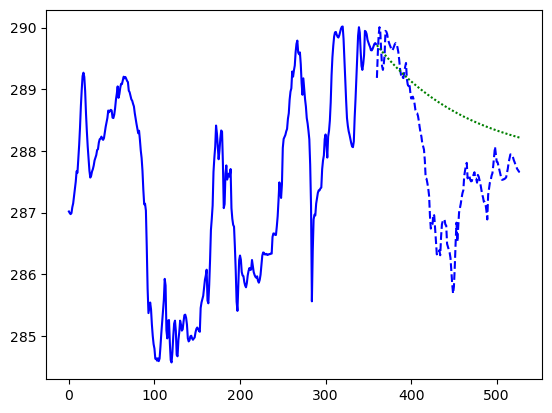

In [18]:
#forecast_1w(generate_eval_data(1).iloc[0], forecast, 'manual')
forecast_1w(generate_eval_data(1).iloc[0], AR1, 'manual')

In [19]:
def evaluator(function, n_samples = 100):
    errors = []
    df = generate_eval_data(n_samples)
    for index, row in df.iterrows():
        error = forecast_1w(row, function, operation = 'loop')
        errors.append(error)
    return np.mean(errors), row

In [20]:
evaluator(AR1, 1)


for lat in range(3400, 7150, 25):
    for lon in range(-2500, 3750, 25):
        print(lat / 100, ' ', lon / 100)
        df = generate_eval_data_non_rand(lat / 100, lon / 100)
        print(df.head())
        #error = forecast_1w(row, function, operation = 'loop')



34.0   -25.0
   latitude_deg  longitude_deg  start_date    end_date
0         -25.0           34.0  2023-05-01  2023-05-21
34.0   -24.75
   latitude_deg  longitude_deg  start_date    end_date
0        -24.75           34.0  2023-05-01  2023-05-21
34.0   -24.5
   latitude_deg  longitude_deg  start_date    end_date
0         -24.5           34.0  2023-05-01  2023-05-21
34.0   -24.25
   latitude_deg  longitude_deg  start_date    end_date
0        -24.25           34.0  2023-05-01  2023-05-21
34.0   -24.0
   latitude_deg  longitude_deg  start_date    end_date
0         -24.0           34.0  2023-05-01  2023-05-21
34.0   -23.75
   latitude_deg  longitude_deg  start_date    end_date
0        -23.75           34.0  2023-05-01  2023-05-21
34.0   -23.5
   latitude_deg  longitude_deg  start_date    end_date
0         -23.5           34.0  2023-05-01  2023-05-21
34.0   -23.25
   latitude_deg  longitude_deg  start_date    end_date
0        -23.25           34.0  2023-05-01  2023-05-21
34.0   -23.0

In [ ]:
%pip install geopandas cartopy shapely tqdm


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/338.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/338.4 kB ? eta -:--:--
   - -------------------------------------- 10.2/338.4 kB ? eta -:--:--
   ---- ---------------------------------- 41.0/338.4 kB 393.8 kB/s eta 0:00:01
   ---------------------------------------  337.9/338.4 kB 3.0 MB/s eta 0:00:01
   ---------------------------------------- 338.4/338.4 kB 2.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/19.2 MB ? eta -:--:--
   -- ------------------------------------- 1.0/19.2 MB 20.9 MB/s eta 0:00:01
   ---- ----------------------------------- 2.0/19.2 MB 20.7 MB/s eta 0:00:01
   ------ --------------------------------- 2.9/19.2 MB 20.5 MB/s eta 0:00:01
   ------ --------------------------------- 3.3/19.2 MB 21.1 MB/s eta 0:00:01
   ------- -------------------------------- 3.5/19.2 MB 14.7 MB/s eta 0:00:02
   -----

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box
from tqdm import tqdm  # geeft een voortgangsbalk


In [ ]:
results = []

for lat in range(3400, 7150, 25):      # 34.00°N tot 71.25°N
    for lon in range(-2500, 3750, 25): # 25.00°W tot 37.50°E
        lat_val = lat / 100
        lon_val = lon / 100
        print(f"Verwerken: lat={lat_val}, lon={lon_val}")

        # Maak kleine dataset voor dit punt
        df = generate_eval_data_non_rand(lon_val, lat_val)

        try:
            # Fout berekenen 
            error = forecast_1w(df.iloc[0], AR1)
            results.append({'latitude_deg': lat_val, 'longitude_deg': lon_val, 'error': error})
        except Exception as e:
            print(f"Fout bij lat={lat_val}, lon={lon_val}: {e}")
            results.append({'latitude_deg': lat_val, 'longitude_deg': lon_val, 'error': np.nan})

# Resultaten opslaan in een csv file
df_errors = pd.DataFrame(results)
df_errors.to_csv('error_map.csv', index=False)


# Hierna even ver naar beneden scrollen voor de visualisatie


Verwerken: lat=34.0, lon=-25.0
Verwerken: lat=34.0, lon=-24.75
Verwerken: lat=34.0, lon=-24.5
Verwerken: lat=34.0, lon=-24.25
Verwerken: lat=34.0, lon=-24.0
Verwerken: lat=34.0, lon=-23.75
Verwerken: lat=34.0, lon=-23.5
Verwerken: lat=34.0, lon=-23.25
Verwerken: lat=34.0, lon=-23.0
Verwerken: lat=34.0, lon=-22.75
Verwerken: lat=34.0, lon=-22.5
Verwerken: lat=34.0, lon=-22.25
Verwerken: lat=34.0, lon=-22.0
Verwerken: lat=34.0, lon=-21.75
Verwerken: lat=34.0, lon=-21.5
Verwerken: lat=34.0, lon=-21.25
Verwerken: lat=34.0, lon=-21.0
Verwerken: lat=34.0, lon=-20.75
Verwerken: lat=34.0, lon=-20.5
Verwerken: lat=34.0, lon=-20.25
Verwerken: lat=34.0, lon=-20.0
Verwerken: lat=34.0, lon=-19.75
Verwerken: lat=34.0, lon=-19.5
Verwerken: lat=34.0, lon=-19.25
Verwerken: lat=34.0, lon=-19.0
Verwerken: lat=34.0, lon=-18.75
Verwerken: lat=34.0, lon=-18.5
Verwerken: lat=34.0, lon=-18.25
Verwerken: lat=34.0, lon=-18.0
Verwerken: lat=34.0, lon=-17.75
Verwerken: lat=34.0, lon=-17.5
Verwerken: lat=34.0, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=34.0, lon=-15.75
Verwerken: lat=34.0, lon=-15.5
Verwerken: lat=34.0, lon=-15.25
Verwerken: lat=34.0, lon=-15.0
Verwerken: lat=34.0, lon=-14.75
Verwerken: lat=34.0, lon=-14.5
Verwerken: lat=34.0, lon=-14.25
Verwerken: lat=34.0, lon=-14.0
Verwerken: lat=34.0, lon=-13.75
Verwerken: lat=34.0, lon=-13.5
Verwerken: lat=34.0, lon=-13.25
Verwerken: lat=34.0, lon=-13.0
Verwerken: lat=34.0, lon=-12.75
Verwerken: lat=34.0, lon=-12.5
Verwerken: lat=34.0, lon=-12.25
Verwerken: lat=34.0, lon=-12.0
Verwerken: lat=34.0, lon=-11.75
Verwerken: lat=34.0, lon=-11.5


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=34.0, lon=-11.25
Verwerken: lat=34.0, lon=-11.0
Verwerken: lat=34.0, lon=-10.75
Verwerken: lat=34.0, lon=-10.5
Verwerken: lat=34.0, lon=-10.25
Verwerken: lat=34.0, lon=-10.0
Verwerken: lat=34.0, lon=-9.75
Verwerken: lat=34.0, lon=-9.5
Verwerken: lat=34.0, lon=-9.25
Verwerken: lat=34.0, lon=-9.0
Verwerken: lat=34.0, lon=-8.75
Verwerken: lat=34.0, lon=-8.5
Verwerken: lat=34.0, lon=-8.25
Verwerken: lat=34.0, lon=-8.0
Verwerken: lat=34.0, lon=-7.75
Verwerken: lat=34.0, lon=-7.5
Verwerken: lat=34.0, lon=-7.25
Verwerken: lat=34.0, lon=-7.0
Verwerken: lat=34.0, lon=-6.75
Verwerken: lat=34.0, lon=-6.5
Verwerken: lat=34.0, lon=-6.25
Verwerken: lat=34.0, lon=-6.0
Verwerken: lat=34.0, lon=-5.75
Verwerken: lat=34.0, lon=-5.5
Verwerken: lat=34.0, lon=-5.25
Verwerken: lat=34.0, lon=-5.0
Verwerken: lat=34.0, lon=-4.75
Verwerken: lat=34.0, lon=-4.5
Verwerken: lat=34.0, lon=-4.25
Verwerken: lat=34.0, lon=-4.0
Verwerken: lat=34.0, lon=-3.75
Verwerken: lat=34.0, lon=-3.5
Verwerken: lat=34.

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=34.0, lon=31.5
Verwerken: lat=34.0, lon=31.75
Verwerken: lat=34.0, lon=32.0
Verwerken: lat=34.0, lon=32.25
Verwerken: lat=34.0, lon=32.5
Verwerken: lat=34.0, lon=32.75
Verwerken: lat=34.0, lon=33.0
Verwerken: lat=34.0, lon=33.25
Verwerken: lat=34.0, lon=33.5
Verwerken: lat=34.0, lon=33.75
Verwerken: lat=34.0, lon=34.0
Verwerken: lat=34.0, lon=34.25
Verwerken: lat=34.0, lon=34.5
Verwerken: lat=34.0, lon=34.75
Verwerken: lat=34.0, lon=35.0
Verwerken: lat=34.0, lon=35.25
Verwerken: lat=34.0, lon=35.5
Verwerken: lat=34.0, lon=35.75
Verwerken: lat=34.0, lon=36.0
Verwerken: lat=34.0, lon=36.25
Verwerken: lat=34.0, lon=36.5
Verwerken: lat=34.0, lon=36.75
Verwerken: lat=34.0, lon=37.0
Verwerken: lat=34.0, lon=37.25
Verwerken: lat=34.25, lon=-25.0
Verwerken: lat=34.25, lon=-24.75
Verwerken: lat=34.25, lon=-24.5
Verwerken: lat=34.25, lon=-24.25
Verwerken: lat=34.25, lon=-24.0
Verwerken: lat=34.25, lon=-23.75
Verwerken: lat=34.25, lon=-23.5
Verwerken: lat=34.25, lon=-23.25
Verwerke

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=34.25, lon=30.0
Verwerken: lat=34.25, lon=30.25
Verwerken: lat=34.25, lon=30.5
Verwerken: lat=34.25, lon=30.75
Verwerken: lat=34.25, lon=31.0
Verwerken: lat=34.25, lon=31.25
Verwerken: lat=34.25, lon=31.5
Verwerken: lat=34.25, lon=31.75
Verwerken: lat=34.25, lon=32.0
Verwerken: lat=34.25, lon=32.25
Verwerken: lat=34.25, lon=32.5


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=34.25, lon=32.75
Verwerken: lat=34.25, lon=33.0
Verwerken: lat=34.25, lon=33.25
Verwerken: lat=34.25, lon=33.5
Verwerken: lat=34.25, lon=33.75
Verwerken: lat=34.25, lon=34.0
Verwerken: lat=34.25, lon=34.25
Verwerken: lat=34.25, lon=34.5
Verwerken: lat=34.25, lon=34.75
Verwerken: lat=34.25, lon=35.0
Verwerken: lat=34.25, lon=35.25
Verwerken: lat=34.25, lon=35.5
Verwerken: lat=34.25, lon=35.75
Verwerken: lat=34.25, lon=36.0
Verwerken: lat=34.25, lon=36.25
Verwerken: lat=34.25, lon=36.5
Verwerken: lat=34.25, lon=36.75
Verwerken: lat=34.25, lon=37.0
Verwerken: lat=34.25, lon=37.25
Verwerken: lat=34.5, lon=-25.0
Verwerken: lat=34.5, lon=-24.75
Verwerken: lat=34.5, lon=-24.5
Verwerken: lat=34.5, lon=-24.25
Verwerken: lat=34.5, lon=-24.0
Verwerken: lat=34.5, lon=-23.75
Verwerken: lat=34.5, lon=-23.5
Verwerken: lat=34.5, lon=-23.25
Verwerken: lat=34.5, lon=-23.0
Verwerken: lat=34.5, lon=-22.75
Verwerken: lat=34.5, lon=-22.5
Verwerken: lat=34.5, lon=-22.25
Verwerken: lat=34.5, lo

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=34.5, lon=-13.75
Verwerken: lat=34.5, lon=-13.5
Verwerken: lat=34.5, lon=-13.25
Verwerken: lat=34.5, lon=-13.0
Verwerken: lat=34.5, lon=-12.75
Verwerken: lat=34.5, lon=-12.5
Verwerken: lat=34.5, lon=-12.25
Verwerken: lat=34.5, lon=-12.0
Verwerken: lat=34.5, lon=-11.75
Verwerken: lat=34.5, lon=-11.5
Verwerken: lat=34.5, lon=-11.25
Verwerken: lat=34.5, lon=-11.0
Verwerken: lat=34.5, lon=-10.75
Verwerken: lat=34.5, lon=-10.5
Verwerken: lat=34.5, lon=-10.25
Verwerken: lat=34.5, lon=-10.0
Verwerken: lat=34.5, lon=-9.75
Verwerken: lat=34.5, lon=-9.5
Verwerken: lat=34.5, lon=-9.25
Verwerken: lat=34.5, lon=-9.0
Verwerken: lat=34.5, lon=-8.75
Verwerken: lat=34.5, lon=-8.5
Verwerken: lat=34.5, lon=-8.25
Verwerken: lat=34.5, lon=-8.0
Verwerken: lat=34.5, lon=-7.75
Verwerken: lat=34.5, lon=-7.5
Verwerken: lat=34.5, lon=-7.25
Verwerken: lat=34.5, lon=-7.0
Verwerken: lat=34.5, lon=-6.75
Verwerken: lat=34.5, lon=-6.5
Verwerken: lat=34.5, lon=-6.25
Verwerken: lat=34.5, lon=-6.0
Verwerke

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=34.5, lon=21.0
Verwerken: lat=34.5, lon=21.25
Verwerken: lat=34.5, lon=21.5
Verwerken: lat=34.5, lon=21.75
Verwerken: lat=34.5, lon=22.0
Verwerken: lat=34.5, lon=22.25
Verwerken: lat=34.5, lon=22.5
Verwerken: lat=34.5, lon=22.75
Verwerken: lat=34.5, lon=23.0
Verwerken: lat=34.5, lon=23.25
Verwerken: lat=34.5, lon=23.5
Verwerken: lat=34.5, lon=23.75
Verwerken: lat=34.5, lon=24.0
Verwerken: lat=34.5, lon=24.25
Verwerken: lat=34.5, lon=24.5
Verwerken: lat=34.5, lon=24.75
Verwerken: lat=34.5, lon=25.0
Verwerken: lat=34.5, lon=25.25
Verwerken: lat=34.5, lon=25.5
Verwerken: lat=34.5, lon=25.75
Verwerken: lat=34.5, lon=26.0
Verwerken: lat=34.5, lon=26.25
Verwerken: lat=34.5, lon=26.5
Verwerken: lat=34.5, lon=26.75
Verwerken: lat=34.5, lon=27.0
Verwerken: lat=34.5, lon=27.25
Verwerken: lat=34.5, lon=27.5
Verwerken: lat=34.5, lon=27.75
Verwerken: lat=34.5, lon=28.0


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=34.5, lon=28.25
Verwerken: lat=34.5, lon=28.5
Verwerken: lat=34.5, lon=28.75
Verwerken: lat=34.5, lon=29.0
Verwerken: lat=34.5, lon=29.25
Verwerken: lat=34.5, lon=29.5
Verwerken: lat=34.5, lon=29.75
Verwerken: lat=34.5, lon=30.0
Verwerken: lat=34.5, lon=30.25
Verwerken: lat=34.5, lon=30.5
Verwerken: lat=34.5, lon=30.75
Verwerken: lat=34.5, lon=31.0
Verwerken: lat=34.5, lon=31.25
Verwerken: lat=34.5, lon=31.5
Verwerken: lat=34.5, lon=31.75
Verwerken: lat=34.5, lon=32.0
Verwerken: lat=34.5, lon=32.25
Verwerken: lat=34.5, lon=32.5
Verwerken: lat=34.5, lon=32.75
Verwerken: lat=34.5, lon=33.0
Verwerken: lat=34.5, lon=33.25
Verwerken: lat=34.5, lon=33.5
Verwerken: lat=34.5, lon=33.75
Verwerken: lat=34.5, lon=34.0
Verwerken: lat=34.5, lon=34.25
Verwerken: lat=34.5, lon=34.5
Verwerken: lat=34.5, lon=34.75
Verwerken: lat=34.5, lon=35.0
Verwerken: lat=34.5, lon=35.25
Verwerken: lat=34.5, lon=35.5
Verwerken: lat=34.5, lon=35.75
Verwerken: lat=34.5, lon=36.0
Verwerken: lat=34.5, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=35.0, lon=-17.0
Verwerken: lat=35.0, lon=-16.75
Verwerken: lat=35.0, lon=-16.5
Verwerken: lat=35.0, lon=-16.25
Verwerken: lat=35.0, lon=-16.0
Verwerken: lat=35.0, lon=-15.75
Verwerken: lat=35.0, lon=-15.5
Verwerken: lat=35.0, lon=-15.25
Verwerken: lat=35.0, lon=-15.0
Verwerken: lat=35.0, lon=-14.75
Verwerken: lat=35.0, lon=-14.5
Verwerken: lat=35.0, lon=-14.25
Verwerken: lat=35.0, lon=-14.0
Verwerken: lat=35.0, lon=-13.75
Verwerken: lat=35.0, lon=-13.5
Verwerken: lat=35.0, lon=-13.25
Verwerken: lat=35.0, lon=-13.0
Verwerken: lat=35.0, lon=-12.75
Verwerken: lat=35.0, lon=-12.5
Verwerken: lat=35.0, lon=-12.25
Verwerken: lat=35.0, lon=-12.0
Verwerken: lat=35.0, lon=-11.75
Verwerken: lat=35.0, lon=-11.5


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=35.0, lon=-11.25
Verwerken: lat=35.0, lon=-11.0
Verwerken: lat=35.0, lon=-10.75
Verwerken: lat=35.0, lon=-10.5
Verwerken: lat=35.0, lon=-10.25
Verwerken: lat=35.0, lon=-10.0
Verwerken: lat=35.0, lon=-9.75
Verwerken: lat=35.0, lon=-9.5
Verwerken: lat=35.0, lon=-9.25
Verwerken: lat=35.0, lon=-9.0
Verwerken: lat=35.0, lon=-8.75
Verwerken: lat=35.0, lon=-8.5
Verwerken: lat=35.0, lon=-8.25
Verwerken: lat=35.0, lon=-8.0
Verwerken: lat=35.0, lon=-7.75
Verwerken: lat=35.0, lon=-7.5
Verwerken: lat=35.0, lon=-7.25
Verwerken: lat=35.0, lon=-7.0
Verwerken: lat=35.0, lon=-6.75
Verwerken: lat=35.0, lon=-6.5
Verwerken: lat=35.0, lon=-6.25
Verwerken: lat=35.0, lon=-6.0
Verwerken: lat=35.0, lon=-5.75
Verwerken: lat=35.0, lon=-5.5
Verwerken: lat=35.0, lon=-5.25
Verwerken: lat=35.0, lon=-5.0
Verwerken: lat=35.0, lon=-4.75
Verwerken: lat=35.0, lon=-4.5
Verwerken: lat=35.0, lon=-4.25
Verwerken: lat=35.0, lon=-4.0
Verwerken: lat=35.0, lon=-3.75
Verwerken: lat=35.0, lon=-3.5
Verwerken: lat=35.

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=35.0, lon=16.0
Verwerken: lat=35.0, lon=16.25
Verwerken: lat=35.0, lon=16.5
Verwerken: lat=35.0, lon=16.75


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=35.0, lon=17.0
Verwerken: lat=35.0, lon=17.25
Verwerken: lat=35.0, lon=17.5
Verwerken: lat=35.0, lon=17.75
Verwerken: lat=35.0, lon=18.0
Verwerken: lat=35.0, lon=18.25
Verwerken: lat=35.0, lon=18.5
Verwerken: lat=35.0, lon=18.75
Verwerken: lat=35.0, lon=19.0
Verwerken: lat=35.0, lon=19.25
Verwerken: lat=35.0, lon=19.5
Verwerken: lat=35.0, lon=19.75
Verwerken: lat=35.0, lon=20.0
Verwerken: lat=35.0, lon=20.25
Verwerken: lat=35.0, lon=20.5
Verwerken: lat=35.0, lon=20.75
Verwerken: lat=35.0, lon=21.0
Verwerken: lat=35.0, lon=21.25
Verwerken: lat=35.0, lon=21.5
Verwerken: lat=35.0, lon=21.75
Verwerken: lat=35.0, lon=22.0
Verwerken: lat=35.0, lon=22.25
Verwerken: lat=35.0, lon=22.5
Verwerken: lat=35.0, lon=22.75
Verwerken: lat=35.0, lon=23.0
Verwerken: lat=35.0, lon=23.25
Verwerken: lat=35.0, lon=23.5
Verwerken: lat=35.0, lon=23.75
Verwerken: lat=35.0, lon=24.0


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=35.0, lon=24.25
Verwerken: lat=35.0, lon=24.5
Verwerken: lat=35.0, lon=24.75
Verwerken: lat=35.0, lon=25.0
Verwerken: lat=35.0, lon=25.25
Verwerken: lat=35.0, lon=25.5
Verwerken: lat=35.0, lon=25.75
Verwerken: lat=35.0, lon=26.0
Verwerken: lat=35.0, lon=26.25
Verwerken: lat=35.0, lon=26.5
Verwerken: lat=35.0, lon=26.75
Verwerken: lat=35.0, lon=27.0
Verwerken: lat=35.0, lon=27.25
Verwerken: lat=35.0, lon=27.5
Verwerken: lat=35.0, lon=27.75
Verwerken: lat=35.0, lon=28.0
Verwerken: lat=35.0, lon=28.25
Verwerken: lat=35.0, lon=28.5
Verwerken: lat=35.0, lon=28.75
Verwerken: lat=35.0, lon=29.0
Verwerken: lat=35.0, lon=29.25
Verwerken: lat=35.0, lon=29.5
Verwerken: lat=35.0, lon=29.75
Verwerken: lat=35.0, lon=30.0
Verwerken: lat=35.0, lon=30.25
Verwerken: lat=35.0, lon=30.5
Verwerken: lat=35.0, lon=30.75
Verwerken: lat=35.0, lon=31.0
Verwerken: lat=35.0, lon=31.25
Verwerken: lat=35.0, lon=31.5
Verwerken: lat=35.0, lon=31.75
Verwerken: lat=35.0, lon=32.0
Verwerken: lat=35.0, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=35.25, lon=-22.25
Verwerken: lat=35.25, lon=-22.0
Verwerken: lat=35.25, lon=-21.75
Verwerken: lat=35.25, lon=-21.5
Verwerken: lat=35.25, lon=-21.25
Verwerken: lat=35.25, lon=-21.0
Verwerken: lat=35.25, lon=-20.75
Verwerken: lat=35.25, lon=-20.5
Verwerken: lat=35.25, lon=-20.25
Verwerken: lat=35.25, lon=-20.0
Verwerken: lat=35.25, lon=-19.75
Verwerken: lat=35.25, lon=-19.5
Verwerken: lat=35.25, lon=-19.25
Verwerken: lat=35.25, lon=-19.0
Verwerken: lat=35.25, lon=-18.75
Verwerken: lat=35.25, lon=-18.5
Verwerken: lat=35.25, lon=-18.25
Verwerken: lat=35.25, lon=-18.0
Verwerken: lat=35.25, lon=-17.75
Verwerken: lat=35.25, lon=-17.5
Verwerken: lat=35.25, lon=-17.25
Verwerken: lat=35.25, lon=-17.0
Verwerken: lat=35.25, lon=-16.75
Verwerken: lat=35.25, lon=-16.5
Verwerken: lat=35.25, lon=-16.25
Verwerken: lat=35.25, lon=-16.0
Verwerken: lat=35.25, lon=-15.75
Verwerken: lat=35.25, lon=-15.5
Verwerken: lat=35.25, lon=-15.25
Verwerken: lat=35.25, lon=-15.0
Verwerken: lat=35.25, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=35.25, lon=17.5
Verwerken: lat=35.25, lon=17.75
Verwerken: lat=35.25, lon=18.0
Verwerken: lat=35.25, lon=18.25
Verwerken: lat=35.25, lon=18.5
Verwerken: lat=35.25, lon=18.75
Verwerken: lat=35.25, lon=19.0
Verwerken: lat=35.25, lon=19.25
Verwerken: lat=35.25, lon=19.5
Verwerken: lat=35.25, lon=19.75
Verwerken: lat=35.25, lon=20.0
Verwerken: lat=35.25, lon=20.25
Verwerken: lat=35.25, lon=20.5
Verwerken: lat=35.25, lon=20.75
Verwerken: lat=35.25, lon=21.0
Verwerken: lat=35.25, lon=21.25
Verwerken: lat=35.25, lon=21.5
Verwerken: lat=35.25, lon=21.75
Verwerken: lat=35.25, lon=22.0
Verwerken: lat=35.25, lon=22.25
Verwerken: lat=35.25, lon=22.5
Verwerken: lat=35.25, lon=22.75
Verwerken: lat=35.25, lon=23.0
Verwerken: lat=35.25, lon=23.25
Verwerken: lat=35.25, lon=23.5
Verwerken: lat=35.25, lon=23.75
Verwerken: lat=35.25, lon=24.0
Verwerken: lat=35.25, lon=24.25
Verwerken: lat=35.25, lon=24.5
Verwerken: lat=35.25, lon=24.75
Verwerken: lat=35.25, lon=25.0
Verwerken: lat=35.25, lo

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=35.5, lon=-13.25
Verwerken: lat=35.5, lon=-13.0
Verwerken: lat=35.5, lon=-12.75
Verwerken: lat=35.5, lon=-12.5
Verwerken: lat=35.5, lon=-12.25
Verwerken: lat=35.5, lon=-12.0
Verwerken: lat=35.5, lon=-11.75
Verwerken: lat=35.5, lon=-11.5
Verwerken: lat=35.5, lon=-11.25
Verwerken: lat=35.5, lon=-11.0
Verwerken: lat=35.5, lon=-10.75
Verwerken: lat=35.5, lon=-10.5
Verwerken: lat=35.5, lon=-10.25
Verwerken: lat=35.5, lon=-10.0
Verwerken: lat=35.5, lon=-9.75
Verwerken: lat=35.5, lon=-9.5
Verwerken: lat=35.5, lon=-9.25
Verwerken: lat=35.5, lon=-9.0
Verwerken: lat=35.5, lon=-8.75
Verwerken: lat=35.5, lon=-8.5
Verwerken: lat=35.5, lon=-8.25
Verwerken: lat=35.5, lon=-8.0
Verwerken: lat=35.5, lon=-7.75
Verwerken: lat=35.5, lon=-7.5
Verwerken: lat=35.5, lon=-7.25
Verwerken: lat=35.5, lon=-7.0
Verwerken: lat=35.5, lon=-6.75
Verwerken: lat=35.5, lon=-6.5
Verwerken: lat=35.5, lon=-6.25
Verwerken: lat=35.5, lon=-6.0
Verwerken: lat=35.5, lon=-5.75
Verwerken: lat=35.5, lon=-5.5
Verwerken:

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



Verwerken: lat=35.75, lon=24.5
Verwerken: lat=35.75, lon=24.75
Verwerken: lat=35.75, lon=25.0
Verwerken: lat=35.75, lon=25.25
Verwerken: lat=35.75, lon=25.5
Verwerken: lat=35.75, lon=25.75
Verwerken: lat=35.75, lon=26.0
Verwerken: lat=35.75, lon=26.25
Verwerken: lat=35.75, lon=26.5
Verwerken: lat=35.75, lon=26.75
Verwerken: lat=35.75, lon=27.0
Verwerken: lat=35.75, lon=27.25
Verwerken: lat=35.75, lon=27.5
Verwerken: lat=35.75, lon=27.75
Verwerken: lat=35.75, lon=28.0
Verwerken: lat=35.75, lon=28.25
Verwerken: lat=35.75, lon=28.5
Verwerken: lat=35.75, lon=28.75
Verwerken: lat=35.75, lon=29.0
Verwerken: lat=35.75, lon=29.25
Verwerken: lat=35.75, lon=29.5
Verwerken: lat=35.75, lon=29.75
Verwerken: lat=35.75, lon=30.0
Verwerken: lat=35.75, lon=30.25
Verwerken: lat=35.75, lon=30.5
Verwerken: lat=35.75, lon=30.75
Verwerken: lat=35.75, lon=31.0
Verwerken: lat=35.75, lon=31.25
Verwerken: lat=35.75, lon=31.5
Verwerken: lat=35.75, lon=31.75
Verwerken: lat=35.75, lon=32.0
Verwerken: lat=35.75, lo

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=36.0, lon=-23.0
Verwerken: lat=36.0, lon=-22.75
Verwerken: lat=36.0, lon=-22.5
Verwerken: lat=36.0, lon=-22.25
Verwerken: lat=36.0, lon=-22.0
Verwerken: lat=36.0, lon=-21.75
Verwerken: lat=36.0, lon=-21.5
Verwerken: lat=36.0, lon=-21.25
Verwerken: lat=36.0, lon=-21.0
Verwerken: lat=36.0, lon=-20.75
Verwerken: lat=36.0, lon=-20.5
Verwerken: lat=36.0, lon=-20.25
Verwerken: lat=36.0, lon=-20.0
Verwerken: lat=36.0, lon=-19.75
Verwerken: lat=36.0, lon=-19.5
Verwerken: lat=36.0, lon=-19.25
Verwerken: lat=36.0, lon=-19.0
Verwerken: lat=36.0, lon=-18.75
Verwerken: lat=36.0, lon=-18.5
Verwerken: lat=36.0, lon=-18.25
Verwerken: lat=36.0, lon=-18.0
Verwerken: lat=36.0, lon=-17.75
Verwerken: lat=36.0, lon=-17.5
Verwerken: lat=36.0, lon=-17.25
Verwerken: lat=36.0, lon=-17.0
Verwerken: lat=36.0, lon=-16.75
Verwerken: lat=36.0, lon=-16.5
Verwerken: lat=36.0, lon=-16.25
Verwerken: lat=36.0, lon=-16.0
Verwerken: lat=36.0, lon=-15.75
Verwerken: lat=36.0, lon=-15.5
Verwerken: lat=36.0, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=36.5, lon=12.75
Verwerken: lat=36.5, lon=13.0
Verwerken: lat=36.5, lon=13.25
Verwerken: lat=36.5, lon=13.5
Verwerken: lat=36.5, lon=13.75
Verwerken: lat=36.5, lon=14.0
Verwerken: lat=36.5, lon=14.25
Verwerken: lat=36.5, lon=14.5
Verwerken: lat=36.5, lon=14.75
Verwerken: lat=36.5, lon=15.0
Verwerken: lat=36.5, lon=15.25
Verwerken: lat=36.5, lon=15.5
Verwerken: lat=36.5, lon=15.75
Verwerken: lat=36.5, lon=16.0
Verwerken: lat=36.5, lon=16.25
Verwerken: lat=36.5, lon=16.5
Verwerken: lat=36.5, lon=16.75
Verwerken: lat=36.5, lon=17.0
Verwerken: lat=36.5, lon=17.25
Verwerken: lat=36.5, lon=17.5
Verwerken: lat=36.5, lon=17.75
Verwerken: lat=36.5, lon=18.0
Verwerken: lat=36.5, lon=18.25
Verwerken: lat=36.5, lon=18.5


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=36.5, lon=18.75
Verwerken: lat=36.5, lon=19.0
Verwerken: lat=36.5, lon=19.25
Verwerken: lat=36.5, lon=19.5
Verwerken: lat=36.5, lon=19.75
Verwerken: lat=36.5, lon=20.0
Verwerken: lat=36.5, lon=20.25
Verwerken: lat=36.5, lon=20.5
Verwerken: lat=36.5, lon=20.75
Verwerken: lat=36.5, lon=21.0
Verwerken: lat=36.5, lon=21.25
Verwerken: lat=36.5, lon=21.5
Verwerken: lat=36.5, lon=21.75
Verwerken: lat=36.5, lon=22.0
Verwerken: lat=36.5, lon=22.25
Verwerken: lat=36.5, lon=22.5
Verwerken: lat=36.5, lon=22.75
Verwerken: lat=36.5, lon=23.0
Verwerken: lat=36.5, lon=23.25
Verwerken: lat=36.5, lon=23.5
Verwerken: lat=36.5, lon=23.75
Verwerken: lat=36.5, lon=24.0
Verwerken: lat=36.5, lon=24.25
Verwerken: lat=36.5, lon=24.5
Verwerken: lat=36.5, lon=24.75
Verwerken: lat=36.5, lon=25.0
Verwerken: lat=36.5, lon=25.25
Verwerken: lat=36.5, lon=25.5
Verwerken: lat=36.5, lon=25.75
Verwerken: lat=36.5, lon=26.0
Verwerken: lat=36.5, lon=26.25
Verwerken: lat=36.5, lon=26.5
Verwerken: lat=36.5, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=36.75, lon=-9.5
Verwerken: lat=36.75, lon=-9.25
Verwerken: lat=36.75, lon=-9.0
Verwerken: lat=36.75, lon=-8.75
Verwerken: lat=36.75, lon=-8.5
Verwerken: lat=36.75, lon=-8.25
Verwerken: lat=36.75, lon=-8.0
Verwerken: lat=36.75, lon=-7.75
Verwerken: lat=36.75, lon=-7.5
Verwerken: lat=36.75, lon=-7.25
Verwerken: lat=36.75, lon=-7.0
Verwerken: lat=36.75, lon=-6.75
Verwerken: lat=36.75, lon=-6.5
Verwerken: lat=36.75, lon=-6.25
Verwerken: lat=36.75, lon=-6.0
Verwerken: lat=36.75, lon=-5.75
Verwerken: lat=36.75, lon=-5.5
Verwerken: lat=36.75, lon=-5.25
Verwerken: lat=36.75, lon=-5.0
Verwerken: lat=36.75, lon=-4.75
Verwerken: lat=36.75, lon=-4.5
Verwerken: lat=36.75, lon=-4.25
Verwerken: lat=36.75, lon=-4.0
Verwerken: lat=36.75, lon=-3.75
Verwerken: lat=36.75, lon=-3.5
Verwerken: lat=36.75, lon=-3.25
Verwerken: lat=36.75, lon=-3.0
Verwerken: lat=36.75, lon=-2.75
Verwerken: lat=36.75, lon=-2.5
Verwerken: lat=36.75, lon=-2.25
Verwerken: lat=36.75, lon=-2.0
Verwerken: lat=36.75, lo

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=37.25, lon=-10.25


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=37.25, lon=-10.0
Verwerken: lat=37.25, lon=-9.75
Verwerken: lat=37.25, lon=-9.5
Verwerken: lat=37.25, lon=-9.25
Verwerken: lat=37.25, lon=-9.0
Verwerken: lat=37.25, lon=-8.75
Verwerken: lat=37.25, lon=-8.5
Verwerken: lat=37.25, lon=-8.25
Verwerken: lat=37.25, lon=-8.0
Verwerken: lat=37.25, lon=-7.75
Verwerken: lat=37.25, lon=-7.5
Verwerken: lat=37.25, lon=-7.25
Verwerken: lat=37.25, lon=-7.0
Verwerken: lat=37.25, lon=-6.75
Verwerken: lat=37.25, lon=-6.5
Verwerken: lat=37.25, lon=-6.25
Verwerken: lat=37.25, lon=-6.0
Verwerken: lat=37.25, lon=-5.75
Verwerken: lat=37.25, lon=-5.5
Verwerken: lat=37.25, lon=-5.25
Verwerken: lat=37.25, lon=-5.0
Verwerken: lat=37.25, lon=-4.75
Verwerken: lat=37.25, lon=-4.5
Verwerken: lat=37.25, lon=-4.25
Verwerken: lat=37.25, lon=-4.0
Verwerken: lat=37.25, lon=-3.75
Verwerken: lat=37.25, lon=-3.5
Verwerken: lat=37.25, lon=-3.25
Verwerken: lat=37.25, lon=-3.0
Verwerken: lat=37.25, lon=-2.75
Verwerken: lat=37.25, lon=-2.5
Verwerken: lat=37.25, l

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=37.25, lon=5.75
Verwerken: lat=37.25, lon=6.0
Verwerken: lat=37.25, lon=6.25
Verwerken: lat=37.25, lon=6.5
Verwerken: lat=37.25, lon=6.75
Verwerken: lat=37.25, lon=7.0
Verwerken: lat=37.25, lon=7.25
Verwerken: lat=37.25, lon=7.5
Verwerken: lat=37.25, lon=7.75
Verwerken: lat=37.25, lon=8.0
Verwerken: lat=37.25, lon=8.25
Verwerken: lat=37.25, lon=8.5
Verwerken: lat=37.25, lon=8.75
Verwerken: lat=37.25, lon=9.0
Verwerken: lat=37.25, lon=9.25
Verwerken: lat=37.25, lon=9.5
Verwerken: lat=37.25, lon=9.75
Verwerken: lat=37.25, lon=10.0
Verwerken: lat=37.25, lon=10.25
Verwerken: lat=37.25, lon=10.5
Verwerken: lat=37.25, lon=10.75
Verwerken: lat=37.25, lon=11.0
Verwerken: lat=37.25, lon=11.25
Verwerken: lat=37.25, lon=11.5
Verwerken: lat=37.25, lon=11.75
Verwerken: lat=37.25, lon=12.0
Verwerken: lat=37.25, lon=12.25
Verwerken: lat=37.25, lon=12.5
Verwerken: lat=37.25, lon=12.75
Verwerken: lat=37.25, lon=13.0
Verwerken: lat=37.25, lon=13.25
Verwerken: lat=37.25, lon=13.5
Verwerken

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=37.5, lon=-21.0
Verwerken: lat=37.5, lon=-20.75
Verwerken: lat=37.5, lon=-20.5
Verwerken: lat=37.5, lon=-20.25
Verwerken: lat=37.5, lon=-20.0
Verwerken: lat=37.5, lon=-19.75
Verwerken: lat=37.5, lon=-19.5
Verwerken: lat=37.5, lon=-19.25
Verwerken: lat=37.5, lon=-19.0
Verwerken: lat=37.5, lon=-18.75
Verwerken: lat=37.5, lon=-18.5
Verwerken: lat=37.5, lon=-18.25
Verwerken: lat=37.5, lon=-18.0
Verwerken: lat=37.5, lon=-17.75
Verwerken: lat=37.5, lon=-17.5
Verwerken: lat=37.5, lon=-17.25
Verwerken: lat=37.5, lon=-17.0
Verwerken: lat=37.5, lon=-16.75
Verwerken: lat=37.5, lon=-16.5
Verwerken: lat=37.5, lon=-16.25
Verwerken: lat=37.5, lon=-16.0
Verwerken: lat=37.5, lon=-15.75
Verwerken: lat=37.5, lon=-15.5
Verwerken: lat=37.5, lon=-15.25
Verwerken: lat=37.5, lon=-15.0
Verwerken: lat=37.5, lon=-14.75
Verwerken: lat=37.5, lon=-14.5
Verwerken: lat=37.5, lon=-14.25
Verwerken: lat=37.5, lon=-14.0
Verwerken: lat=37.5, lon=-13.75
Verwerken: lat=37.5, lon=-13.5
Verwerken: lat=37.5, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=37.5, lon=4.25
Verwerken: lat=37.5, lon=4.5
Verwerken: lat=37.5, lon=4.75
Verwerken: lat=37.5, lon=5.0
Verwerken: lat=37.5, lon=5.25
Verwerken: lat=37.5, lon=5.5
Verwerken: lat=37.5, lon=5.75
Verwerken: lat=37.5, lon=6.0
Verwerken: lat=37.5, lon=6.25
Verwerken: lat=37.5, lon=6.5
Verwerken: lat=37.5, lon=6.75
Verwerken: lat=37.5, lon=7.0
Verwerken: lat=37.5, lon=7.25
Verwerken: lat=37.5, lon=7.5
Verwerken: lat=37.5, lon=7.75
Verwerken: lat=37.5, lon=8.0
Verwerken: lat=37.5, lon=8.25
Verwerken: lat=37.5, lon=8.5
Verwerken: lat=37.5, lon=8.75
Verwerken: lat=37.5, lon=9.0
Verwerken: lat=37.5, lon=9.25
Verwerken: lat=37.5, lon=9.5
Verwerken: lat=37.5, lon=9.75
Verwerken: lat=37.5, lon=10.0
Verwerken: lat=37.5, lon=10.25
Verwerken: lat=37.5, lon=10.5
Verwerken: lat=37.5, lon=10.75
Verwerken: lat=37.5, lon=11.0
Verwerken: lat=37.5, lon=11.25
Verwerken: lat=37.5, lon=11.5
Verwerken: lat=37.5, lon=11.75
Verwerken: lat=37.5, lon=12.0
Verwerken: lat=37.5, lon=12.25
Verwerken: lat=3

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=37.75, lon=11.0
Verwerken: lat=37.75, lon=11.25
Verwerken: lat=37.75, lon=11.5
Verwerken: lat=37.75, lon=11.75
Verwerken: lat=37.75, lon=12.0
Verwerken: lat=37.75, lon=12.25
Verwerken: lat=37.75, lon=12.5
Verwerken: lat=37.75, lon=12.75
Verwerken: lat=37.75, lon=13.0
Verwerken: lat=37.75, lon=13.25
Verwerken: lat=37.75, lon=13.5
Verwerken: lat=37.75, lon=13.75
Verwerken: lat=37.75, lon=14.0
Verwerken: lat=37.75, lon=14.25
Verwerken: lat=37.75, lon=14.5
Verwerken: lat=37.75, lon=14.75
Verwerken: lat=37.75, lon=15.0
Verwerken: lat=37.75, lon=15.25
Verwerken: lat=37.75, lon=15.5
Verwerken: lat=37.75, lon=15.75
Verwerken: lat=37.75, lon=16.0
Verwerken: lat=37.75, lon=16.25
Verwerken: lat=37.75, lon=16.5
Verwerken: lat=37.75, lon=16.75
Verwerken: lat=37.75, lon=17.0
Verwerken: lat=37.75, lon=17.25
Verwerken: lat=37.75, lon=17.5
Verwerken: lat=37.75, lon=17.75
Verwerken: lat=37.75, lon=18.0
Verwerken: lat=37.75, lon=18.25
Verwerken: lat=37.75, lon=18.5
Verwerken: lat=37.75, lo

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=38.0, lon=-16.75
Verwerken: lat=38.0, lon=-16.5
Verwerken: lat=38.0, lon=-16.25
Verwerken: lat=38.0, lon=-16.0
Verwerken: lat=38.0, lon=-15.75
Verwerken: lat=38.0, lon=-15.5
Verwerken: lat=38.0, lon=-15.25
Verwerken: lat=38.0, lon=-15.0
Verwerken: lat=38.0, lon=-14.75
Verwerken: lat=38.0, lon=-14.5
Verwerken: lat=38.0, lon=-14.25
Verwerken: lat=38.0, lon=-14.0
Verwerken: lat=38.0, lon=-13.75
Verwerken: lat=38.0, lon=-13.5
Verwerken: lat=38.0, lon=-13.25
Verwerken: lat=38.0, lon=-13.0
Verwerken: lat=38.0, lon=-12.75
Verwerken: lat=38.0, lon=-12.5
Verwerken: lat=38.0, lon=-12.25
Verwerken: lat=38.0, lon=-12.0
Verwerken: lat=38.0, lon=-11.75
Verwerken: lat=38.0, lon=-11.5
Verwerken: lat=38.0, lon=-11.25


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=38.0, lon=-11.0
Verwerken: lat=38.0, lon=-10.75
Verwerken: lat=38.0, lon=-10.5
Verwerken: lat=38.0, lon=-10.25
Verwerken: lat=38.0, lon=-10.0
Verwerken: lat=38.0, lon=-9.75
Verwerken: lat=38.0, lon=-9.5
Verwerken: lat=38.0, lon=-9.25
Verwerken: lat=38.0, lon=-9.0
Verwerken: lat=38.0, lon=-8.75
Verwerken: lat=38.0, lon=-8.5
Verwerken: lat=38.0, lon=-8.25
Verwerken: lat=38.0, lon=-8.0
Verwerken: lat=38.0, lon=-7.75
Verwerken: lat=38.0, lon=-7.5
Verwerken: lat=38.0, lon=-7.25
Verwerken: lat=38.0, lon=-7.0
Verwerken: lat=38.0, lon=-6.75
Verwerken: lat=38.0, lon=-6.5
Verwerken: lat=38.0, lon=-6.25
Verwerken: lat=38.0, lon=-6.0
Verwerken: lat=38.0, lon=-5.75
Verwerken: lat=38.0, lon=-5.5
Verwerken: lat=38.0, lon=-5.25
Verwerken: lat=38.0, lon=-5.0
Verwerken: lat=38.0, lon=-4.75
Verwerken: lat=38.0, lon=-4.5
Verwerken: lat=38.0, lon=-4.25
Verwerken: lat=38.0, lon=-4.0
Verwerken: lat=38.0, lon=-3.75
Verwerken: lat=38.0, lon=-3.5
Verwerken: lat=38.0, lon=-3.25
Verwerken: lat=38.0

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=38.25, lon=-11.75
Verwerken: lat=38.25, lon=-11.5
Verwerken: lat=38.25, lon=-11.25
Verwerken: lat=38.25, lon=-11.0
Verwerken: lat=38.25, lon=-10.75
Verwerken: lat=38.25, lon=-10.5
Verwerken: lat=38.25, lon=-10.25
Verwerken: lat=38.25, lon=-10.0
Verwerken: lat=38.25, lon=-9.75
Verwerken: lat=38.25, lon=-9.5
Verwerken: lat=38.25, lon=-9.25
Verwerken: lat=38.25, lon=-9.0
Verwerken: lat=38.25, lon=-8.75
Verwerken: lat=38.25, lon=-8.5
Verwerken: lat=38.25, lon=-8.25
Verwerken: lat=38.25, lon=-8.0
Verwerken: lat=38.25, lon=-7.75
Verwerken: lat=38.25, lon=-7.5
Verwerken: lat=38.25, lon=-7.25
Verwerken: lat=38.25, lon=-7.0
Verwerken: lat=38.25, lon=-6.75
Verwerken: lat=38.25, lon=-6.5
Verwerken: lat=38.25, lon=-6.25
Verwerken: lat=38.25, lon=-6.0
Verwerken: lat=38.25, lon=-5.75
Verwerken: lat=38.25, lon=-5.5
Verwerken: lat=38.25, lon=-5.25
Verwerken: lat=38.25, lon=-5.0
Verwerken: lat=38.25, lon=-4.75
Verwerken: lat=38.25, lon=-4.5
Verwerken: lat=38.25, lon=-4.25
Verwerken: lat=

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=38.25, lon=1.5
Verwerken: lat=38.25, lon=1.75
Verwerken: lat=38.25, lon=2.0
Verwerken: lat=38.25, lon=2.25
Verwerken: lat=38.25, lon=2.5
Verwerken: lat=38.25, lon=2.75
Verwerken: lat=38.25, lon=3.0
Verwerken: lat=38.25, lon=3.25
Verwerken: lat=38.25, lon=3.5
Verwerken: lat=38.25, lon=3.75
Verwerken: lat=38.25, lon=4.0
Verwerken: lat=38.25, lon=4.25
Verwerken: lat=38.25, lon=4.5
Verwerken: lat=38.25, lon=4.75
Verwerken: lat=38.25, lon=5.0
Verwerken: lat=38.25, lon=5.25
Verwerken: lat=38.25, lon=5.5
Verwerken: lat=38.25, lon=5.75
Verwerken: lat=38.25, lon=6.0
Verwerken: lat=38.25, lon=6.25
Verwerken: lat=38.25, lon=6.5
Verwerken: lat=38.25, lon=6.75
Verwerken: lat=38.25, lon=7.0
Verwerken: lat=38.25, lon=7.25
Verwerken: lat=38.25, lon=7.5
Verwerken: lat=38.25, lon=7.75
Verwerken: lat=38.25, lon=8.0
Verwerken: lat=38.25, lon=8.25
Verwerken: lat=38.25, lon=8.5
Verwerken: lat=38.25, lon=8.75
Verwerken: lat=38.25, lon=9.0
Verwerken: lat=38.25, lon=9.25
Verwerken: lat=38.25, lo

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=38.25, lon=13.0
Verwerken: lat=38.25, lon=13.25
Verwerken: lat=38.25, lon=13.5
Verwerken: lat=38.25, lon=13.75
Verwerken: lat=38.25, lon=14.0
Verwerken: lat=38.25, lon=14.25
Verwerken: lat=38.25, lon=14.5
Verwerken: lat=38.25, lon=14.75
Verwerken: lat=38.25, lon=15.0
Verwerken: lat=38.25, lon=15.25
Verwerken: lat=38.25, lon=15.5
Verwerken: lat=38.25, lon=15.75
Verwerken: lat=38.25, lon=16.0
Verwerken: lat=38.25, lon=16.25
Verwerken: lat=38.25, lon=16.5
Verwerken: lat=38.25, lon=16.75
Verwerken: lat=38.25, lon=17.0
Verwerken: lat=38.25, lon=17.25
Verwerken: lat=38.25, lon=17.5
Verwerken: lat=38.25, lon=17.75
Verwerken: lat=38.25, lon=18.0
Verwerken: lat=38.25, lon=18.25
Verwerken: lat=38.25, lon=18.5
Verwerken: lat=38.25, lon=18.75
Verwerken: lat=38.25, lon=19.0
Verwerken: lat=38.25, lon=19.25
Verwerken: lat=38.25, lon=19.5
Verwerken: lat=38.25, lon=19.75
Verwerken: lat=38.25, lon=20.0
Verwerken: lat=38.25, lon=20.25
Verwerken: lat=38.25, lon=20.5
Verwerken: lat=38.25, lo

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=38.5, lon=-11.25
Verwerken: lat=38.5, lon=-11.0
Verwerken: lat=38.5, lon=-10.75
Verwerken: lat=38.5, lon=-10.5
Verwerken: lat=38.5, lon=-10.25
Verwerken: lat=38.5, lon=-10.0
Verwerken: lat=38.5, lon=-9.75
Verwerken: lat=38.5, lon=-9.5
Verwerken: lat=38.5, lon=-9.25
Verwerken: lat=38.5, lon=-9.0
Verwerken: lat=38.5, lon=-8.75
Verwerken: lat=38.5, lon=-8.5
Verwerken: lat=38.5, lon=-8.25
Verwerken: lat=38.5, lon=-8.0
Verwerken: lat=38.5, lon=-7.75
Verwerken: lat=38.5, lon=-7.5
Verwerken: lat=38.5, lon=-7.25
Verwerken: lat=38.5, lon=-7.0
Verwerken: lat=38.5, lon=-6.75
Verwerken: lat=38.5, lon=-6.5
Verwerken: lat=38.5, lon=-6.25
Verwerken: lat=38.5, lon=-6.0
Verwerken: lat=38.5, lon=-5.75
Verwerken: lat=38.5, lon=-5.5
Verwerken: lat=38.5, lon=-5.25
Verwerken: lat=38.5, lon=-5.0
Verwerken: lat=38.5, lon=-4.75
Verwerken: lat=38.5, lon=-4.5
Verwerken: lat=38.5, lon=-4.25
Verwerken: lat=38.5, lon=-4.0
Verwerken: lat=38.5, lon=-3.75
Verwerken: lat=38.5, lon=-3.5
Verwerken: lat=38.

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=39.5, lon=-16.75
Verwerken: lat=39.5, lon=-16.5
Verwerken: lat=39.5, lon=-16.25
Verwerken: lat=39.5, lon=-16.0
Verwerken: lat=39.5, lon=-15.75
Verwerken: lat=39.5, lon=-15.5
Verwerken: lat=39.5, lon=-15.25
Verwerken: lat=39.5, lon=-15.0
Verwerken: lat=39.5, lon=-14.75
Verwerken: lat=39.5, lon=-14.5
Verwerken: lat=39.5, lon=-14.25
Verwerken: lat=39.5, lon=-14.0
Verwerken: lat=39.5, lon=-13.75
Verwerken: lat=39.5, lon=-13.5
Verwerken: lat=39.5, lon=-13.25
Verwerken: lat=39.5, lon=-13.0
Verwerken: lat=39.5, lon=-12.75
Verwerken: lat=39.5, lon=-12.5
Verwerken: lat=39.5, lon=-12.25
Verwerken: lat=39.5, lon=-12.0
Verwerken: lat=39.5, lon=-11.75
Verwerken: lat=39.5, lon=-11.5
Verwerken: lat=39.5, lon=-11.25
Verwerken: lat=39.5, lon=-11.0
Verwerken: lat=39.5, lon=-10.75
Verwerken: lat=39.5, lon=-10.5
Verwerken: lat=39.5, lon=-10.25
Verwerken: lat=39.5, lon=-10.0
Verwerken: lat=39.5, lon=-9.75
Verwerken: lat=39.5, lon=-9.5
Verwerken: lat=39.5, lon=-9.25
Verwerken: lat=39.5, lon=-

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=39.5, lon=18.5
Verwerken: lat=39.5, lon=18.75
Verwerken: lat=39.5, lon=19.0
Verwerken: lat=39.5, lon=19.25
Verwerken: lat=39.5, lon=19.5
Verwerken: lat=39.5, lon=19.75
Verwerken: lat=39.5, lon=20.0
Verwerken: lat=39.5, lon=20.25
Verwerken: lat=39.5, lon=20.5
Verwerken: lat=39.5, lon=20.75
Verwerken: lat=39.5, lon=21.0
Verwerken: lat=39.5, lon=21.25
Verwerken: lat=39.5, lon=21.5
Verwerken: lat=39.5, lon=21.75
Verwerken: lat=39.5, lon=22.0
Verwerken: lat=39.5, lon=22.25
Verwerken: lat=39.5, lon=22.5
Verwerken: lat=39.5, lon=22.75
Verwerken: lat=39.5, lon=23.0
Verwerken: lat=39.5, lon=23.25
Verwerken: lat=39.5, lon=23.5
Verwerken: lat=39.5, lon=23.75
Verwerken: lat=39.5, lon=24.0
Verwerken: lat=39.5, lon=24.25
Verwerken: lat=39.5, lon=24.5
Verwerken: lat=39.5, lon=24.75
Verwerken: lat=39.5, lon=25.0
Verwerken: lat=39.5, lon=25.25
Verwerken: lat=39.5, lon=25.5
Verwerken: lat=39.5, lon=25.75
Verwerken: lat=39.5, lon=26.0
Verwerken: lat=39.5, lon=26.25
Verwerken: lat=39.5, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=39.75, lon=-23.75
Verwerken: lat=39.75, lon=-23.5
Verwerken: lat=39.75, lon=-23.25
Verwerken: lat=39.75, lon=-23.0
Verwerken: lat=39.75, lon=-22.75
Verwerken: lat=39.75, lon=-22.5
Verwerken: lat=39.75, lon=-22.25
Verwerken: lat=39.75, lon=-22.0
Verwerken: lat=39.75, lon=-21.75
Verwerken: lat=39.75, lon=-21.5
Verwerken: lat=39.75, lon=-21.25
Verwerken: lat=39.75, lon=-21.0
Verwerken: lat=39.75, lon=-20.75
Verwerken: lat=39.75, lon=-20.5
Verwerken: lat=39.75, lon=-20.25
Verwerken: lat=39.75, lon=-20.0
Verwerken: lat=39.75, lon=-19.75
Verwerken: lat=39.75, lon=-19.5
Verwerken: lat=39.75, lon=-19.25
Verwerken: lat=39.75, lon=-19.0
Verwerken: lat=39.75, lon=-18.75
Verwerken: lat=39.75, lon=-18.5
Verwerken: lat=39.75, lon=-18.25
Verwerken: lat=39.75, lon=-18.0
Verwerken: lat=39.75, lon=-17.75
Verwerken: lat=39.75, lon=-17.5
Verwerken: lat=39.75, lon=-17.25
Verwerken: lat=39.75, lon=-17.0
Verwerken: lat=39.75, lon=-16.75
Verwerken: lat=39.75, lon=-16.5
Verwerken: lat=39.75, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=39.75, lon=-14.0
Verwerken: lat=39.75, lon=-13.75
Verwerken: lat=39.75, lon=-13.5
Verwerken: lat=39.75, lon=-13.25
Verwerken: lat=39.75, lon=-13.0
Verwerken: lat=39.75, lon=-12.75
Verwerken: lat=39.75, lon=-12.5
Verwerken: lat=39.75, lon=-12.25
Verwerken: lat=39.75, lon=-12.0
Verwerken: lat=39.75, lon=-11.75
Verwerken: lat=39.75, lon=-11.5
Verwerken: lat=39.75, lon=-11.25
Verwerken: lat=39.75, lon=-11.0
Verwerken: lat=39.75, lon=-10.75
Verwerken: lat=39.75, lon=-10.5
Verwerken: lat=39.75, lon=-10.25
Verwerken: lat=39.75, lon=-10.0
Verwerken: lat=39.75, lon=-9.75
Verwerken: lat=39.75, lon=-9.5
Verwerken: lat=39.75, lon=-9.25
Verwerken: lat=39.75, lon=-9.0
Verwerken: lat=39.75, lon=-8.75
Verwerken: lat=39.75, lon=-8.5
Verwerken: lat=39.75, lon=-8.25
Verwerken: lat=39.75, lon=-8.0
Verwerken: lat=39.75, lon=-7.75
Verwerken: lat=39.75, lon=-7.5
Verwerken: lat=39.75, lon=-7.25
Verwerken: lat=39.75, lon=-7.0
Verwerken: lat=39.75, lon=-6.75
Verwerken: lat=39.75, lon=-6.5
Verwerk

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=40.0, lon=-10.75
Verwerken: lat=40.0, lon=-10.5


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=40.0, lon=-10.25
Verwerken: lat=40.0, lon=-10.0
Verwerken: lat=40.0, lon=-9.75
Verwerken: lat=40.0, lon=-9.5
Verwerken: lat=40.0, lon=-9.25
Verwerken: lat=40.0, lon=-9.0
Verwerken: lat=40.0, lon=-8.75
Verwerken: lat=40.0, lon=-8.5
Verwerken: lat=40.0, lon=-8.25
Verwerken: lat=40.0, lon=-8.0
Verwerken: lat=40.0, lon=-7.75
Verwerken: lat=40.0, lon=-7.5
Verwerken: lat=40.0, lon=-7.25
Verwerken: lat=40.0, lon=-7.0
Verwerken: lat=40.0, lon=-6.75
Verwerken: lat=40.0, lon=-6.5
Verwerken: lat=40.0, lon=-6.25
Verwerken: lat=40.0, lon=-6.0
Verwerken: lat=40.0, lon=-5.75
Verwerken: lat=40.0, lon=-5.5
Verwerken: lat=40.0, lon=-5.25
Verwerken: lat=40.0, lon=-5.0
Verwerken: lat=40.0, lon=-4.75
Verwerken: lat=40.0, lon=-4.5
Verwerken: lat=40.0, lon=-4.25
Verwerken: lat=40.0, lon=-4.0
Verwerken: lat=40.0, lon=-3.75
Verwerken: lat=40.0, lon=-3.5
Verwerken: lat=40.0, lon=-3.25
Verwerken: lat=40.0, lon=-3.0
Verwerken: lat=40.0, lon=-2.75
Verwerken: lat=40.0, lon=-2.5
Verwerken: lat=40.0, l

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=40.25, lon=-14.5
Verwerken: lat=40.25, lon=-14.25
Verwerken: lat=40.25, lon=-14.0
Verwerken: lat=40.25, lon=-13.75
Verwerken: lat=40.25, lon=-13.5
Verwerken: lat=40.25, lon=-13.25
Verwerken: lat=40.25, lon=-13.0
Verwerken: lat=40.25, lon=-12.75
Verwerken: lat=40.25, lon=-12.5
Verwerken: lat=40.25, lon=-12.25


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=40.25, lon=-12.0
Verwerken: lat=40.25, lon=-11.75
Verwerken: lat=40.25, lon=-11.5
Verwerken: lat=40.25, lon=-11.25
Verwerken: lat=40.25, lon=-11.0
Verwerken: lat=40.25, lon=-10.75


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=40.25, lon=-10.5
Verwerken: lat=40.25, lon=-10.25
Verwerken: lat=40.25, lon=-10.0
Verwerken: lat=40.25, lon=-9.75
Verwerken: lat=40.25, lon=-9.5
Verwerken: lat=40.25, lon=-9.25
Verwerken: lat=40.25, lon=-9.0
Verwerken: lat=40.25, lon=-8.75
Verwerken: lat=40.25, lon=-8.5
Verwerken: lat=40.25, lon=-8.25
Verwerken: lat=40.25, lon=-8.0
Verwerken: lat=40.25, lon=-7.75
Verwerken: lat=40.25, lon=-7.5
Verwerken: lat=40.25, lon=-7.25
Verwerken: lat=40.25, lon=-7.0
Verwerken: lat=40.25, lon=-6.75
Verwerken: lat=40.25, lon=-6.5
Verwerken: lat=40.25, lon=-6.25
Verwerken: lat=40.25, lon=-6.0
Verwerken: lat=40.25, lon=-5.75
Verwerken: lat=40.25, lon=-5.5
Verwerken: lat=40.25, lon=-5.25
Verwerken: lat=40.25, lon=-5.0
Verwerken: lat=40.25, lon=-4.75
Verwerken: lat=40.25, lon=-4.5
Verwerken: lat=40.25, lon=-4.25
Verwerken: lat=40.25, lon=-4.0
Verwerken: lat=40.25, lon=-3.75
Verwerken: lat=40.25, lon=-3.5
Verwerken: lat=40.25, lon=-3.25
Verwerken: lat=40.25, lon=-3.0
Verwerken: lat=40.25,

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=40.25, lon=1.5
Verwerken: lat=40.25, lon=1.75
Verwerken: lat=40.25, lon=2.0
Verwerken: lat=40.25, lon=2.25
Verwerken: lat=40.25, lon=2.5
Verwerken: lat=40.25, lon=2.75
Verwerken: lat=40.25, lon=3.0
Verwerken: lat=40.25, lon=3.25
Verwerken: lat=40.25, lon=3.5
Verwerken: lat=40.25, lon=3.75
Verwerken: lat=40.25, lon=4.0
Verwerken: lat=40.25, lon=4.25
Verwerken: lat=40.25, lon=4.5
Verwerken: lat=40.25, lon=4.75
Verwerken: lat=40.25, lon=5.0
Verwerken: lat=40.25, lon=5.25
Verwerken: lat=40.25, lon=5.5
Verwerken: lat=40.25, lon=5.75
Verwerken: lat=40.25, lon=6.0
Verwerken: lat=40.25, lon=6.25
Verwerken: lat=40.25, lon=6.5
Verwerken: lat=40.25, lon=6.75
Verwerken: lat=40.25, lon=7.0
Verwerken: lat=40.25, lon=7.25
Verwerken: lat=40.25, lon=7.5
Verwerken: lat=40.25, lon=7.75
Verwerken: lat=40.25, lon=8.0
Verwerken: lat=40.25, lon=8.25
Verwerken: lat=40.25, lon=8.5
Verwerken: lat=40.25, lon=8.75
Verwerken: lat=40.25, lon=9.0
Verwerken: lat=40.25, lon=9.25
Verwerken: lat=40.25, lo

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=40.5, lon=6.0
Verwerken: lat=40.5, lon=6.25
Verwerken: lat=40.5, lon=6.5
Verwerken: lat=40.5, lon=6.75
Verwerken: lat=40.5, lon=7.0
Verwerken: lat=40.5, lon=7.25
Verwerken: lat=40.5, lon=7.5
Verwerken: lat=40.5, lon=7.75
Verwerken: lat=40.5, lon=8.0
Verwerken: lat=40.5, lon=8.25
Verwerken: lat=40.5, lon=8.5
Verwerken: lat=40.5, lon=8.75
Verwerken: lat=40.5, lon=9.0
Verwerken: lat=40.5, lon=9.25
Verwerken: lat=40.5, lon=9.5
Verwerken: lat=40.5, lon=9.75
Verwerken: lat=40.5, lon=10.0
Verwerken: lat=40.5, lon=10.25
Verwerken: lat=40.5, lon=10.5
Verwerken: lat=40.5, lon=10.75
Verwerken: lat=40.5, lon=11.0
Verwerken: lat=40.5, lon=11.25
Verwerken: lat=40.5, lon=11.5
Verwerken: lat=40.5, lon=11.75
Verwerken: lat=40.5, lon=12.0
Verwerken: lat=40.5, lon=12.25
Verwerken: lat=40.5, lon=12.5
Verwerken: lat=40.5, lon=12.75
Verwerken: lat=40.5, lon=13.0
Verwerken: lat=40.5, lon=13.25
Verwerken: lat=40.5, lon=13.5
Verwerken: lat=40.5, lon=13.75
Verwerken: lat=40.5, lon=14.0
Verwerken:

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=41.0, lon=-11.75
Verwerken: lat=41.0, lon=-11.5
Verwerken: lat=41.0, lon=-11.25
Verwerken: lat=41.0, lon=-11.0
Verwerken: lat=41.0, lon=-10.75
Verwerken: lat=41.0, lon=-10.5
Verwerken: lat=41.0, lon=-10.25
Verwerken: lat=41.0, lon=-10.0


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=41.0, lon=-9.75
Verwerken: lat=41.0, lon=-9.5
Verwerken: lat=41.0, lon=-9.25
Verwerken: lat=41.0, lon=-9.0
Verwerken: lat=41.0, lon=-8.75
Verwerken: lat=41.0, lon=-8.5
Verwerken: lat=41.0, lon=-8.25
Verwerken: lat=41.0, lon=-8.0
Verwerken: lat=41.0, lon=-7.75
Verwerken: lat=41.0, lon=-7.5
Verwerken: lat=41.0, lon=-7.25
Verwerken: lat=41.0, lon=-7.0
Verwerken: lat=41.0, lon=-6.75
Verwerken: lat=41.0, lon=-6.5
Verwerken: lat=41.0, lon=-6.25
Verwerken: lat=41.0, lon=-6.0
Verwerken: lat=41.0, lon=-5.75
Verwerken: lat=41.0, lon=-5.5
Verwerken: lat=41.0, lon=-5.25
Verwerken: lat=41.0, lon=-5.0
Verwerken: lat=41.0, lon=-4.75
Verwerken: lat=41.0, lon=-4.5
Verwerken: lat=41.0, lon=-4.25
Verwerken: lat=41.0, lon=-4.0
Verwerken: lat=41.0, lon=-3.75
Verwerken: lat=41.0, lon=-3.5
Verwerken: lat=41.0, lon=-3.25
Verwerken: lat=41.0, lon=-3.0
Verwerken: lat=41.0, lon=-2.75
Verwerken: lat=41.0, lon=-2.5
Verwerken: lat=41.0, lon=-2.25
Verwerken: lat=41.0, lon=-2.0
Verwerken: lat=41.0, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=41.25, lon=-14.25
Verwerken: lat=41.25, lon=-14.0
Verwerken: lat=41.25, lon=-13.75
Verwerken: lat=41.25, lon=-13.5
Verwerken: lat=41.25, lon=-13.25
Verwerken: lat=41.25, lon=-13.0
Verwerken: lat=41.25, lon=-12.75


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=41.25, lon=-12.5
Verwerken: lat=41.25, lon=-12.25
Verwerken: lat=41.25, lon=-12.0
Verwerken: lat=41.25, lon=-11.75
Verwerken: lat=41.25, lon=-11.5
Verwerken: lat=41.25, lon=-11.25
Verwerken: lat=41.25, lon=-11.0
Verwerken: lat=41.25, lon=-10.75
Verwerken: lat=41.25, lon=-10.5
Verwerken: lat=41.25, lon=-10.25
Verwerken: lat=41.25, lon=-10.0
Verwerken: lat=41.25, lon=-9.75
Verwerken: lat=41.25, lon=-9.5
Verwerken: lat=41.25, lon=-9.25
Verwerken: lat=41.25, lon=-9.0
Verwerken: lat=41.25, lon=-8.75
Verwerken: lat=41.25, lon=-8.5
Verwerken: lat=41.25, lon=-8.25
Verwerken: lat=41.25, lon=-8.0
Verwerken: lat=41.25, lon=-7.75
Verwerken: lat=41.25, lon=-7.5
Verwerken: lat=41.25, lon=-7.25
Verwerken: lat=41.25, lon=-7.0
Verwerken: lat=41.25, lon=-6.75
Verwerken: lat=41.25, lon=-6.5
Verwerken: lat=41.25, lon=-6.25
Verwerken: lat=41.25, lon=-6.0
Verwerken: lat=41.25, lon=-5.75
Verwerken: lat=41.25, lon=-5.5
Verwerken: lat=41.25, lon=-5.25
Verwerken: lat=41.25, lon=-5.0
Verwerken: la

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=41.75, lon=-16.75
Verwerken: lat=41.75, lon=-16.5
Verwerken: lat=41.75, lon=-16.25
Verwerken: lat=41.75, lon=-16.0
Verwerken: lat=41.75, lon=-15.75
Verwerken: lat=41.75, lon=-15.5
Verwerken: lat=41.75, lon=-15.25
Verwerken: lat=41.75, lon=-15.0
Verwerken: lat=41.75, lon=-14.75
Verwerken: lat=41.75, lon=-14.5
Verwerken: lat=41.75, lon=-14.25
Verwerken: lat=41.75, lon=-14.0
Verwerken: lat=41.75, lon=-13.75
Verwerken: lat=41.75, lon=-13.5
Verwerken: lat=41.75, lon=-13.25
Verwerken: lat=41.75, lon=-13.0
Verwerken: lat=41.75, lon=-12.75
Verwerken: lat=41.75, lon=-12.5
Verwerken: lat=41.75, lon=-12.25
Verwerken: lat=41.75, lon=-12.0
Verwerken: lat=41.75, lon=-11.75
Verwerken: lat=41.75, lon=-11.5
Verwerken: lat=41.75, lon=-11.25
Verwerken: lat=41.75, lon=-11.0
Verwerken: lat=41.75, lon=-10.75
Verwerken: lat=41.75, lon=-10.5
Verwerken: lat=41.75, lon=-10.25
Verwerken: lat=41.75, lon=-10.0
Verwerken: lat=41.75, lon=-9.75
Verwerken: lat=41.75, lon=-9.5
Verwerken: lat=41.75, lon=-

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=42.0, lon=-24.75
Verwerken: lat=42.0, lon=-24.5
Verwerken: lat=42.0, lon=-24.25
Verwerken: lat=42.0, lon=-24.0
Verwerken: lat=42.0, lon=-23.75
Verwerken: lat=42.0, lon=-23.5
Verwerken: lat=42.0, lon=-23.25
Verwerken: lat=42.0, lon=-23.0
Verwerken: lat=42.0, lon=-22.75
Verwerken: lat=42.0, lon=-22.5
Verwerken: lat=42.0, lon=-22.25
Verwerken: lat=42.0, lon=-22.0


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=42.0, lon=-21.75
Verwerken: lat=42.0, lon=-21.5
Verwerken: lat=42.0, lon=-21.25
Verwerken: lat=42.0, lon=-21.0
Verwerken: lat=42.0, lon=-20.75
Verwerken: lat=42.0, lon=-20.5
Verwerken: lat=42.0, lon=-20.25
Verwerken: lat=42.0, lon=-20.0
Verwerken: lat=42.0, lon=-19.75
Verwerken: lat=42.0, lon=-19.5
Verwerken: lat=42.0, lon=-19.25
Verwerken: lat=42.0, lon=-19.0
Verwerken: lat=42.0, lon=-18.75
Verwerken: lat=42.0, lon=-18.5
Verwerken: lat=42.0, lon=-18.25
Verwerken: lat=42.0, lon=-18.0
Verwerken: lat=42.0, lon=-17.75
Verwerken: lat=42.0, lon=-17.5
Verwerken: lat=42.0, lon=-17.25
Verwerken: lat=42.0, lon=-17.0
Verwerken: lat=42.0, lon=-16.75
Verwerken: lat=42.0, lon=-16.5
Verwerken: lat=42.0, lon=-16.25
Verwerken: lat=42.0, lon=-16.0
Verwerken: lat=42.0, lon=-15.75
Verwerken: lat=42.0, lon=-15.5
Verwerken: lat=42.0, lon=-15.25
Verwerken: lat=42.0, lon=-15.0
Verwerken: lat=42.0, lon=-14.75
Verwerken: lat=42.0, lon=-14.5
Verwerken: lat=42.0, lon=-14.25
Verwerken: lat=42.0, lo

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=42.0, lon=28.75
Verwerken: lat=42.0, lon=29.0
Verwerken: lat=42.0, lon=29.25
Verwerken: lat=42.0, lon=29.5
Verwerken: lat=42.0, lon=29.75
Verwerken: lat=42.0, lon=30.0
Verwerken: lat=42.0, lon=30.25
Verwerken: lat=42.0, lon=30.5
Verwerken: lat=42.0, lon=30.75
Verwerken: lat=42.0, lon=31.0
Verwerken: lat=42.0, lon=31.25
Verwerken: lat=42.0, lon=31.5
Verwerken: lat=42.0, lon=31.75
Verwerken: lat=42.0, lon=32.0
Verwerken: lat=42.0, lon=32.25
Verwerken: lat=42.0, lon=32.5
Verwerken: lat=42.0, lon=32.75
Verwerken: lat=42.0, lon=33.0
Verwerken: lat=42.0, lon=33.25
Verwerken: lat=42.0, lon=33.5
Verwerken: lat=42.0, lon=33.75
Verwerken: lat=42.0, lon=34.0
Verwerken: lat=42.0, lon=34.25
Verwerken: lat=42.0, lon=34.5
Verwerken: lat=42.0, lon=34.75
Verwerken: lat=42.0, lon=35.0
Verwerken: lat=42.0, lon=35.25
Verwerken: lat=42.0, lon=35.5
Verwerken: lat=42.0, lon=35.75
Verwerken: lat=42.0, lon=36.0
Verwerken: lat=42.0, lon=36.25
Verwerken: lat=42.0, lon=36.5
Verwerken: lat=42.0, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=42.25, lon=-19.0
Verwerken: lat=42.25, lon=-18.75
Verwerken: lat=42.25, lon=-18.5
Verwerken: lat=42.25, lon=-18.25
Verwerken: lat=42.25, lon=-18.0
Verwerken: lat=42.25, lon=-17.75
Verwerken: lat=42.25, lon=-17.5
Verwerken: lat=42.25, lon=-17.25
Verwerken: lat=42.25, lon=-17.0
Verwerken: lat=42.25, lon=-16.75
Verwerken: lat=42.25, lon=-16.5
Verwerken: lat=42.25, lon=-16.25
Verwerken: lat=42.25, lon=-16.0
Verwerken: lat=42.25, lon=-15.75
Verwerken: lat=42.25, lon=-15.5
Verwerken: lat=42.25, lon=-15.25
Verwerken: lat=42.25, lon=-15.0
Verwerken: lat=42.25, lon=-14.75
Verwerken: lat=42.25, lon=-14.5
Verwerken: lat=42.25, lon=-14.25
Verwerken: lat=42.25, lon=-14.0
Verwerken: lat=42.25, lon=-13.75
Verwerken: lat=42.25, lon=-13.5
Verwerken: lat=42.25, lon=-13.25
Verwerken: lat=42.25, lon=-13.0
Verwerken: lat=42.25, lon=-12.75
Verwerken: lat=42.25, lon=-12.5
Verwerken: lat=42.25, lon=-12.25
Verwerken: lat=42.25, lon=-12.0
Verwerken: lat=42.25, lon=-11.75
Verwerken: lat=42.25, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=42.25, lon=-9.0
Verwerken: lat=42.25, lon=-8.75
Verwerken: lat=42.25, lon=-8.5
Verwerken: lat=42.25, lon=-8.25
Verwerken: lat=42.25, lon=-8.0
Verwerken: lat=42.25, lon=-7.75
Verwerken: lat=42.25, lon=-7.5
Verwerken: lat=42.25, lon=-7.25
Verwerken: lat=42.25, lon=-7.0
Verwerken: lat=42.25, lon=-6.75
Verwerken: lat=42.25, lon=-6.5
Verwerken: lat=42.25, lon=-6.25
Verwerken: lat=42.25, lon=-6.0
Verwerken: lat=42.25, lon=-5.75
Verwerken: lat=42.25, lon=-5.5
Verwerken: lat=42.25, lon=-5.25
Verwerken: lat=42.25, lon=-5.0
Verwerken: lat=42.25, lon=-4.75
Verwerken: lat=42.25, lon=-4.5
Verwerken: lat=42.25, lon=-4.25
Verwerken: lat=42.25, lon=-4.0
Verwerken: lat=42.25, lon=-3.75
Verwerken: lat=42.25, lon=-3.5
Verwerken: lat=42.25, lon=-3.25
Verwerken: lat=42.25, lon=-3.0
Verwerken: lat=42.25, lon=-2.75
Verwerken: lat=42.25, lon=-2.5
Verwerken: lat=42.25, lon=-2.25
Verwerken: lat=42.25, lon=-2.0
Verwerken: lat=42.25, lon=-1.75
Verwerken: lat=42.25, lon=-1.5
Verwerken: lat=42.25, lo

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=42.25, lon=11.5
Verwerken: lat=42.25, lon=11.75
Verwerken: lat=42.25, lon=12.0
Verwerken: lat=42.25, lon=12.25
Verwerken: lat=42.25, lon=12.5
Verwerken: lat=42.25, lon=12.75
Verwerken: lat=42.25, lon=13.0
Verwerken: lat=42.25, lon=13.25
Verwerken: lat=42.25, lon=13.5
Verwerken: lat=42.25, lon=13.75
Verwerken: lat=42.25, lon=14.0
Verwerken: lat=42.25, lon=14.25
Verwerken: lat=42.25, lon=14.5
Verwerken: lat=42.25, lon=14.75
Verwerken: lat=42.25, lon=15.0
Verwerken: lat=42.25, lon=15.25
Verwerken: lat=42.25, lon=15.5
Verwerken: lat=42.25, lon=15.75
Verwerken: lat=42.25, lon=16.0
Verwerken: lat=42.25, lon=16.25
Verwerken: lat=42.25, lon=16.5
Verwerken: lat=42.25, lon=16.75
Verwerken: lat=42.25, lon=17.0
Verwerken: lat=42.25, lon=17.25
Verwerken: lat=42.25, lon=17.5
Verwerken: lat=42.25, lon=17.75
Verwerken: lat=42.25, lon=18.0
Verwerken: lat=42.25, lon=18.25
Verwerken: lat=42.25, lon=18.5
Verwerken: lat=42.25, lon=18.75
Verwerken: lat=42.25, lon=19.0
Verwerken: lat=42.25, lo

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=42.75, lon=-22.5
Verwerken: lat=42.75, lon=-22.25
Verwerken: lat=42.75, lon=-22.0
Verwerken: lat=42.75, lon=-21.75
Verwerken: lat=42.75, lon=-21.5
Verwerken: lat=42.75, lon=-21.25
Verwerken: lat=42.75, lon=-21.0
Verwerken: lat=42.75, lon=-20.75
Verwerken: lat=42.75, lon=-20.5
Verwerken: lat=42.75, lon=-20.25
Verwerken: lat=42.75, lon=-20.0
Verwerken: lat=42.75, lon=-19.75
Verwerken: lat=42.75, lon=-19.5
Verwerken: lat=42.75, lon=-19.25
Verwerken: lat=42.75, lon=-19.0
Verwerken: lat=42.75, lon=-18.75
Verwerken: lat=42.75, lon=-18.5
Verwerken: lat=42.75, lon=-18.25
Verwerken: lat=42.75, lon=-18.0
Verwerken: lat=42.75, lon=-17.75
Verwerken: lat=42.75, lon=-17.5
Verwerken: lat=42.75, lon=-17.25
Verwerken: lat=42.75, lon=-17.0
Verwerken: lat=42.75, lon=-16.75
Verwerken: lat=42.75, lon=-16.5
Verwerken: lat=42.75, lon=-16.25
Verwerken: lat=42.75, lon=-16.0
Verwerken: lat=42.75, lon=-15.75
Verwerken: lat=42.75, lon=-15.5
Verwerken: lat=42.75, lon=-15.25
Verwerken: lat=42.75, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=43.0, lon=-23.5
Verwerken: lat=43.0, lon=-23.25
Verwerken: lat=43.0, lon=-23.0
Verwerken: lat=43.0, lon=-22.75
Verwerken: lat=43.0, lon=-22.5
Verwerken: lat=43.0, lon=-22.25
Verwerken: lat=43.0, lon=-22.0
Verwerken: lat=43.0, lon=-21.75
Verwerken: lat=43.0, lon=-21.5
Verwerken: lat=43.0, lon=-21.25
Verwerken: lat=43.0, lon=-21.0
Verwerken: lat=43.0, lon=-20.75
Verwerken: lat=43.0, lon=-20.5
Verwerken: lat=43.0, lon=-20.25
Verwerken: lat=43.0, lon=-20.0
Verwerken: lat=43.0, lon=-19.75
Verwerken: lat=43.0, lon=-19.5
Verwerken: lat=43.0, lon=-19.25
Verwerken: lat=43.0, lon=-19.0
Verwerken: lat=43.0, lon=-18.75
Verwerken: lat=43.0, lon=-18.5
Verwerken: lat=43.0, lon=-18.25
Verwerken: lat=43.0, lon=-18.0
Verwerken: lat=43.0, lon=-17.75
Verwerken: lat=43.0, lon=-17.5
Verwerken: lat=43.0, lon=-17.25
Verwerken: lat=43.0, lon=-17.0
Verwerken: lat=43.0, lon=-16.75
Verwerken: lat=43.0, lon=-16.5
Verwerken: lat=43.0, lon=-16.25
Verwerken: lat=43.0, lon=-16.0
Verwerken: lat=43.0, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=43.25, lon=-19.75
Verwerken: lat=43.25, lon=-19.5
Verwerken: lat=43.25, lon=-19.25
Verwerken: lat=43.25, lon=-19.0
Verwerken: lat=43.25, lon=-18.75
Verwerken: lat=43.25, lon=-18.5
Verwerken: lat=43.25, lon=-18.25
Verwerken: lat=43.25, lon=-18.0
Verwerken: lat=43.25, lon=-17.75
Verwerken: lat=43.25, lon=-17.5
Verwerken: lat=43.25, lon=-17.25
Verwerken: lat=43.25, lon=-17.0
Verwerken: lat=43.25, lon=-16.75
Verwerken: lat=43.25, lon=-16.5
Verwerken: lat=43.25, lon=-16.25


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=43.25, lon=-16.0
Verwerken: lat=43.25, lon=-15.75
Verwerken: lat=43.25, lon=-15.5
Verwerken: lat=43.25, lon=-15.25
Verwerken: lat=43.25, lon=-15.0
Verwerken: lat=43.25, lon=-14.75
Verwerken: lat=43.25, lon=-14.5
Verwerken: lat=43.25, lon=-14.25
Verwerken: lat=43.25, lon=-14.0
Verwerken: lat=43.25, lon=-13.75
Verwerken: lat=43.25, lon=-13.5
Verwerken: lat=43.25, lon=-13.25
Verwerken: lat=43.25, lon=-13.0
Verwerken: lat=43.25, lon=-12.75
Verwerken: lat=43.25, lon=-12.5
Verwerken: lat=43.25, lon=-12.25
Verwerken: lat=43.25, lon=-12.0
Verwerken: lat=43.25, lon=-11.75
Verwerken: lat=43.25, lon=-11.5
Verwerken: lat=43.25, lon=-11.25
Verwerken: lat=43.25, lon=-11.0
Verwerken: lat=43.25, lon=-10.75
Verwerken: lat=43.25, lon=-10.5
Verwerken: lat=43.25, lon=-10.25
Verwerken: lat=43.25, lon=-10.0
Verwerken: lat=43.25, lon=-9.75
Verwerken: lat=43.25, lon=-9.5
Verwerken: lat=43.25, lon=-9.25
Verwerken: lat=43.25, lon=-9.0
Verwerken: lat=43.25, lon=-8.75
Verwerken: lat=43.25, lon=-8.5

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=43.5, lon=-24.0
Verwerken: lat=43.5, lon=-23.75
Verwerken: lat=43.5, lon=-23.5
Verwerken: lat=43.5, lon=-23.25
Verwerken: lat=43.5, lon=-23.0
Verwerken: lat=43.5, lon=-22.75
Verwerken: lat=43.5, lon=-22.5
Verwerken: lat=43.5, lon=-22.25
Verwerken: lat=43.5, lon=-22.0
Verwerken: lat=43.5, lon=-21.75
Verwerken: lat=43.5, lon=-21.5
Verwerken: lat=43.5, lon=-21.25
Verwerken: lat=43.5, lon=-21.0
Verwerken: lat=43.5, lon=-20.75
Verwerken: lat=43.5, lon=-20.5
Verwerken: lat=43.5, lon=-20.25
Verwerken: lat=43.5, lon=-20.0
Verwerken: lat=43.5, lon=-19.75
Verwerken: lat=43.5, lon=-19.5
Verwerken: lat=43.5, lon=-19.25
Verwerken: lat=43.5, lon=-19.0
Verwerken: lat=43.5, lon=-18.75
Verwerken: lat=43.5, lon=-18.5
Verwerken: lat=43.5, lon=-18.25
Verwerken: lat=43.5, lon=-18.0
Verwerken: lat=43.5, lon=-17.75
Verwerken: lat=43.5, lon=-17.5
Verwerken: lat=43.5, lon=-17.25
Verwerken: lat=43.5, lon=-17.0
Verwerken: lat=43.5, lon=-16.75
Verwerken: lat=43.5, lon=-16.5
Verwerken: lat=43.5, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=43.5, lon=7.5
Verwerken: lat=43.5, lon=7.75
Verwerken: lat=43.5, lon=8.0
Verwerken: lat=43.5, lon=8.25
Verwerken: lat=43.5, lon=8.5
Verwerken: lat=43.5, lon=8.75
Verwerken: lat=43.5, lon=9.0
Verwerken: lat=43.5, lon=9.25
Verwerken: lat=43.5, lon=9.5
Verwerken: lat=43.5, lon=9.75
Verwerken: lat=43.5, lon=10.0
Verwerken: lat=43.5, lon=10.25
Verwerken: lat=43.5, lon=10.5
Verwerken: lat=43.5, lon=10.75
Verwerken: lat=43.5, lon=11.0
Verwerken: lat=43.5, lon=11.25
Verwerken: lat=43.5, lon=11.5
Verwerken: lat=43.5, lon=11.75
Verwerken: lat=43.5, lon=12.0
Verwerken: lat=43.5, lon=12.25
Verwerken: lat=43.5, lon=12.5
Verwerken: lat=43.5, lon=12.75
Verwerken: lat=43.5, lon=13.0
Verwerken: lat=43.5, lon=13.25
Verwerken: lat=43.5, lon=13.5
Verwerken: lat=43.5, lon=13.75
Verwerken: lat=43.5, lon=14.0
Verwerken: lat=43.5, lon=14.25
Verwerken: lat=43.5, lon=14.5
Verwerken: lat=43.5, lon=14.75
Verwerken: lat=43.5, lon=15.0
Verwerken: lat=43.5, lon=15.25
Verwerken: lat=43.5, lon=15.5
Verw

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=43.75, lon=-12.5
Verwerken: lat=43.75, lon=-12.25
Verwerken: lat=43.75, lon=-12.0
Verwerken: lat=43.75, lon=-11.75
Verwerken: lat=43.75, lon=-11.5
Verwerken: lat=43.75, lon=-11.25
Verwerken: lat=43.75, lon=-11.0
Verwerken: lat=43.75, lon=-10.75
Verwerken: lat=43.75, lon=-10.5
Verwerken: lat=43.75, lon=-10.25
Verwerken: lat=43.75, lon=-10.0
Verwerken: lat=43.75, lon=-9.75
Verwerken: lat=43.75, lon=-9.5
Verwerken: lat=43.75, lon=-9.25
Verwerken: lat=43.75, lon=-9.0
Verwerken: lat=43.75, lon=-8.75
Verwerken: lat=43.75, lon=-8.5
Verwerken: lat=43.75, lon=-8.25
Verwerken: lat=43.75, lon=-8.0
Verwerken: lat=43.75, lon=-7.75
Verwerken: lat=43.75, lon=-7.5
Verwerken: lat=43.75, lon=-7.25
Verwerken: lat=43.75, lon=-7.0
Verwerken: lat=43.75, lon=-6.75
Verwerken: lat=43.75, lon=-6.5
Verwerken: lat=43.75, lon=-6.25
Verwerken: lat=43.75, lon=-6.0
Verwerken: lat=43.75, lon=-5.75
Verwerken: lat=43.75, lon=-5.5
Verwerken: lat=43.75, lon=-5.25
Verwerken: lat=43.75, lon=-5.0
Verwerken: la

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=44.5, lon=-18.0
Verwerken: lat=44.5, lon=-17.75
Verwerken: lat=44.5, lon=-17.5
Verwerken: lat=44.5, lon=-17.25
Verwerken: lat=44.5, lon=-17.0
Verwerken: lat=44.5, lon=-16.75


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=44.5, lon=-16.5
Verwerken: lat=44.5, lon=-16.25
Verwerken: lat=44.5, lon=-16.0
Verwerken: lat=44.5, lon=-15.75
Verwerken: lat=44.5, lon=-15.5
Verwerken: lat=44.5, lon=-15.25
Verwerken: lat=44.5, lon=-15.0
Verwerken: lat=44.5, lon=-14.75
Verwerken: lat=44.5, lon=-14.5
Verwerken: lat=44.5, lon=-14.25
Verwerken: lat=44.5, lon=-14.0
Verwerken: lat=44.5, lon=-13.75
Verwerken: lat=44.5, lon=-13.5
Verwerken: lat=44.5, lon=-13.25
Verwerken: lat=44.5, lon=-13.0
Verwerken: lat=44.5, lon=-12.75
Verwerken: lat=44.5, lon=-12.5
Verwerken: lat=44.5, lon=-12.25
Verwerken: lat=44.5, lon=-12.0
Verwerken: lat=44.5, lon=-11.75
Verwerken: lat=44.5, lon=-11.5
Verwerken: lat=44.5, lon=-11.25
Verwerken: lat=44.5, lon=-11.0
Verwerken: lat=44.5, lon=-10.75
Verwerken: lat=44.5, lon=-10.5
Verwerken: lat=44.5, lon=-10.25
Verwerken: lat=44.5, lon=-10.0
Verwerken: lat=44.5, lon=-9.75
Verwerken: lat=44.5, lon=-9.5
Verwerken: lat=44.5, lon=-9.25
Verwerken: lat=44.5, lon=-9.0
Verwerken: lat=44.5, lon=-8.

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=44.75, lon=-24.0
Verwerken: lat=44.75, lon=-23.75
Verwerken: lat=44.75, lon=-23.5
Verwerken: lat=44.75, lon=-23.25
Verwerken: lat=44.75, lon=-23.0
Verwerken: lat=44.75, lon=-22.75


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=44.75, lon=-22.5
Verwerken: lat=44.75, lon=-22.25
Verwerken: lat=44.75, lon=-22.0
Verwerken: lat=44.75, lon=-21.75
Verwerken: lat=44.75, lon=-21.5
Verwerken: lat=44.75, lon=-21.25
Verwerken: lat=44.75, lon=-21.0
Verwerken: lat=44.75, lon=-20.75
Verwerken: lat=44.75, lon=-20.5
Verwerken: lat=44.75, lon=-20.25
Verwerken: lat=44.75, lon=-20.0
Verwerken: lat=44.75, lon=-19.75
Verwerken: lat=44.75, lon=-19.5
Verwerken: lat=44.75, lon=-19.25
Verwerken: lat=44.75, lon=-19.0
Verwerken: lat=44.75, lon=-18.75
Verwerken: lat=44.75, lon=-18.5
Verwerken: lat=44.75, lon=-18.25
Verwerken: lat=44.75, lon=-18.0
Verwerken: lat=44.75, lon=-17.75
Verwerken: lat=44.75, lon=-17.5
Verwerken: lat=44.75, lon=-17.25
Verwerken: lat=44.75, lon=-17.0
Verwerken: lat=44.75, lon=-16.75
Verwerken: lat=44.75, lon=-16.5
Verwerken: lat=44.75, lon=-16.25
Verwerken: lat=44.75, lon=-16.0
Verwerken: lat=44.75, lon=-15.75
Verwerken: lat=44.75, lon=-15.5
Verwerken: lat=44.75, lon=-15.25
Verwerken: lat=44.75, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=45.25, lon=-24.25
Verwerken: lat=45.25, lon=-24.0
Verwerken: lat=45.25, lon=-23.75


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=45.25, lon=-23.5
Verwerken: lat=45.25, lon=-23.25
Verwerken: lat=45.25, lon=-23.0
Verwerken: lat=45.25, lon=-22.75
Verwerken: lat=45.25, lon=-22.5
Verwerken: lat=45.25, lon=-22.25
Verwerken: lat=45.25, lon=-22.0


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=45.25, lon=-21.75
Verwerken: lat=45.25, lon=-21.5
Verwerken: lat=45.25, lon=-21.25
Verwerken: lat=45.25, lon=-21.0
Verwerken: lat=45.25, lon=-20.75
Verwerken: lat=45.25, lon=-20.5
Verwerken: lat=45.25, lon=-20.25
Verwerken: lat=45.25, lon=-20.0
Verwerken: lat=45.25, lon=-19.75
Verwerken: lat=45.25, lon=-19.5
Verwerken: lat=45.25, lon=-19.25
Verwerken: lat=45.25, lon=-19.0
Verwerken: lat=45.25, lon=-18.75
Verwerken: lat=45.25, lon=-18.5
Verwerken: lat=45.25, lon=-18.25
Verwerken: lat=45.25, lon=-18.0
Verwerken: lat=45.25, lon=-17.75
Verwerken: lat=45.25, lon=-17.5
Verwerken: lat=45.25, lon=-17.25
Verwerken: lat=45.25, lon=-17.0
Verwerken: lat=45.25, lon=-16.75
Verwerken: lat=45.25, lon=-16.5
Verwerken: lat=45.25, lon=-16.25
Verwerken: lat=45.25, lon=-16.0
Verwerken: lat=45.25, lon=-15.75
Verwerken: lat=45.25, lon=-15.5
Verwerken: lat=45.25, lon=-15.25
Verwerken: lat=45.25, lon=-15.0
Verwerken: lat=45.25, lon=-14.75
Verwerken: lat=45.25, lon=-14.5
Verwerken: lat=45.25, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=45.5, lon=-11.5
Verwerken: lat=45.5, lon=-11.25
Verwerken: lat=45.5, lon=-11.0
Verwerken: lat=45.5, lon=-10.75
Verwerken: lat=45.5, lon=-10.5
Verwerken: lat=45.5, lon=-10.25
Verwerken: lat=45.5, lon=-10.0
Verwerken: lat=45.5, lon=-9.75
Verwerken: lat=45.5, lon=-9.5
Verwerken: lat=45.5, lon=-9.25
Verwerken: lat=45.5, lon=-9.0
Verwerken: lat=45.5, lon=-8.75
Verwerken: lat=45.5, lon=-8.5
Verwerken: lat=45.5, lon=-8.25
Verwerken: lat=45.5, lon=-8.0
Verwerken: lat=45.5, lon=-7.75
Verwerken: lat=45.5, lon=-7.5
Verwerken: lat=45.5, lon=-7.25
Verwerken: lat=45.5, lon=-7.0
Verwerken: lat=45.5, lon=-6.75
Verwerken: lat=45.5, lon=-6.5
Verwerken: lat=45.5, lon=-6.25


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=45.5, lon=-6.0
Verwerken: lat=45.5, lon=-5.75
Verwerken: lat=45.5, lon=-5.5
Verwerken: lat=45.5, lon=-5.25
Verwerken: lat=45.5, lon=-5.0
Verwerken: lat=45.5, lon=-4.75
Verwerken: lat=45.5, lon=-4.5
Verwerken: lat=45.5, lon=-4.25
Verwerken: lat=45.5, lon=-4.0
Verwerken: lat=45.5, lon=-3.75
Verwerken: lat=45.5, lon=-3.5
Verwerken: lat=45.5, lon=-3.25
Verwerken: lat=45.5, lon=-3.0
Verwerken: lat=45.5, lon=-2.75
Verwerken: lat=45.5, lon=-2.5
Verwerken: lat=45.5, lon=-2.25
Verwerken: lat=45.5, lon=-2.0
Verwerken: lat=45.5, lon=-1.75
Verwerken: lat=45.5, lon=-1.5
Verwerken: lat=45.5, lon=-1.25
Verwerken: lat=45.5, lon=-1.0
Verwerken: lat=45.5, lon=-0.75
Verwerken: lat=45.5, lon=-0.5
Verwerken: lat=45.5, lon=-0.25
Verwerken: lat=45.5, lon=0.0
Verwerken: lat=45.5, lon=0.25
Verwerken: lat=45.5, lon=0.5
Verwerken: lat=45.5, lon=0.75
Verwerken: lat=45.5, lon=1.0
Verwerken: lat=45.5, lon=1.25
Verwerken: lat=45.5, lon=1.5
Verwerken: lat=45.5, lon=1.75
Verwerken: lat=45.5, lon=2.0
Ver

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=45.75, lon=-11.0
Verwerken: lat=45.75, lon=-10.75
Verwerken: lat=45.75, lon=-10.5
Verwerken: lat=45.75, lon=-10.25
Verwerken: lat=45.75, lon=-10.0
Verwerken: lat=45.75, lon=-9.75
Verwerken: lat=45.75, lon=-9.5
Verwerken: lat=45.75, lon=-9.25
Verwerken: lat=45.75, lon=-9.0
Verwerken: lat=45.75, lon=-8.75
Verwerken: lat=45.75, lon=-8.5
Verwerken: lat=45.75, lon=-8.25
Verwerken: lat=45.75, lon=-8.0


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=45.75, lon=-7.75
Verwerken: lat=45.75, lon=-7.5
Verwerken: lat=45.75, lon=-7.25
Verwerken: lat=45.75, lon=-7.0
Verwerken: lat=45.75, lon=-6.75
Verwerken: lat=45.75, lon=-6.5
Verwerken: lat=45.75, lon=-6.25
Verwerken: lat=45.75, lon=-6.0
Verwerken: lat=45.75, lon=-5.75
Verwerken: lat=45.75, lon=-5.5
Verwerken: lat=45.75, lon=-5.25
Verwerken: lat=45.75, lon=-5.0
Verwerken: lat=45.75, lon=-4.75
Verwerken: lat=45.75, lon=-4.5
Verwerken: lat=45.75, lon=-4.25
Verwerken: lat=45.75, lon=-4.0
Verwerken: lat=45.75, lon=-3.75
Verwerken: lat=45.75, lon=-3.5
Verwerken: lat=45.75, lon=-3.25
Verwerken: lat=45.75, lon=-3.0
Verwerken: lat=45.75, lon=-2.75
Verwerken: lat=45.75, lon=-2.5
Verwerken: lat=45.75, lon=-2.25
Verwerken: lat=45.75, lon=-2.0
Verwerken: lat=45.75, lon=-1.75
Verwerken: lat=45.75, lon=-1.5
Verwerken: lat=45.75, lon=-1.25
Verwerken: lat=45.75, lon=-1.0
Verwerken: lat=45.75, lon=-0.75
Verwerken: lat=45.75, lon=-0.5
Verwerken: lat=45.75, lon=-0.25
Verwerken: lat=45.75, l

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=46.0, lon=-19.5
Verwerken: lat=46.0, lon=-19.25
Verwerken: lat=46.0, lon=-19.0
Verwerken: lat=46.0, lon=-18.75
Verwerken: lat=46.0, lon=-18.5
Verwerken: lat=46.0, lon=-18.25
Verwerken: lat=46.0, lon=-18.0
Verwerken: lat=46.0, lon=-17.75
Verwerken: lat=46.0, lon=-17.5
Verwerken: lat=46.0, lon=-17.25
Verwerken: lat=46.0, lon=-17.0
Verwerken: lat=46.0, lon=-16.75
Verwerken: lat=46.0, lon=-16.5
Verwerken: lat=46.0, lon=-16.25
Verwerken: lat=46.0, lon=-16.0
Verwerken: lat=46.0, lon=-15.75
Verwerken: lat=46.0, lon=-15.5
Verwerken: lat=46.0, lon=-15.25
Verwerken: lat=46.0, lon=-15.0
Verwerken: lat=46.0, lon=-14.75
Verwerken: lat=46.0, lon=-14.5
Verwerken: lat=46.0, lon=-14.25
Verwerken: lat=46.0, lon=-14.0
Verwerken: lat=46.0, lon=-13.75
Verwerken: lat=46.0, lon=-13.5
Verwerken: lat=46.0, lon=-13.25
Verwerken: lat=46.0, lon=-13.0
Verwerken: lat=46.0, lon=-12.75
Verwerken: lat=46.0, lon=-12.5
Verwerken: lat=46.0, lon=-12.25
Verwerken: lat=46.0, lon=-12.0
Verwerken: lat=46.0, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=46.25, lon=-25.0
Verwerken: lat=46.25, lon=-24.75
Verwerken: lat=46.25, lon=-24.5
Verwerken: lat=46.25, lon=-24.25
Verwerken: lat=46.25, lon=-24.0
Verwerken: lat=46.25, lon=-23.75
Verwerken: lat=46.25, lon=-23.5
Verwerken: lat=46.25, lon=-23.25
Verwerken: lat=46.25, lon=-23.0
Verwerken: lat=46.25, lon=-22.75
Verwerken: lat=46.25, lon=-22.5
Verwerken: lat=46.25, lon=-22.25
Verwerken: lat=46.25, lon=-22.0
Verwerken: lat=46.25, lon=-21.75
Verwerken: lat=46.25, lon=-21.5
Verwerken: lat=46.25, lon=-21.25
Verwerken: lat=46.25, lon=-21.0
Verwerken: lat=46.25, lon=-20.75
Verwerken: lat=46.25, lon=-20.5
Verwerken: lat=46.25, lon=-20.25
Verwerken: lat=46.25, lon=-20.0
Verwerken: lat=46.25, lon=-19.75
Verwerken: lat=46.25, lon=-19.5
Verwerken: lat=46.25, lon=-19.25
Verwerken: lat=46.25, lon=-19.0
Verwerken: lat=46.25, lon=-18.75
Verwerken: lat=46.25, lon=-18.5
Verwerken: lat=46.25, lon=-18.25
Verwerken: lat=46.25, lon=-18.0
Verwerken: lat=46.25, lon=-17.75
Verwerken: lat=46.25, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=46.25, lon=-14.0
Verwerken: lat=46.25, lon=-13.75
Verwerken: lat=46.25, lon=-13.5
Verwerken: lat=46.25, lon=-13.25
Verwerken: lat=46.25, lon=-13.0
Verwerken: lat=46.25, lon=-12.75
Verwerken: lat=46.25, lon=-12.5
Verwerken: lat=46.25, lon=-12.25
Verwerken: lat=46.25, lon=-12.0
Verwerken: lat=46.25, lon=-11.75
Verwerken: lat=46.25, lon=-11.5
Verwerken: lat=46.25, lon=-11.25
Verwerken: lat=46.25, lon=-11.0
Verwerken: lat=46.25, lon=-10.75
Verwerken: lat=46.25, lon=-10.5
Verwerken: lat=46.25, lon=-10.25
Verwerken: lat=46.25, lon=-10.0
Verwerken: lat=46.25, lon=-9.75
Verwerken: lat=46.25, lon=-9.5
Verwerken: lat=46.25, lon=-9.25
Verwerken: lat=46.25, lon=-9.0
Verwerken: lat=46.25, lon=-8.75
Verwerken: lat=46.25, lon=-8.5
Verwerken: lat=46.25, lon=-8.25
Verwerken: lat=46.25, lon=-8.0
Verwerken: lat=46.25, lon=-7.75
Verwerken: lat=46.25, lon=-7.5
Verwerken: lat=46.25, lon=-7.25
Verwerken: lat=46.25, lon=-7.0
Verwerken: lat=46.25, lon=-6.75
Verwerken: lat=46.25, lon=-6.5
Verwerk

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=46.5, lon=-19.75
Verwerken: lat=46.5, lon=-19.5
Verwerken: lat=46.5, lon=-19.25
Verwerken: lat=46.5, lon=-19.0
Verwerken: lat=46.5, lon=-18.75
Verwerken: lat=46.5, lon=-18.5
Verwerken: lat=46.5, lon=-18.25
Verwerken: lat=46.5, lon=-18.0
Verwerken: lat=46.5, lon=-17.75
Verwerken: lat=46.5, lon=-17.5
Verwerken: lat=46.5, lon=-17.25
Verwerken: lat=46.5, lon=-17.0
Verwerken: lat=46.5, lon=-16.75
Verwerken: lat=46.5, lon=-16.5
Verwerken: lat=46.5, lon=-16.25
Verwerken: lat=46.5, lon=-16.0
Verwerken: lat=46.5, lon=-15.75
Verwerken: lat=46.5, lon=-15.5
Verwerken: lat=46.5, lon=-15.25
Verwerken: lat=46.5, lon=-15.0
Verwerken: lat=46.5, lon=-14.75
Verwerken: lat=46.5, lon=-14.5
Verwerken: lat=46.5, lon=-14.25
Verwerken: lat=46.5, lon=-14.0
Verwerken: lat=46.5, lon=-13.75
Verwerken: lat=46.5, lon=-13.5
Verwerken: lat=46.5, lon=-13.25
Verwerken: lat=46.5, lon=-13.0
Verwerken: lat=46.5, lon=-12.75
Verwerken: lat=46.5, lon=-12.5
Verwerken: lat=46.5, lon=-12.25
Verwerken: lat=46.5, lo

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=47.0, lon=-2.25
Verwerken: lat=47.0, lon=-2.0
Verwerken: lat=47.0, lon=-1.75
Verwerken: lat=47.0, lon=-1.5
Verwerken: lat=47.0, lon=-1.25
Verwerken: lat=47.0, lon=-1.0
Verwerken: lat=47.0, lon=-0.75
Verwerken: lat=47.0, lon=-0.5
Verwerken: lat=47.0, lon=-0.25
Verwerken: lat=47.0, lon=0.0
Verwerken: lat=47.0, lon=0.25
Verwerken: lat=47.0, lon=0.5
Verwerken: lat=47.0, lon=0.75
Verwerken: lat=47.0, lon=1.0
Verwerken: lat=47.0, lon=1.25
Verwerken: lat=47.0, lon=1.5
Verwerken: lat=47.0, lon=1.75
Verwerken: lat=47.0, lon=2.0
Verwerken: lat=47.0, lon=2.25
Verwerken: lat=47.0, lon=2.5
Verwerken: lat=47.0, lon=2.75
Verwerken: lat=47.0, lon=3.0
Verwerken: lat=47.0, lon=3.25
Verwerken: lat=47.0, lon=3.5
Verwerken: lat=47.0, lon=3.75
Verwerken: lat=47.0, lon=4.0
Verwerken: lat=47.0, lon=4.25
Verwerken: lat=47.0, lon=4.5
Verwerken: lat=47.0, lon=4.75
Verwerken: lat=47.0, lon=5.0
Verwerken: lat=47.0, lon=5.25
Verwerken: lat=47.0, lon=5.5
Verwerken: lat=47.0, lon=5.75
Verwerken: lat=47

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=47.5, lon=-6.25
Verwerken: lat=47.5, lon=-6.0


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=47.5, lon=-5.75
Verwerken: lat=47.5, lon=-5.5
Verwerken: lat=47.5, lon=-5.25
Verwerken: lat=47.5, lon=-5.0
Verwerken: lat=47.5, lon=-4.75
Verwerken: lat=47.5, lon=-4.5
Verwerken: lat=47.5, lon=-4.25
Verwerken: lat=47.5, lon=-4.0
Verwerken: lat=47.5, lon=-3.75
Verwerken: lat=47.5, lon=-3.5
Verwerken: lat=47.5, lon=-3.25
Verwerken: lat=47.5, lon=-3.0
Verwerken: lat=47.5, lon=-2.75
Verwerken: lat=47.5, lon=-2.5
Verwerken: lat=47.5, lon=-2.25
Verwerken: lat=47.5, lon=-2.0
Verwerken: lat=47.5, lon=-1.75
Verwerken: lat=47.5, lon=-1.5
Verwerken: lat=47.5, lon=-1.25
Verwerken: lat=47.5, lon=-1.0
Verwerken: lat=47.5, lon=-0.75
Verwerken: lat=47.5, lon=-0.5
Verwerken: lat=47.5, lon=-0.25
Verwerken: lat=47.5, lon=0.0
Verwerken: lat=47.5, lon=0.25
Verwerken: lat=47.5, lon=0.5
Verwerken: lat=47.5, lon=0.75
Verwerken: lat=47.5, lon=1.0
Verwerken: lat=47.5, lon=1.25
Verwerken: lat=47.5, lon=1.5
Verwerken: lat=47.5, lon=1.75
Verwerken: lat=47.5, lon=2.0
Verwerken: lat=47.5, lon=2.25
Ver

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=47.75, lon=-20.75
Verwerken: lat=47.75, lon=-20.5
Verwerken: lat=47.75, lon=-20.25
Verwerken: lat=47.75, lon=-20.0
Verwerken: lat=47.75, lon=-19.75
Verwerken: lat=47.75, lon=-19.5
Verwerken: lat=47.75, lon=-19.25
Verwerken: lat=47.75, lon=-19.0
Verwerken: lat=47.75, lon=-18.75
Verwerken: lat=47.75, lon=-18.5
Verwerken: lat=47.75, lon=-18.25
Verwerken: lat=47.75, lon=-18.0
Verwerken: lat=47.75, lon=-17.75
Verwerken: lat=47.75, lon=-17.5
Verwerken: lat=47.75, lon=-17.25
Verwerken: lat=47.75, lon=-17.0
Verwerken: lat=47.75, lon=-16.75
Verwerken: lat=47.75, lon=-16.5
Verwerken: lat=47.75, lon=-16.25
Verwerken: lat=47.75, lon=-16.0
Verwerken: lat=47.75, lon=-15.75
Verwerken: lat=47.75, lon=-15.5
Verwerken: lat=47.75, lon=-15.25
Verwerken: lat=47.75, lon=-15.0
Verwerken: lat=47.75, lon=-14.75
Verwerken: lat=47.75, lon=-14.5
Verwerken: lat=47.75, lon=-14.25
Verwerken: lat=47.75, lon=-14.0
Verwerken: lat=47.75, lon=-13.75
Verwerken: lat=47.75, lon=-13.5
Verwerken: lat=47.75, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=48.5, lon=-14.25
Verwerken: lat=48.5, lon=-14.0
Verwerken: lat=48.5, lon=-13.75
Verwerken: lat=48.5, lon=-13.5
Verwerken: lat=48.5, lon=-13.25
Verwerken: lat=48.5, lon=-13.0
Verwerken: lat=48.5, lon=-12.75
Verwerken: lat=48.5, lon=-12.5
Verwerken: lat=48.5, lon=-12.25
Verwerken: lat=48.5, lon=-12.0
Verwerken: lat=48.5, lon=-11.75
Verwerken: lat=48.5, lon=-11.5
Verwerken: lat=48.5, lon=-11.25
Verwerken: lat=48.5, lon=-11.0
Verwerken: lat=48.5, lon=-10.75
Verwerken: lat=48.5, lon=-10.5
Verwerken: lat=48.5, lon=-10.25
Verwerken: lat=48.5, lon=-10.0
Verwerken: lat=48.5, lon=-9.75


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=48.5, lon=-9.5
Verwerken: lat=48.5, lon=-9.25
Verwerken: lat=48.5, lon=-9.0
Verwerken: lat=48.5, lon=-8.75
Verwerken: lat=48.5, lon=-8.5
Verwerken: lat=48.5, lon=-8.25
Verwerken: lat=48.5, lon=-8.0
Verwerken: lat=48.5, lon=-7.75
Verwerken: lat=48.5, lon=-7.5
Verwerken: lat=48.5, lon=-7.25
Verwerken: lat=48.5, lon=-7.0
Verwerken: lat=48.5, lon=-6.75
Verwerken: lat=48.5, lon=-6.5
Verwerken: lat=48.5, lon=-6.25
Verwerken: lat=48.5, lon=-6.0
Verwerken: lat=48.5, lon=-5.75
Verwerken: lat=48.5, lon=-5.5
Verwerken: lat=48.5, lon=-5.25
Verwerken: lat=48.5, lon=-5.0
Verwerken: lat=48.5, lon=-4.75
Verwerken: lat=48.5, lon=-4.5
Verwerken: lat=48.5, lon=-4.25
Verwerken: lat=48.5, lon=-4.0
Verwerken: lat=48.5, lon=-3.75
Verwerken: lat=48.5, lon=-3.5
Verwerken: lat=48.5, lon=-3.25
Verwerken: lat=48.5, lon=-3.0
Verwerken: lat=48.5, lon=-2.75
Verwerken: lat=48.5, lon=-2.5
Verwerken: lat=48.5, lon=-2.25
Verwerken: lat=48.5, lon=-2.0
Verwerken: lat=48.5, lon=-1.75
Verwerken: lat=48.5, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=49.25, lon=-20.0
Verwerken: lat=49.25, lon=-19.75
Verwerken: lat=49.25, lon=-19.5
Verwerken: lat=49.25, lon=-19.25
Verwerken: lat=49.25, lon=-19.0
Verwerken: lat=49.25, lon=-18.75
Verwerken: lat=49.25, lon=-18.5
Verwerken: lat=49.25, lon=-18.25
Verwerken: lat=49.25, lon=-18.0
Verwerken: lat=49.25, lon=-17.75


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=49.25, lon=-17.5
Verwerken: lat=49.25, lon=-17.25
Verwerken: lat=49.25, lon=-17.0
Verwerken: lat=49.25, lon=-16.75
Verwerken: lat=49.25, lon=-16.5
Verwerken: lat=49.25, lon=-16.25
Verwerken: lat=49.25, lon=-16.0
Verwerken: lat=49.25, lon=-15.75
Verwerken: lat=49.25, lon=-15.5
Verwerken: lat=49.25, lon=-15.25
Verwerken: lat=49.25, lon=-15.0
Verwerken: lat=49.25, lon=-14.75
Verwerken: lat=49.25, lon=-14.5
Verwerken: lat=49.25, lon=-14.25
Verwerken: lat=49.25, lon=-14.0
Verwerken: lat=49.25, lon=-13.75
Verwerken: lat=49.25, lon=-13.5
Verwerken: lat=49.25, lon=-13.25
Verwerken: lat=49.25, lon=-13.0
Verwerken: lat=49.25, lon=-12.75
Verwerken: lat=49.25, lon=-12.5
Verwerken: lat=49.25, lon=-12.25
Verwerken: lat=49.25, lon=-12.0
Verwerken: lat=49.25, lon=-11.75
Verwerken: lat=49.25, lon=-11.5
Verwerken: lat=49.25, lon=-11.25
Verwerken: lat=49.25, lon=-11.0
Verwerken: lat=49.25, lon=-10.75
Verwerken: lat=49.25, lon=-10.5
Verwerken: lat=49.25, lon=-10.25
Verwerken: lat=49.25, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=49.25, lon=-5.25
Verwerken: lat=49.25, lon=-5.0
Verwerken: lat=49.25, lon=-4.75
Verwerken: lat=49.25, lon=-4.5
Verwerken: lat=49.25, lon=-4.25
Verwerken: lat=49.25, lon=-4.0
Verwerken: lat=49.25, lon=-3.75
Verwerken: lat=49.25, lon=-3.5
Verwerken: lat=49.25, lon=-3.25
Verwerken: lat=49.25, lon=-3.0
Verwerken: lat=49.25, lon=-2.75
Verwerken: lat=49.25, lon=-2.5
Verwerken: lat=49.25, lon=-2.25
Verwerken: lat=49.25, lon=-2.0
Verwerken: lat=49.25, lon=-1.75
Verwerken: lat=49.25, lon=-1.5
Verwerken: lat=49.25, lon=-1.25
Verwerken: lat=49.25, lon=-1.0
Verwerken: lat=49.25, lon=-0.75
Verwerken: lat=49.25, lon=-0.5
Verwerken: lat=49.25, lon=-0.25
Verwerken: lat=49.25, lon=0.0
Verwerken: lat=49.25, lon=0.25
Verwerken: lat=49.25, lon=0.5
Verwerken: lat=49.25, lon=0.75
Verwerken: lat=49.25, lon=1.0
Verwerken: lat=49.25, lon=1.25
Verwerken: lat=49.25, lon=1.5
Verwerken: lat=49.25, lon=1.75
Verwerken: lat=49.25, lon=2.0
Verwerken: lat=49.25, lon=2.25
Verwerken: lat=49.25, lon=2.5
Ver

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=49.5, lon=-2.5
Verwerken: lat=49.5, lon=-2.25
Verwerken: lat=49.5, lon=-2.0
Verwerken: lat=49.5, lon=-1.75
Verwerken: lat=49.5, lon=-1.5
Verwerken: lat=49.5, lon=-1.25
Verwerken: lat=49.5, lon=-1.0
Verwerken: lat=49.5, lon=-0.75
Verwerken: lat=49.5, lon=-0.5
Verwerken: lat=49.5, lon=-0.25
Verwerken: lat=49.5, lon=0.0
Verwerken: lat=49.5, lon=0.25
Verwerken: lat=49.5, lon=0.5
Verwerken: lat=49.5, lon=0.75
Verwerken: lat=49.5, lon=1.0
Verwerken: lat=49.5, lon=1.25
Verwerken: lat=49.5, lon=1.5
Verwerken: lat=49.5, lon=1.75
Verwerken: lat=49.5, lon=2.0
Verwerken: lat=49.5, lon=2.25
Verwerken: lat=49.5, lon=2.5
Verwerken: lat=49.5, lon=2.75
Verwerken: lat=49.5, lon=3.0
Verwerken: lat=49.5, lon=3.25
Verwerken: lat=49.5, lon=3.5
Verwerken: lat=49.5, lon=3.75
Verwerken: lat=49.5, lon=4.0
Verwerken: lat=49.5, lon=4.25
Verwerken: lat=49.5, lon=4.5
Verwerken: lat=49.5, lon=4.75
Verwerken: lat=49.5, lon=5.0
Verwerken: lat=49.5, lon=5.25
Verwerken: lat=49.5, lon=5.5
Verwerken: lat=49

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=50.5, lon=-13.5
Verwerken: lat=50.5, lon=-13.25
Verwerken: lat=50.5, lon=-13.0
Verwerken: lat=50.5, lon=-12.75
Verwerken: lat=50.5, lon=-12.5
Verwerken: lat=50.5, lon=-12.25
Verwerken: lat=50.5, lon=-12.0
Verwerken: lat=50.5, lon=-11.75
Verwerken: lat=50.5, lon=-11.5
Verwerken: lat=50.5, lon=-11.25
Verwerken: lat=50.5, lon=-11.0
Verwerken: lat=50.5, lon=-10.75
Verwerken: lat=50.5, lon=-10.5
Verwerken: lat=50.5, lon=-10.25
Verwerken: lat=50.5, lon=-10.0
Verwerken: lat=50.5, lon=-9.75
Verwerken: lat=50.5, lon=-9.5
Verwerken: lat=50.5, lon=-9.25
Verwerken: lat=50.5, lon=-9.0
Verwerken: lat=50.5, lon=-8.75
Verwerken: lat=50.5, lon=-8.5
Verwerken: lat=50.5, lon=-8.25
Verwerken: lat=50.5, lon=-8.0
Verwerken: lat=50.5, lon=-7.75
Verwerken: lat=50.5, lon=-7.5
Verwerken: lat=50.5, lon=-7.25
Verwerken: lat=50.5, lon=-7.0
Verwerken: lat=50.5, lon=-6.75
Verwerken: lat=50.5, lon=-6.5
Verwerken: lat=50.5, lon=-6.25
Verwerken: lat=50.5, lon=-6.0
Verwerken: lat=50.5, lon=-5.75
Verwerken

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=50.75, lon=-21.75
Verwerken: lat=50.75, lon=-21.5
Verwerken: lat=50.75, lon=-21.25
Verwerken: lat=50.75, lon=-21.0
Verwerken: lat=50.75, lon=-20.75
Verwerken: lat=50.75, lon=-20.5
Verwerken: lat=50.75, lon=-20.25
Verwerken: lat=50.75, lon=-20.0
Verwerken: lat=50.75, lon=-19.75
Verwerken: lat=50.75, lon=-19.5
Verwerken: lat=50.75, lon=-19.25
Verwerken: lat=50.75, lon=-19.0
Verwerken: lat=50.75, lon=-18.75
Verwerken: lat=50.75, lon=-18.5
Verwerken: lat=50.75, lon=-18.25
Verwerken: lat=50.75, lon=-18.0
Verwerken: lat=50.75, lon=-17.75
Verwerken: lat=50.75, lon=-17.5
Verwerken: lat=50.75, lon=-17.25
Verwerken: lat=50.75, lon=-17.0
Verwerken: lat=50.75, lon=-16.75
Verwerken: lat=50.75, lon=-16.5
Verwerken: lat=50.75, lon=-16.25
Verwerken: lat=50.75, lon=-16.0
Verwerken: lat=50.75, lon=-15.75
Verwerken: lat=50.75, lon=-15.5
Verwerken: lat=50.75, lon=-15.25
Verwerken: lat=50.75, lon=-15.0
Verwerken: lat=50.75, lon=-14.75
Verwerken: lat=50.75, lon=-14.5
Verwerken: lat=50.75, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=51.0, lon=-19.0
Verwerken: lat=51.0, lon=-18.75
Verwerken: lat=51.0, lon=-18.5
Verwerken: lat=51.0, lon=-18.25
Verwerken: lat=51.0, lon=-18.0
Verwerken: lat=51.0, lon=-17.75
Verwerken: lat=51.0, lon=-17.5
Verwerken: lat=51.0, lon=-17.25
Verwerken: lat=51.0, lon=-17.0
Verwerken: lat=51.0, lon=-16.75
Verwerken: lat=51.0, lon=-16.5
Verwerken: lat=51.0, lon=-16.25
Verwerken: lat=51.0, lon=-16.0
Verwerken: lat=51.0, lon=-15.75
Verwerken: lat=51.0, lon=-15.5
Verwerken: lat=51.0, lon=-15.25
Verwerken: lat=51.0, lon=-15.0
Verwerken: lat=51.0, lon=-14.75
Verwerken: lat=51.0, lon=-14.5
Verwerken: lat=51.0, lon=-14.25
Verwerken: lat=51.0, lon=-14.0
Verwerken: lat=51.0, lon=-13.75
Verwerken: lat=51.0, lon=-13.5
Verwerken: lat=51.0, lon=-13.25
Verwerken: lat=51.0, lon=-13.0
Verwerken: lat=51.0, lon=-12.75
Verwerken: lat=51.0, lon=-12.5
Verwerken: lat=51.0, lon=-12.25
Verwerken: lat=51.0, lon=-12.0
Verwerken: lat=51.0, lon=-11.75
Verwerken: lat=51.0, lon=-11.5
Verwerken: lat=51.0, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=51.25, lon=-17.5
Verwerken: lat=51.25, lon=-17.25
Verwerken: lat=51.25, lon=-17.0
Verwerken: lat=51.25, lon=-16.75
Verwerken: lat=51.25, lon=-16.5
Verwerken: lat=51.25, lon=-16.25
Verwerken: lat=51.25, lon=-16.0
Verwerken: lat=51.25, lon=-15.75
Verwerken: lat=51.25, lon=-15.5
Verwerken: lat=51.25, lon=-15.25
Verwerken: lat=51.25, lon=-15.0
Verwerken: lat=51.25, lon=-14.75
Verwerken: lat=51.25, lon=-14.5
Verwerken: lat=51.25, lon=-14.25
Verwerken: lat=51.25, lon=-14.0
Verwerken: lat=51.25, lon=-13.75
Verwerken: lat=51.25, lon=-13.5
Verwerken: lat=51.25, lon=-13.25
Verwerken: lat=51.25, lon=-13.0
Verwerken: lat=51.25, lon=-12.75
Verwerken: lat=51.25, lon=-12.5
Verwerken: lat=51.25, lon=-12.25
Verwerken: lat=51.25, lon=-12.0
Verwerken: lat=51.25, lon=-11.75
Verwerken: lat=51.25, lon=-11.5
Verwerken: lat=51.25, lon=-11.25
Verwerken: lat=51.25, lon=-11.0
Verwerken: lat=51.25, lon=-10.75
Verwerken: lat=51.25, lon=-10.5
Verwerken: lat=51.25, lon=-10.25
Verwerken: lat=51.25, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=51.5, lon=-6.25
Verwerken: lat=51.5, lon=-6.0
Verwerken: lat=51.5, lon=-5.75
Verwerken: lat=51.5, lon=-5.5
Verwerken: lat=51.5, lon=-5.25
Verwerken: lat=51.5, lon=-5.0
Verwerken: lat=51.5, lon=-4.75
Verwerken: lat=51.5, lon=-4.5
Verwerken: lat=51.5, lon=-4.25
Verwerken: lat=51.5, lon=-4.0
Verwerken: lat=51.5, lon=-3.75
Verwerken: lat=51.5, lon=-3.5
Verwerken: lat=51.5, lon=-3.25
Verwerken: lat=51.5, lon=-3.0
Verwerken: lat=51.5, lon=-2.75
Verwerken: lat=51.5, lon=-2.5
Verwerken: lat=51.5, lon=-2.25
Verwerken: lat=51.5, lon=-2.0
Verwerken: lat=51.5, lon=-1.75
Verwerken: lat=51.5, lon=-1.5
Verwerken: lat=51.5, lon=-1.25
Verwerken: lat=51.5, lon=-1.0
Verwerken: lat=51.5, lon=-0.75
Verwerken: lat=51.5, lon=-0.5
Verwerken: lat=51.5, lon=-0.25
Verwerken: lat=51.5, lon=0.0
Verwerken: lat=51.5, lon=0.25
Verwerken: lat=51.5, lon=0.5
Verwerken: lat=51.5, lon=0.75
Verwerken: lat=51.5, lon=1.0
Verwerken: lat=51.5, lon=1.25
Verwerken: lat=51.5, lon=1.5
Verwerken: lat=51.5, lon=1.75
V

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=51.75, lon=-10.5
Verwerken: lat=51.75, lon=-10.25
Verwerken: lat=51.75, lon=-10.0
Verwerken: lat=51.75, lon=-9.75
Verwerken: lat=51.75, lon=-9.5
Verwerken: lat=51.75, lon=-9.25
Verwerken: lat=51.75, lon=-9.0
Verwerken: lat=51.75, lon=-8.75
Verwerken: lat=51.75, lon=-8.5
Verwerken: lat=51.75, lon=-8.25
Verwerken: lat=51.75, lon=-8.0
Verwerken: lat=51.75, lon=-7.75
Verwerken: lat=51.75, lon=-7.5
Verwerken: lat=51.75, lon=-7.25
Verwerken: lat=51.75, lon=-7.0
Verwerken: lat=51.75, lon=-6.75
Verwerken: lat=51.75, lon=-6.5
Verwerken: lat=51.75, lon=-6.25
Verwerken: lat=51.75, lon=-6.0
Verwerken: lat=51.75, lon=-5.75
Verwerken: lat=51.75, lon=-5.5
Verwerken: lat=51.75, lon=-5.25
Verwerken: lat=51.75, lon=-5.0
Verwerken: lat=51.75, lon=-4.75
Verwerken: lat=51.75, lon=-4.5
Verwerken: lat=51.75, lon=-4.25
Verwerken: lat=51.75, lon=-4.0
Verwerken: lat=51.75, lon=-3.75
Verwerken: lat=51.75, lon=-3.5
Verwerken: lat=51.75, lon=-3.25
Verwerken: lat=51.75, lon=-3.0
Verwerken: lat=51.75,

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=52.0, lon=-21.5


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=52.0, lon=-21.25
Verwerken: lat=52.0, lon=-21.0
Verwerken: lat=52.0, lon=-20.75
Verwerken: lat=52.0, lon=-20.5
Verwerken: lat=52.0, lon=-20.25
Verwerken: lat=52.0, lon=-20.0
Verwerken: lat=52.0, lon=-19.75
Verwerken: lat=52.0, lon=-19.5
Verwerken: lat=52.0, lon=-19.25
Verwerken: lat=52.0, lon=-19.0
Verwerken: lat=52.0, lon=-18.75
Verwerken: lat=52.0, lon=-18.5
Verwerken: lat=52.0, lon=-18.25
Verwerken: lat=52.0, lon=-18.0
Verwerken: lat=52.0, lon=-17.75
Verwerken: lat=52.0, lon=-17.5
Verwerken: lat=52.0, lon=-17.25
Verwerken: lat=52.0, lon=-17.0
Verwerken: lat=52.0, lon=-16.75
Verwerken: lat=52.0, lon=-16.5
Verwerken: lat=52.0, lon=-16.25
Verwerken: lat=52.0, lon=-16.0
Verwerken: lat=52.0, lon=-15.75
Verwerken: lat=52.0, lon=-15.5
Verwerken: lat=52.0, lon=-15.25
Verwerken: lat=52.0, lon=-15.0
Verwerken: lat=52.0, lon=-14.75
Verwerken: lat=52.0, lon=-14.5
Verwerken: lat=52.0, lon=-14.25
Verwerken: lat=52.0, lon=-14.0
Verwerken: lat=52.0, lon=-13.75
Verwerken: lat=52.0, lo

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=52.75, lon=-24.25
Verwerken: lat=52.75, lon=-24.0
Verwerken: lat=52.75, lon=-23.75
Verwerken: lat=52.75, lon=-23.5
Verwerken: lat=52.75, lon=-23.25
Verwerken: lat=52.75, lon=-23.0
Verwerken: lat=52.75, lon=-22.75
Verwerken: lat=52.75, lon=-22.5
Verwerken: lat=52.75, lon=-22.25
Verwerken: lat=52.75, lon=-22.0
Verwerken: lat=52.75, lon=-21.75
Verwerken: lat=52.75, lon=-21.5
Verwerken: lat=52.75, lon=-21.25
Verwerken: lat=52.75, lon=-21.0
Verwerken: lat=52.75, lon=-20.75
Verwerken: lat=52.75, lon=-20.5
Verwerken: lat=52.75, lon=-20.25
Verwerken: lat=52.75, lon=-20.0
Verwerken: lat=52.75, lon=-19.75
Verwerken: lat=52.75, lon=-19.5
Verwerken: lat=52.75, lon=-19.25
Verwerken: lat=52.75, lon=-19.0
Verwerken: lat=52.75, lon=-18.75
Verwerken: lat=52.75, lon=-18.5
Verwerken: lat=52.75, lon=-18.25
Verwerken: lat=52.75, lon=-18.0
Verwerken: lat=52.75, lon=-17.75
Verwerken: lat=52.75, lon=-17.5
Verwerken: lat=52.75, lon=-17.25
Verwerken: lat=52.75, lon=-17.0
Verwerken: lat=52.75, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=52.75, lon=-10.75
Verwerken: lat=52.75, lon=-10.5
Verwerken: lat=52.75, lon=-10.25
Verwerken: lat=52.75, lon=-10.0
Verwerken: lat=52.75, lon=-9.75
Verwerken: lat=52.75, lon=-9.5
Verwerken: lat=52.75, lon=-9.25
Verwerken: lat=52.75, lon=-9.0
Verwerken: lat=52.75, lon=-8.75
Verwerken: lat=52.75, lon=-8.5
Verwerken: lat=52.75, lon=-8.25
Verwerken: lat=52.75, lon=-8.0
Verwerken: lat=52.75, lon=-7.75
Verwerken: lat=52.75, lon=-7.5
Verwerken: lat=52.75, lon=-7.25
Verwerken: lat=52.75, lon=-7.0
Verwerken: lat=52.75, lon=-6.75
Verwerken: lat=52.75, lon=-6.5
Verwerken: lat=52.75, lon=-6.25
Verwerken: lat=52.75, lon=-6.0
Verwerken: lat=52.75, lon=-5.75
Verwerken: lat=52.75, lon=-5.5
Verwerken: lat=52.75, lon=-5.25
Verwerken: lat=52.75, lon=-5.0
Verwerken: lat=52.75, lon=-4.75
Verwerken: lat=52.75, lon=-4.5
Verwerken: lat=52.75, lon=-4.25
Verwerken: lat=52.75, lon=-4.0
Verwerken: lat=52.75, lon=-3.75
Verwerken: lat=52.75, lon=-3.5
Verwerken: lat=52.75, lon=-3.25
Verwerken: lat=52.7

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=53.25, lon=-10.25
Verwerken: lat=53.25, lon=-10.0
Verwerken: lat=53.25, lon=-9.75
Verwerken: lat=53.25, lon=-9.5
Verwerken: lat=53.25, lon=-9.25
Verwerken: lat=53.25, lon=-9.0
Verwerken: lat=53.25, lon=-8.75
Verwerken: lat=53.25, lon=-8.5
Verwerken: lat=53.25, lon=-8.25
Verwerken: lat=53.25, lon=-8.0
Verwerken: lat=53.25, lon=-7.75
Verwerken: lat=53.25, lon=-7.5
Verwerken: lat=53.25, lon=-7.25
Verwerken: lat=53.25, lon=-7.0
Verwerken: lat=53.25, lon=-6.75
Verwerken: lat=53.25, lon=-6.5
Verwerken: lat=53.25, lon=-6.25
Verwerken: lat=53.25, lon=-6.0
Verwerken: lat=53.25, lon=-5.75
Verwerken: lat=53.25, lon=-5.5
Verwerken: lat=53.25, lon=-5.25
Verwerken: lat=53.25, lon=-5.0
Verwerken: lat=53.25, lon=-4.75
Verwerken: lat=53.25, lon=-4.5
Verwerken: lat=53.25, lon=-4.25
Verwerken: lat=53.25, lon=-4.0
Verwerken: lat=53.25, lon=-3.75
Verwerken: lat=53.25, lon=-3.5
Verwerken: lat=53.25, lon=-3.25
Verwerken: lat=53.25, lon=-3.0
Verwerken: lat=53.25, lon=-2.75
Verwerken: lat=53.25,

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=53.5, lon=-11.0
Verwerken: lat=53.5, lon=-10.75
Verwerken: lat=53.5, lon=-10.5
Verwerken: lat=53.5, lon=-10.25
Verwerken: lat=53.5, lon=-10.0
Verwerken: lat=53.5, lon=-9.75
Verwerken: lat=53.5, lon=-9.5
Verwerken: lat=53.5, lon=-9.25
Verwerken: lat=53.5, lon=-9.0
Verwerken: lat=53.5, lon=-8.75
Verwerken: lat=53.5, lon=-8.5
Verwerken: lat=53.5, lon=-8.25
Verwerken: lat=53.5, lon=-8.0
Verwerken: lat=53.5, lon=-7.75
Verwerken: lat=53.5, lon=-7.5
Verwerken: lat=53.5, lon=-7.25
Verwerken: lat=53.5, lon=-7.0
Verwerken: lat=53.5, lon=-6.75
Verwerken: lat=53.5, lon=-6.5
Verwerken: lat=53.5, lon=-6.25
Verwerken: lat=53.5, lon=-6.0
Verwerken: lat=53.5, lon=-5.75
Verwerken: lat=53.5, lon=-5.5
Verwerken: lat=53.5, lon=-5.25
Verwerken: lat=53.5, lon=-5.0
Verwerken: lat=53.5, lon=-4.75
Verwerken: lat=53.5, lon=-4.5
Verwerken: lat=53.5, lon=-4.25
Verwerken: lat=53.5, lon=-4.0
Verwerken: lat=53.5, lon=-3.75
Verwerken: lat=53.5, lon=-3.5
Verwerken: lat=53.5, lon=-3.25
Verwerken: lat=53.5

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=53.75, lon=-23.5
Verwerken: lat=53.75, lon=-23.25
Verwerken: lat=53.75, lon=-23.0
Verwerken: lat=53.75, lon=-22.75
Verwerken: lat=53.75, lon=-22.5
Verwerken: lat=53.75, lon=-22.25
Verwerken: lat=53.75, lon=-22.0
Verwerken: lat=53.75, lon=-21.75
Verwerken: lat=53.75, lon=-21.5
Verwerken: lat=53.75, lon=-21.25
Verwerken: lat=53.75, lon=-21.0
Verwerken: lat=53.75, lon=-20.75
Verwerken: lat=53.75, lon=-20.5
Verwerken: lat=53.75, lon=-20.25
Verwerken: lat=53.75, lon=-20.0
Verwerken: lat=53.75, lon=-19.75
Verwerken: lat=53.75, lon=-19.5
Verwerken: lat=53.75, lon=-19.25
Verwerken: lat=53.75, lon=-19.0
Verwerken: lat=53.75, lon=-18.75
Verwerken: lat=53.75, lon=-18.5
Verwerken: lat=53.75, lon=-18.25
Verwerken: lat=53.75, lon=-18.0
Verwerken: lat=53.75, lon=-17.75
Verwerken: lat=53.75, lon=-17.5
Verwerken: lat=53.75, lon=-17.25
Verwerken: lat=53.75, lon=-17.0
Verwerken: lat=53.75, lon=-16.75
Verwerken: lat=53.75, lon=-16.5
Verwerken: lat=53.75, lon=-16.25
Verwerken: lat=53.75, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=54.0, lon=-22.5
Verwerken: lat=54.0, lon=-22.25
Verwerken: lat=54.0, lon=-22.0
Verwerken: lat=54.0, lon=-21.75
Verwerken: lat=54.0, lon=-21.5
Verwerken: lat=54.0, lon=-21.25
Verwerken: lat=54.0, lon=-21.0
Verwerken: lat=54.0, lon=-20.75
Verwerken: lat=54.0, lon=-20.5
Verwerken: lat=54.0, lon=-20.25
Verwerken: lat=54.0, lon=-20.0
Verwerken: lat=54.0, lon=-19.75
Verwerken: lat=54.0, lon=-19.5
Verwerken: lat=54.0, lon=-19.25
Verwerken: lat=54.0, lon=-19.0
Verwerken: lat=54.0, lon=-18.75
Verwerken: lat=54.0, lon=-18.5
Verwerken: lat=54.0, lon=-18.25
Verwerken: lat=54.0, lon=-18.0
Verwerken: lat=54.0, lon=-17.75
Verwerken: lat=54.0, lon=-17.5
Verwerken: lat=54.0, lon=-17.25
Verwerken: lat=54.0, lon=-17.0
Verwerken: lat=54.0, lon=-16.75
Verwerken: lat=54.0, lon=-16.5
Verwerken: lat=54.0, lon=-16.25
Verwerken: lat=54.0, lon=-16.0
Verwerken: lat=54.0, lon=-15.75
Verwerken: lat=54.0, lon=-15.5
Verwerken: lat=54.0, lon=-15.25
Verwerken: lat=54.0, lon=-15.0
Verwerken: lat=54.0, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=54.0, lon=5.25
Verwerken: lat=54.0, lon=5.5
Verwerken: lat=54.0, lon=5.75
Verwerken: lat=54.0, lon=6.0
Verwerken: lat=54.0, lon=6.25
Verwerken: lat=54.0, lon=6.5
Verwerken: lat=54.0, lon=6.75
Verwerken: lat=54.0, lon=7.0
Verwerken: lat=54.0, lon=7.25
Verwerken: lat=54.0, lon=7.5
Verwerken: lat=54.0, lon=7.75
Verwerken: lat=54.0, lon=8.0
Verwerken: lat=54.0, lon=8.25
Verwerken: lat=54.0, lon=8.5
Verwerken: lat=54.0, lon=8.75
Verwerken: lat=54.0, lon=9.0
Verwerken: lat=54.0, lon=9.25
Verwerken: lat=54.0, lon=9.5
Verwerken: lat=54.0, lon=9.75
Verwerken: lat=54.0, lon=10.0
Verwerken: lat=54.0, lon=10.25
Verwerken: lat=54.0, lon=10.5
Verwerken: lat=54.0, lon=10.75
Verwerken: lat=54.0, lon=11.0
Verwerken: lat=54.0, lon=11.25
Verwerken: lat=54.0, lon=11.5
Verwerken: lat=54.0, lon=11.75
Verwerken: lat=54.0, lon=12.0
Verwerken: lat=54.0, lon=12.25
Verwerken: lat=54.0, lon=12.5
Verwerken: lat=54.0, lon=12.75
Verwerken: lat=54.0, lon=13.0
Verwerken: lat=54.0, lon=13.25
Verwerken: l

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=54.5, lon=-19.25
Verwerken: lat=54.5, lon=-19.0
Verwerken: lat=54.5, lon=-18.75
Verwerken: lat=54.5, lon=-18.5
Verwerken: lat=54.5, lon=-18.25
Verwerken: lat=54.5, lon=-18.0
Verwerken: lat=54.5, lon=-17.75
Verwerken: lat=54.5, lon=-17.5
Verwerken: lat=54.5, lon=-17.25
Verwerken: lat=54.5, lon=-17.0
Verwerken: lat=54.5, lon=-16.75
Verwerken: lat=54.5, lon=-16.5
Verwerken: lat=54.5, lon=-16.25
Verwerken: lat=54.5, lon=-16.0
Verwerken: lat=54.5, lon=-15.75
Verwerken: lat=54.5, lon=-15.5
Verwerken: lat=54.5, lon=-15.25
Verwerken: lat=54.5, lon=-15.0
Verwerken: lat=54.5, lon=-14.75
Verwerken: lat=54.5, lon=-14.5
Verwerken: lat=54.5, lon=-14.25
Verwerken: lat=54.5, lon=-14.0
Verwerken: lat=54.5, lon=-13.75
Verwerken: lat=54.5, lon=-13.5
Verwerken: lat=54.5, lon=-13.25
Verwerken: lat=54.5, lon=-13.0
Verwerken: lat=54.5, lon=-12.75
Verwerken: lat=54.5, lon=-12.5
Verwerken: lat=54.5, lon=-12.25
Verwerken: lat=54.5, lon=-12.0
Verwerken: lat=54.5, lon=-11.75
Verwerken: lat=54.5, lo

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=54.75, lon=-22.25
Verwerken: lat=54.75, lon=-22.0
Verwerken: lat=54.75, lon=-21.75
Verwerken: lat=54.75, lon=-21.5
Verwerken: lat=54.75, lon=-21.25
Verwerken: lat=54.75, lon=-21.0
Verwerken: lat=54.75, lon=-20.75
Verwerken: lat=54.75, lon=-20.5
Verwerken: lat=54.75, lon=-20.25
Verwerken: lat=54.75, lon=-20.0
Verwerken: lat=54.75, lon=-19.75
Verwerken: lat=54.75, lon=-19.5
Verwerken: lat=54.75, lon=-19.25
Verwerken: lat=54.75, lon=-19.0
Verwerken: lat=54.75, lon=-18.75
Verwerken: lat=54.75, lon=-18.5
Verwerken: lat=54.75, lon=-18.25
Verwerken: lat=54.75, lon=-18.0
Verwerken: lat=54.75, lon=-17.75
Verwerken: lat=54.75, lon=-17.5
Verwerken: lat=54.75, lon=-17.25
Verwerken: lat=54.75, lon=-17.0
Verwerken: lat=54.75, lon=-16.75
Verwerken: lat=54.75, lon=-16.5
Verwerken: lat=54.75, lon=-16.25
Verwerken: lat=54.75, lon=-16.0
Verwerken: lat=54.75, lon=-15.75
Verwerken: lat=54.75, lon=-15.5
Verwerken: lat=54.75, lon=-15.25
Verwerken: lat=54.75, lon=-15.0
Verwerken: lat=54.75, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=54.75, lon=1.0
Verwerken: lat=54.75, lon=1.25
Verwerken: lat=54.75, lon=1.5
Verwerken: lat=54.75, lon=1.75
Verwerken: lat=54.75, lon=2.0
Verwerken: lat=54.75, lon=2.25
Verwerken: lat=54.75, lon=2.5
Verwerken: lat=54.75, lon=2.75
Verwerken: lat=54.75, lon=3.0
Verwerken: lat=54.75, lon=3.25
Verwerken: lat=54.75, lon=3.5
Verwerken: lat=54.75, lon=3.75
Verwerken: lat=54.75, lon=4.0
Verwerken: lat=54.75, lon=4.25
Verwerken: lat=54.75, lon=4.5
Verwerken: lat=54.75, lon=4.75
Verwerken: lat=54.75, lon=5.0
Verwerken: lat=54.75, lon=5.25
Verwerken: lat=54.75, lon=5.5
Verwerken: lat=54.75, lon=5.75
Verwerken: lat=54.75, lon=6.0
Verwerken: lat=54.75, lon=6.25
Verwerken: lat=54.75, lon=6.5
Verwerken: lat=54.75, lon=6.75
Verwerken: lat=54.75, lon=7.0
Verwerken: lat=54.75, lon=7.25
Verwerken: lat=54.75, lon=7.5
Verwerken: lat=54.75, lon=7.75
Verwerken: lat=54.75, lon=8.0
Verwerken: lat=54.75, lon=8.25
Verwerken: lat=54.75, lon=8.5
Verwerken: lat=54.75, lon=8.75
Verwerken: lat=54.75, lo

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=55.0, lon=3.0
Verwerken: lat=55.0, lon=3.25
Verwerken: lat=55.0, lon=3.5
Verwerken: lat=55.0, lon=3.75
Verwerken: lat=55.0, lon=4.0
Verwerken: lat=55.0, lon=4.25
Verwerken: lat=55.0, lon=4.5
Verwerken: lat=55.0, lon=4.75
Verwerken: lat=55.0, lon=5.0
Verwerken: lat=55.0, lon=5.25
Verwerken: lat=55.0, lon=5.5
Verwerken: lat=55.0, lon=5.75
Verwerken: lat=55.0, lon=6.0
Verwerken: lat=55.0, lon=6.25
Verwerken: lat=55.0, lon=6.5
Verwerken: lat=55.0, lon=6.75
Verwerken: lat=55.0, lon=7.0
Verwerken: lat=55.0, lon=7.25
Verwerken: lat=55.0, lon=7.5
Verwerken: lat=55.0, lon=7.75
Verwerken: lat=55.0, lon=8.0
Verwerken: lat=55.0, lon=8.25
Verwerken: lat=55.0, lon=8.5
Verwerken: lat=55.0, lon=8.75
Verwerken: lat=55.0, lon=9.0
Verwerken: lat=55.0, lon=9.25
Verwerken: lat=55.0, lon=9.5
Verwerken: lat=55.0, lon=9.75
Verwerken: lat=55.0, lon=10.0
Verwerken: lat=55.0, lon=10.25
Verwerken: lat=55.0, lon=10.5
Verwerken: lat=55.0, lon=10.75
Verwerken: lat=55.0, lon=11.0
Verwerken: lat=55.0, l

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=55.0, lon=19.0
Verwerken: lat=55.0, lon=19.25
Verwerken: lat=55.0, lon=19.5
Verwerken: lat=55.0, lon=19.75
Verwerken: lat=55.0, lon=20.0
Verwerken: lat=55.0, lon=20.25
Verwerken: lat=55.0, lon=20.5
Verwerken: lat=55.0, lon=20.75
Verwerken: lat=55.0, lon=21.0
Verwerken: lat=55.0, lon=21.25
Verwerken: lat=55.0, lon=21.5
Verwerken: lat=55.0, lon=21.75
Verwerken: lat=55.0, lon=22.0
Verwerken: lat=55.0, lon=22.25
Verwerken: lat=55.0, lon=22.5
Verwerken: lat=55.0, lon=22.75
Verwerken: lat=55.0, lon=23.0
Verwerken: lat=55.0, lon=23.25
Verwerken: lat=55.0, lon=23.5
Verwerken: lat=55.0, lon=23.75
Verwerken: lat=55.0, lon=24.0
Verwerken: lat=55.0, lon=24.25
Verwerken: lat=55.0, lon=24.5
Verwerken: lat=55.0, lon=24.75
Verwerken: lat=55.0, lon=25.0
Verwerken: lat=55.0, lon=25.25
Verwerken: lat=55.0, lon=25.5
Verwerken: lat=55.0, lon=25.75
Verwerken: lat=55.0, lon=26.0
Verwerken: lat=55.0, lon=26.25
Verwerken: lat=55.0, lon=26.5
Verwerken: lat=55.0, lon=26.75
Verwerken: lat=55.0, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=55.25, lon=-16.0
Verwerken: lat=55.25, lon=-15.75
Verwerken: lat=55.25, lon=-15.5
Verwerken: lat=55.25, lon=-15.25
Verwerken: lat=55.25, lon=-15.0
Verwerken: lat=55.25, lon=-14.75
Verwerken: lat=55.25, lon=-14.5
Verwerken: lat=55.25, lon=-14.25
Verwerken: lat=55.25, lon=-14.0
Verwerken: lat=55.25, lon=-13.75
Verwerken: lat=55.25, lon=-13.5
Verwerken: lat=55.25, lon=-13.25
Verwerken: lat=55.25, lon=-13.0
Verwerken: lat=55.25, lon=-12.75
Verwerken: lat=55.25, lon=-12.5
Verwerken: lat=55.25, lon=-12.25
Verwerken: lat=55.25, lon=-12.0
Verwerken: lat=55.25, lon=-11.75
Verwerken: lat=55.25, lon=-11.5
Verwerken: lat=55.25, lon=-11.25
Verwerken: lat=55.25, lon=-11.0
Verwerken: lat=55.25, lon=-10.75
Verwerken: lat=55.25, lon=-10.5
Verwerken: lat=55.25, lon=-10.25
Verwerken: lat=55.25, lon=-10.0
Verwerken: lat=55.25, lon=-9.75
Verwerken: lat=55.25, lon=-9.5
Verwerken: lat=55.25, lon=-9.25
Verwerken: lat=55.25, lon=-9.0
Verwerken: lat=55.25, lon=-8.75
Verwerken: lat=55.25, lon=-8.5

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=55.5, lon=-14.5
Verwerken: lat=55.5, lon=-14.25
Verwerken: lat=55.5, lon=-14.0
Verwerken: lat=55.5, lon=-13.75
Verwerken: lat=55.5, lon=-13.5
Verwerken: lat=55.5, lon=-13.25
Verwerken: lat=55.5, lon=-13.0
Verwerken: lat=55.5, lon=-12.75
Verwerken: lat=55.5, lon=-12.5
Verwerken: lat=55.5, lon=-12.25


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=55.5, lon=-12.0
Verwerken: lat=55.5, lon=-11.75
Verwerken: lat=55.5, lon=-11.5
Verwerken: lat=55.5, lon=-11.25
Verwerken: lat=55.5, lon=-11.0
Verwerken: lat=55.5, lon=-10.75
Verwerken: lat=55.5, lon=-10.5
Verwerken: lat=55.5, lon=-10.25
Verwerken: lat=55.5, lon=-10.0
Verwerken: lat=55.5, lon=-9.75
Verwerken: lat=55.5, lon=-9.5
Verwerken: lat=55.5, lon=-9.25
Verwerken: lat=55.5, lon=-9.0
Verwerken: lat=55.5, lon=-8.75
Verwerken: lat=55.5, lon=-8.5
Verwerken: lat=55.5, lon=-8.25
Verwerken: lat=55.5, lon=-8.0
Verwerken: lat=55.5, lon=-7.75
Verwerken: lat=55.5, lon=-7.5
Verwerken: lat=55.5, lon=-7.25
Verwerken: lat=55.5, lon=-7.0
Verwerken: lat=55.5, lon=-6.75
Verwerken: lat=55.5, lon=-6.5
Verwerken: lat=55.5, lon=-6.25
Verwerken: lat=55.5, lon=-6.0
Verwerken: lat=55.5, lon=-5.75
Verwerken: lat=55.5, lon=-5.5
Verwerken: lat=55.5, lon=-5.25
Verwerken: lat=55.5, lon=-5.0
Verwerken: lat=55.5, lon=-4.75
Verwerken: lat=55.5, lon=-4.5
Verwerken: lat=55.5, lon=-4.25
Verwerken: lat=

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=55.5, lon=16.5
Verwerken: lat=55.5, lon=16.75
Verwerken: lat=55.5, lon=17.0
Verwerken: lat=55.5, lon=17.25
Verwerken: lat=55.5, lon=17.5
Verwerken: lat=55.5, lon=17.75
Verwerken: lat=55.5, lon=18.0
Verwerken: lat=55.5, lon=18.25
Verwerken: lat=55.5, lon=18.5
Verwerken: lat=55.5, lon=18.75
Verwerken: lat=55.5, lon=19.0
Verwerken: lat=55.5, lon=19.25


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=55.5, lon=19.5
Verwerken: lat=55.5, lon=19.75


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=55.5, lon=20.0
Verwerken: lat=55.5, lon=20.25
Verwerken: lat=55.5, lon=20.5
Verwerken: lat=55.5, lon=20.75
Verwerken: lat=55.5, lon=21.0
Verwerken: lat=55.5, lon=21.25
Verwerken: lat=55.5, lon=21.5
Verwerken: lat=55.5, lon=21.75
Verwerken: lat=55.5, lon=22.0
Verwerken: lat=55.5, lon=22.25
Verwerken: lat=55.5, lon=22.5
Verwerken: lat=55.5, lon=22.75
Verwerken: lat=55.5, lon=23.0
Verwerken: lat=55.5, lon=23.25
Verwerken: lat=55.5, lon=23.5
Verwerken: lat=55.5, lon=23.75
Verwerken: lat=55.5, lon=24.0
Verwerken: lat=55.5, lon=24.25
Verwerken: lat=55.5, lon=24.5
Verwerken: lat=55.5, lon=24.75
Verwerken: lat=55.5, lon=25.0
Verwerken: lat=55.5, lon=25.25
Verwerken: lat=55.5, lon=25.5
Verwerken: lat=55.5, lon=25.75
Verwerken: lat=55.5, lon=26.0
Verwerken: lat=55.5, lon=26.25
Verwerken: lat=55.5, lon=26.5
Verwerken: lat=55.5, lon=26.75
Verwerken: lat=55.5, lon=27.0
Verwerken: lat=55.5, lon=27.25
Verwerken: lat=55.5, lon=27.5
Verwerken: lat=55.5, lon=27.75
Verwerken: lat=55.5, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=55.75, lon=16.5
Verwerken: lat=55.75, lon=16.75
Verwerken: lat=55.75, lon=17.0
Verwerken: lat=55.75, lon=17.25
Verwerken: lat=55.75, lon=17.5
Verwerken: lat=55.75, lon=17.75
Verwerken: lat=55.75, lon=18.0
Verwerken: lat=55.75, lon=18.25
Verwerken: lat=55.75, lon=18.5
Verwerken: lat=55.75, lon=18.75


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=55.75, lon=19.0
Verwerken: lat=55.75, lon=19.25
Verwerken: lat=55.75, lon=19.5
Verwerken: lat=55.75, lon=19.75
Verwerken: lat=55.75, lon=20.0
Verwerken: lat=55.75, lon=20.25
Verwerken: lat=55.75, lon=20.5
Verwerken: lat=55.75, lon=20.75
Verwerken: lat=55.75, lon=21.0
Verwerken: lat=55.75, lon=21.25
Verwerken: lat=55.75, lon=21.5
Verwerken: lat=55.75, lon=21.75
Verwerken: lat=55.75, lon=22.0
Verwerken: lat=55.75, lon=22.25
Verwerken: lat=55.75, lon=22.5
Verwerken: lat=55.75, lon=22.75
Verwerken: lat=55.75, lon=23.0
Verwerken: lat=55.75, lon=23.25
Verwerken: lat=55.75, lon=23.5
Verwerken: lat=55.75, lon=23.75
Verwerken: lat=55.75, lon=24.0
Verwerken: lat=55.75, lon=24.25
Verwerken: lat=55.75, lon=24.5
Verwerken: lat=55.75, lon=24.75
Verwerken: lat=55.75, lon=25.0
Verwerken: lat=55.75, lon=25.25
Verwerken: lat=55.75, lon=25.5
Verwerken: lat=55.75, lon=25.75
Verwerken: lat=55.75, lon=26.0
Verwerken: lat=55.75, lon=26.25
Verwerken: lat=55.75, lon=26.5
Verwerken: lat=55.75, lo

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=56.0, lon=-8.5
Verwerken: lat=56.0, lon=-8.25
Verwerken: lat=56.0, lon=-8.0
Verwerken: lat=56.0, lon=-7.75
Verwerken: lat=56.0, lon=-7.5
Verwerken: lat=56.0, lon=-7.25
Verwerken: lat=56.0, lon=-7.0
Verwerken: lat=56.0, lon=-6.75
Verwerken: lat=56.0, lon=-6.5
Verwerken: lat=56.0, lon=-6.25
Verwerken: lat=56.0, lon=-6.0
Verwerken: lat=56.0, lon=-5.75
Verwerken: lat=56.0, lon=-5.5
Verwerken: lat=56.0, lon=-5.25
Verwerken: lat=56.0, lon=-5.0
Verwerken: lat=56.0, lon=-4.75
Verwerken: lat=56.0, lon=-4.5
Verwerken: lat=56.0, lon=-4.25
Verwerken: lat=56.0, lon=-4.0
Verwerken: lat=56.0, lon=-3.75
Verwerken: lat=56.0, lon=-3.5
Verwerken: lat=56.0, lon=-3.25
Verwerken: lat=56.0, lon=-3.0
Verwerken: lat=56.0, lon=-2.75
Verwerken: lat=56.0, lon=-2.5
Verwerken: lat=56.0, lon=-2.25
Verwerken: lat=56.0, lon=-2.0
Verwerken: lat=56.0, lon=-1.75
Verwerken: lat=56.0, lon=-1.5
Verwerken: lat=56.0, lon=-1.25
Verwerken: lat=56.0, lon=-1.0
Verwerken: lat=56.0, lon=-0.75
Verwerken: lat=56.0, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=56.0, lon=0.5
Verwerken: lat=56.0, lon=0.75
Verwerken: lat=56.0, lon=1.0
Verwerken: lat=56.0, lon=1.25
Verwerken: lat=56.0, lon=1.5
Verwerken: lat=56.0, lon=1.75
Verwerken: lat=56.0, lon=2.0
Verwerken: lat=56.0, lon=2.25
Verwerken: lat=56.0, lon=2.5
Verwerken: lat=56.0, lon=2.75
Verwerken: lat=56.0, lon=3.0
Verwerken: lat=56.0, lon=3.25
Verwerken: lat=56.0, lon=3.5
Verwerken: lat=56.0, lon=3.75
Verwerken: lat=56.0, lon=4.0
Verwerken: lat=56.0, lon=4.25
Verwerken: lat=56.0, lon=4.5
Verwerken: lat=56.0, lon=4.75
Verwerken: lat=56.0, lon=5.0
Verwerken: lat=56.0, lon=5.25
Verwerken: lat=56.0, lon=5.5
Verwerken: lat=56.0, lon=5.75
Verwerken: lat=56.0, lon=6.0
Verwerken: lat=56.0, lon=6.25
Verwerken: lat=56.0, lon=6.5
Verwerken: lat=56.0, lon=6.75
Verwerken: lat=56.0, lon=7.0
Verwerken: lat=56.0, lon=7.25
Verwerken: lat=56.0, lon=7.5
Verwerken: lat=56.0, lon=7.75
Verwerken: lat=56.0, lon=8.0
Verwerken: lat=56.0, lon=8.25
Verwerken: lat=56.0, lon=8.5
Verwerken: lat=56.0, lon=8.

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=56.25, lon=17.5
Verwerken: lat=56.25, lon=17.75


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=56.25, lon=18.0
Verwerken: lat=56.25, lon=18.25
Verwerken: lat=56.25, lon=18.5
Verwerken: lat=56.25, lon=18.75
Verwerken: lat=56.25, lon=19.0
Verwerken: lat=56.25, lon=19.25


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=56.25, lon=19.5
Verwerken: lat=56.25, lon=19.75
Verwerken: lat=56.25, lon=20.0
Verwerken: lat=56.25, lon=20.25
Verwerken: lat=56.25, lon=20.5
Verwerken: lat=56.25, lon=20.75
Verwerken: lat=56.25, lon=21.0
Verwerken: lat=56.25, lon=21.25
Verwerken: lat=56.25, lon=21.5
Verwerken: lat=56.25, lon=21.75
Verwerken: lat=56.25, lon=22.0
Verwerken: lat=56.25, lon=22.25
Verwerken: lat=56.25, lon=22.5
Verwerken: lat=56.25, lon=22.75
Verwerken: lat=56.25, lon=23.0
Verwerken: lat=56.25, lon=23.25
Verwerken: lat=56.25, lon=23.5
Verwerken: lat=56.25, lon=23.75
Verwerken: lat=56.25, lon=24.0
Verwerken: lat=56.25, lon=24.25
Verwerken: lat=56.25, lon=24.5
Verwerken: lat=56.25, lon=24.75
Verwerken: lat=56.25, lon=25.0
Verwerken: lat=56.25, lon=25.25
Verwerken: lat=56.25, lon=25.5
Verwerken: lat=56.25, lon=25.75
Verwerken: lat=56.25, lon=26.0
Verwerken: lat=56.25, lon=26.25
Verwerken: lat=56.25, lon=26.5
Verwerken: lat=56.25, lon=26.75
Verwerken: lat=56.25, lon=27.0
Verwerken: lat=56.25, lo

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=56.5, lon=18.5
Verwerken: lat=56.5, lon=18.75
Verwerken: lat=56.5, lon=19.0
Verwerken: lat=56.5, lon=19.25
Verwerken: lat=56.5, lon=19.5
Verwerken: lat=56.5, lon=19.75
Verwerken: lat=56.5, lon=20.0
Verwerken: lat=56.5, lon=20.25
Verwerken: lat=56.5, lon=20.5
Verwerken: lat=56.5, lon=20.75
Verwerken: lat=56.5, lon=21.0
Verwerken: lat=56.5, lon=21.25
Verwerken: lat=56.5, lon=21.5
Verwerken: lat=56.5, lon=21.75
Verwerken: lat=56.5, lon=22.0
Verwerken: lat=56.5, lon=22.25
Verwerken: lat=56.5, lon=22.5
Verwerken: lat=56.5, lon=22.75
Verwerken: lat=56.5, lon=23.0
Verwerken: lat=56.5, lon=23.25
Verwerken: lat=56.5, lon=23.5
Verwerken: lat=56.5, lon=23.75
Verwerken: lat=56.5, lon=24.0
Verwerken: lat=56.5, lon=24.25
Verwerken: lat=56.5, lon=24.5
Verwerken: lat=56.5, lon=24.75
Verwerken: lat=56.5, lon=25.0
Verwerken: lat=56.5, lon=25.25
Verwerken: lat=56.5, lon=25.5
Verwerken: lat=56.5, lon=25.75
Verwerken: lat=56.5, lon=26.0
Verwerken: lat=56.5, lon=26.25
Verwerken: lat=56.5, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=56.75, lon=-1.25
Verwerken: lat=56.75, lon=-1.0
Verwerken: lat=56.75, lon=-0.75
Verwerken: lat=56.75, lon=-0.5
Verwerken: lat=56.75, lon=-0.25


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=56.75, lon=0.0
Verwerken: lat=56.75, lon=0.25
Verwerken: lat=56.75, lon=0.5
Verwerken: lat=56.75, lon=0.75
Verwerken: lat=56.75, lon=1.0
Verwerken: lat=56.75, lon=1.25
Verwerken: lat=56.75, lon=1.5


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=56.75, lon=1.75
Verwerken: lat=56.75, lon=2.0
Verwerken: lat=56.75, lon=2.25
Verwerken: lat=56.75, lon=2.5
Verwerken: lat=56.75, lon=2.75
Verwerken: lat=56.75, lon=3.0
Verwerken: lat=56.75, lon=3.25
Verwerken: lat=56.75, lon=3.5
Verwerken: lat=56.75, lon=3.75
Verwerken: lat=56.75, lon=4.0
Verwerken: lat=56.75, lon=4.25
Verwerken: lat=56.75, lon=4.5
Verwerken: lat=56.75, lon=4.75
Verwerken: lat=56.75, lon=5.0
Verwerken: lat=56.75, lon=5.25
Verwerken: lat=56.75, lon=5.5
Verwerken: lat=56.75, lon=5.75
Verwerken: lat=56.75, lon=6.0
Verwerken: lat=56.75, lon=6.25
Verwerken: lat=56.75, lon=6.5
Verwerken: lat=56.75, lon=6.75
Verwerken: lat=56.75, lon=7.0
Verwerken: lat=56.75, lon=7.25
Verwerken: lat=56.75, lon=7.5
Verwerken: lat=56.75, lon=7.75
Verwerken: lat=56.75, lon=8.0
Verwerken: lat=56.75, lon=8.25
Verwerken: lat=56.75, lon=8.5
Verwerken: lat=56.75, lon=8.75
Verwerken: lat=56.75, lon=9.0
Verwerken: lat=56.75, lon=9.25
Verwerken: lat=56.75, lon=9.5
Verwerken: lat=56.75, lo

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=57.0, lon=-10.5
Verwerken: lat=57.0, lon=-10.25
Verwerken: lat=57.0, lon=-10.0
Verwerken: lat=57.0, lon=-9.75
Verwerken: lat=57.0, lon=-9.5
Verwerken: lat=57.0, lon=-9.25
Verwerken: lat=57.0, lon=-9.0
Verwerken: lat=57.0, lon=-8.75
Verwerken: lat=57.0, lon=-8.5
Verwerken: lat=57.0, lon=-8.25
Verwerken: lat=57.0, lon=-8.0
Verwerken: lat=57.0, lon=-7.75
Verwerken: lat=57.0, lon=-7.5
Verwerken: lat=57.0, lon=-7.25
Verwerken: lat=57.0, lon=-7.0
Verwerken: lat=57.0, lon=-6.75
Verwerken: lat=57.0, lon=-6.5
Verwerken: lat=57.0, lon=-6.25
Verwerken: lat=57.0, lon=-6.0
Verwerken: lat=57.0, lon=-5.75
Verwerken: lat=57.0, lon=-5.5
Verwerken: lat=57.0, lon=-5.25
Verwerken: lat=57.0, lon=-5.0
Verwerken: lat=57.0, lon=-4.75
Verwerken: lat=57.0, lon=-4.5
Verwerken: lat=57.0, lon=-4.25
Verwerken: lat=57.0, lon=-4.0
Verwerken: lat=57.0, lon=-3.75
Verwerken: lat=57.0, lon=-3.5
Verwerken: lat=57.0, lon=-3.25
Verwerken: lat=57.0, lon=-3.0
Verwerken: lat=57.0, lon=-2.75
Verwerken: lat=57.0, 

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=57.25, lon=-21.25
Verwerken: lat=57.25, lon=-21.0
Verwerken: lat=57.25, lon=-20.75
Verwerken: lat=57.25, lon=-20.5
Verwerken: lat=57.25, lon=-20.25
Verwerken: lat=57.25, lon=-20.0
Verwerken: lat=57.25, lon=-19.75
Verwerken: lat=57.25, lon=-19.5
Verwerken: lat=57.25, lon=-19.25
Verwerken: lat=57.25, lon=-19.0
Verwerken: lat=57.25, lon=-18.75
Verwerken: lat=57.25, lon=-18.5
Verwerken: lat=57.25, lon=-18.25
Verwerken: lat=57.25, lon=-18.0
Verwerken: lat=57.25, lon=-17.75
Verwerken: lat=57.25, lon=-17.5
Verwerken: lat=57.25, lon=-17.25
Verwerken: lat=57.25, lon=-17.0
Verwerken: lat=57.25, lon=-16.75
Verwerken: lat=57.25, lon=-16.5
Verwerken: lat=57.25, lon=-16.25
Verwerken: lat=57.25, lon=-16.0
Verwerken: lat=57.25, lon=-15.75
Verwerken: lat=57.25, lon=-15.5
Verwerken: lat=57.25, lon=-15.25
Verwerken: lat=57.25, lon=-15.0
Verwerken: lat=57.25, lon=-14.75
Verwerken: lat=57.25, lon=-14.5
Verwerken: lat=57.25, lon=-14.25
Verwerken: lat=57.25, lon=-14.0
Verwerken: lat=57.25, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=57.5, lon=-8.25
Verwerken: lat=57.5, lon=-8.0
Verwerken: lat=57.5, lon=-7.75
Verwerken: lat=57.5, lon=-7.5
Verwerken: lat=57.5, lon=-7.25
Verwerken: lat=57.5, lon=-7.0


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=57.5, lon=-6.75
Verwerken: lat=57.5, lon=-6.5
Verwerken: lat=57.5, lon=-6.25
Verwerken: lat=57.5, lon=-6.0
Verwerken: lat=57.5, lon=-5.75
Verwerken: lat=57.5, lon=-5.5
Verwerken: lat=57.5, lon=-5.25
Verwerken: lat=57.5, lon=-5.0
Verwerken: lat=57.5, lon=-4.75
Verwerken: lat=57.5, lon=-4.5
Verwerken: lat=57.5, lon=-4.25
Verwerken: lat=57.5, lon=-4.0
Verwerken: lat=57.5, lon=-3.75
Verwerken: lat=57.5, lon=-3.5
Verwerken: lat=57.5, lon=-3.25
Verwerken: lat=57.5, lon=-3.0
Verwerken: lat=57.5, lon=-2.75
Verwerken: lat=57.5, lon=-2.5
Verwerken: lat=57.5, lon=-2.25
Verwerken: lat=57.5, lon=-2.0
Verwerken: lat=57.5, lon=-1.75
Verwerken: lat=57.5, lon=-1.5
Verwerken: lat=57.5, lon=-1.25
Verwerken: lat=57.5, lon=-1.0
Verwerken: lat=57.5, lon=-0.75
Verwerken: lat=57.5, lon=-0.5
Verwerken: lat=57.5, lon=-0.25
Verwerken: lat=57.5, lon=0.0
Verwerken: lat=57.5, lon=0.25


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=57.5, lon=0.5
Verwerken: lat=57.5, lon=0.75
Verwerken: lat=57.5, lon=1.0
Verwerken: lat=57.5, lon=1.25
Verwerken: lat=57.5, lon=1.5
Verwerken: lat=57.5, lon=1.75
Verwerken: lat=57.5, lon=2.0
Verwerken: lat=57.5, lon=2.25
Verwerken: lat=57.5, lon=2.5
Verwerken: lat=57.5, lon=2.75
Verwerken: lat=57.5, lon=3.0
Verwerken: lat=57.5, lon=3.25
Verwerken: lat=57.5, lon=3.5
Verwerken: lat=57.5, lon=3.75
Verwerken: lat=57.5, lon=4.0
Verwerken: lat=57.5, lon=4.25
Verwerken: lat=57.5, lon=4.5
Verwerken: lat=57.5, lon=4.75
Verwerken: lat=57.5, lon=5.0
Verwerken: lat=57.5, lon=5.25
Verwerken: lat=57.5, lon=5.5
Verwerken: lat=57.5, lon=5.75
Verwerken: lat=57.5, lon=6.0
Verwerken: lat=57.5, lon=6.25
Verwerken: lat=57.5, lon=6.5
Verwerken: lat=57.5, lon=6.75
Verwerken: lat=57.5, lon=7.0
Verwerken: lat=57.5, lon=7.25
Verwerken: lat=57.5, lon=7.5
Verwerken: lat=57.5, lon=7.75
Verwerken: lat=57.5, lon=8.0
Verwerken: lat=57.5, lon=8.25
Verwerken: lat=57.5, lon=8.5
Verwerken: lat=57.5, lon=8.

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=57.75, lon=-8.5
Verwerken: lat=57.75, lon=-8.25
Verwerken: lat=57.75, lon=-8.0
Verwerken: lat=57.75, lon=-7.75
Verwerken: lat=57.75, lon=-7.5
Verwerken: lat=57.75, lon=-7.25
Verwerken: lat=57.75, lon=-7.0
Verwerken: lat=57.75, lon=-6.75
Verwerken: lat=57.75, lon=-6.5
Verwerken: lat=57.75, lon=-6.25
Verwerken: lat=57.75, lon=-6.0
Verwerken: lat=57.75, lon=-5.75
Verwerken: lat=57.75, lon=-5.5
Verwerken: lat=57.75, lon=-5.25
Verwerken: lat=57.75, lon=-5.0
Verwerken: lat=57.75, lon=-4.75
Verwerken: lat=57.75, lon=-4.5
Verwerken: lat=57.75, lon=-4.25
Verwerken: lat=57.75, lon=-4.0
Verwerken: lat=57.75, lon=-3.75
Verwerken: lat=57.75, lon=-3.5
Verwerken: lat=57.75, lon=-3.25
Verwerken: lat=57.75, lon=-3.0
Verwerken: lat=57.75, lon=-2.75
Verwerken: lat=57.75, lon=-2.5
Verwerken: lat=57.75, lon=-2.25
Verwerken: lat=57.75, lon=-2.0
Verwerken: lat=57.75, lon=-1.75
Verwerken: lat=57.75, lon=-1.5
Verwerken: lat=57.75, lon=-1.25
Verwerken: lat=57.75, lon=-1.0
Verwerken: lat=57.75, lo

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=58.0, lon=1.5
Verwerken: lat=58.0, lon=1.75
Verwerken: lat=58.0, lon=2.0
Verwerken: lat=58.0, lon=2.25
Verwerken: lat=58.0, lon=2.5
Verwerken: lat=58.0, lon=2.75
Verwerken: lat=58.0, lon=3.0
Verwerken: lat=58.0, lon=3.25
Verwerken: lat=58.0, lon=3.5
Verwerken: lat=58.0, lon=3.75
Verwerken: lat=58.0, lon=4.0
Verwerken: lat=58.0, lon=4.25
Verwerken: lat=58.0, lon=4.5
Verwerken: lat=58.0, lon=4.75
Verwerken: lat=58.0, lon=5.0
Verwerken: lat=58.0, lon=5.25
Verwerken: lat=58.0, lon=5.5
Verwerken: lat=58.0, lon=5.75
Verwerken: lat=58.0, lon=6.0
Verwerken: lat=58.0, lon=6.25
Verwerken: lat=58.0, lon=6.5
Verwerken: lat=58.0, lon=6.75
Verwerken: lat=58.0, lon=7.0
Verwerken: lat=58.0, lon=7.25
Verwerken: lat=58.0, lon=7.5
Verwerken: lat=58.0, lon=7.75
Verwerken: lat=58.0, lon=8.0
Verwerken: lat=58.0, lon=8.25
Verwerken: lat=58.0, lon=8.5
Verwerken: lat=58.0, lon=8.75
Verwerken: lat=58.0, lon=9.0
Verwerken: lat=58.0, lon=9.25
Verwerken: lat=58.0, lon=9.5
Verwerken: lat=58.0, lon=9.

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=58.25, lon=-10.0
Verwerken: lat=58.25, lon=-9.75
Verwerken: lat=58.25, lon=-9.5
Verwerken: lat=58.25, lon=-9.25
Verwerken: lat=58.25, lon=-9.0
Verwerken: lat=58.25, lon=-8.75
Verwerken: lat=58.25, lon=-8.5
Verwerken: lat=58.25, lon=-8.25
Verwerken: lat=58.25, lon=-8.0
Verwerken: lat=58.25, lon=-7.75
Verwerken: lat=58.25, lon=-7.5
Verwerken: lat=58.25, lon=-7.25
Verwerken: lat=58.25, lon=-7.0
Verwerken: lat=58.25, lon=-6.75
Verwerken: lat=58.25, lon=-6.5
Verwerken: lat=58.25, lon=-6.25
Verwerken: lat=58.25, lon=-6.0
Verwerken: lat=58.25, lon=-5.75
Verwerken: lat=58.25, lon=-5.5
Verwerken: lat=58.25, lon=-5.25
Verwerken: lat=58.25, lon=-5.0
Verwerken: lat=58.25, lon=-4.75
Verwerken: lat=58.25, lon=-4.5
Verwerken: lat=58.25, lon=-4.25
Verwerken: lat=58.25, lon=-4.0
Verwerken: lat=58.25, lon=-3.75
Verwerken: lat=58.25, lon=-3.5
Verwerken: lat=58.25, lon=-3.25
Verwerken: lat=58.25, lon=-3.0
Verwerken: lat=58.25, lon=-2.75
Verwerken: lat=58.25, lon=-2.5
Verwerken: lat=58.25, l

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=58.25, lon=3.75
Verwerken: lat=58.25, lon=4.0
Verwerken: lat=58.25, lon=4.25
Verwerken: lat=58.25, lon=4.5
Verwerken: lat=58.25, lon=4.75
Verwerken: lat=58.25, lon=5.0
Verwerken: lat=58.25, lon=5.25
Verwerken: lat=58.25, lon=5.5
Verwerken: lat=58.25, lon=5.75
Verwerken: lat=58.25, lon=6.0
Verwerken: lat=58.25, lon=6.25
Verwerken: lat=58.25, lon=6.5
Verwerken: lat=58.25, lon=6.75
Verwerken: lat=58.25, lon=7.0
Verwerken: lat=58.25, lon=7.25
Verwerken: lat=58.25, lon=7.5
Verwerken: lat=58.25, lon=7.75
Verwerken: lat=58.25, lon=8.0
Verwerken: lat=58.25, lon=8.25
Verwerken: lat=58.25, lon=8.5
Verwerken: lat=58.25, lon=8.75
Verwerken: lat=58.25, lon=9.0
Verwerken: lat=58.25, lon=9.25
Verwerken: lat=58.25, lon=9.5
Verwerken: lat=58.25, lon=9.75
Verwerken: lat=58.25, lon=10.0
Verwerken: lat=58.25, lon=10.25
Verwerken: lat=58.25, lon=10.5
Verwerken: lat=58.25, lon=10.75
Verwerken: lat=58.25, lon=11.0
Verwerken: lat=58.25, lon=11.25
Verwerken: lat=58.25, lon=11.5
Verwerken: lat=58

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=58.75, lon=1.0
Verwerken: lat=58.75, lon=1.25
Verwerken: lat=58.75, lon=1.5
Verwerken: lat=58.75, lon=1.75
Verwerken: lat=58.75, lon=2.0
Verwerken: lat=58.75, lon=2.25
Verwerken: lat=58.75, lon=2.5
Verwerken: lat=58.75, lon=2.75
Verwerken: lat=58.75, lon=3.0
Verwerken: lat=58.75, lon=3.25
Verwerken: lat=58.75, lon=3.5
Verwerken: lat=58.75, lon=3.75
Verwerken: lat=58.75, lon=4.0
Verwerken: lat=58.75, lon=4.25
Verwerken: lat=58.75, lon=4.5
Verwerken: lat=58.75, lon=4.75
Verwerken: lat=58.75, lon=5.0
Verwerken: lat=58.75, lon=5.25
Verwerken: lat=58.75, lon=5.5
Verwerken: lat=58.75, lon=5.75
Verwerken: lat=58.75, lon=6.0
Verwerken: lat=58.75, lon=6.25
Verwerken: lat=58.75, lon=6.5
Verwerken: lat=58.75, lon=6.75
Verwerken: lat=58.75, lon=7.0
Verwerken: lat=58.75, lon=7.25
Verwerken: lat=58.75, lon=7.5
Verwerken: lat=58.75, lon=7.75
Verwerken: lat=58.75, lon=8.0
Verwerken: lat=58.75, lon=8.25
Verwerken: lat=58.75, lon=8.5
Verwerken: lat=58.75, lon=8.75
Verwerken: lat=58.75, lo

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=59.0, lon=-24.75
Verwerken: lat=59.0, lon=-24.5
Verwerken: lat=59.0, lon=-24.25
Verwerken: lat=59.0, lon=-24.0
Verwerken: lat=59.0, lon=-23.75
Verwerken: lat=59.0, lon=-23.5
Verwerken: lat=59.0, lon=-23.25
Verwerken: lat=59.0, lon=-23.0
Verwerken: lat=59.0, lon=-22.75
Verwerken: lat=59.0, lon=-22.5
Verwerken: lat=59.0, lon=-22.25
Verwerken: lat=59.0, lon=-22.0
Verwerken: lat=59.0, lon=-21.75
Verwerken: lat=59.0, lon=-21.5
Verwerken: lat=59.0, lon=-21.25
Verwerken: lat=59.0, lon=-21.0
Verwerken: lat=59.0, lon=-20.75
Verwerken: lat=59.0, lon=-20.5
Verwerken: lat=59.0, lon=-20.25
Verwerken: lat=59.0, lon=-20.0
Verwerken: lat=59.0, lon=-19.75
Verwerken: lat=59.0, lon=-19.5
Verwerken: lat=59.0, lon=-19.25
Verwerken: lat=59.0, lon=-19.0
Verwerken: lat=59.0, lon=-18.75
Verwerken: lat=59.0, lon=-18.5
Verwerken: lat=59.0, lon=-18.25
Verwerken: lat=59.0, lon=-18.0
Verwerken: lat=59.0, lon=-17.75
Verwerken: lat=59.0, lon=-17.5
Verwerken: lat=59.0, lon=-17.25
Verwerken: lat=59.0, lo

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=59.25, lon=2.5
Verwerken: lat=59.25, lon=2.75
Verwerken: lat=59.25, lon=3.0
Verwerken: lat=59.25, lon=3.25
Verwerken: lat=59.25, lon=3.5
Verwerken: lat=59.25, lon=3.75
Verwerken: lat=59.25, lon=4.0
Verwerken: lat=59.25, lon=4.25
Verwerken: lat=59.25, lon=4.5
Verwerken: lat=59.25, lon=4.75
Verwerken: lat=59.25, lon=5.0
Verwerken: lat=59.25, lon=5.25
Verwerken: lat=59.25, lon=5.5
Verwerken: lat=59.25, lon=5.75
Verwerken: lat=59.25, lon=6.0
Verwerken: lat=59.25, lon=6.25
Verwerken: lat=59.25, lon=6.5
Verwerken: lat=59.25, lon=6.75
Verwerken: lat=59.25, lon=7.0
Verwerken: lat=59.25, lon=7.25
Verwerken: lat=59.25, lon=7.5
Verwerken: lat=59.25, lon=7.75
Verwerken: lat=59.25, lon=8.0
Verwerken: lat=59.25, lon=8.25
Verwerken: lat=59.25, lon=8.5
Verwerken: lat=59.25, lon=8.75
Verwerken: lat=59.25, lon=9.0
Verwerken: lat=59.25, lon=9.25
Verwerken: lat=59.25, lon=9.5
Verwerken: lat=59.25, lon=9.75
Verwerken: lat=59.25, lon=10.0
Verwerken: lat=59.25, lon=10.25
Verwerken: lat=59.25, 

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=59.5, lon=2.0
Verwerken: lat=59.5, lon=2.25
Verwerken: lat=59.5, lon=2.5
Verwerken: lat=59.5, lon=2.75
Verwerken: lat=59.5, lon=3.0
Verwerken: lat=59.5, lon=3.25
Verwerken: lat=59.5, lon=3.5
Verwerken: lat=59.5, lon=3.75
Verwerken: lat=59.5, lon=4.0
Verwerken: lat=59.5, lon=4.25
Verwerken: lat=59.5, lon=4.5
Verwerken: lat=59.5, lon=4.75
Verwerken: lat=59.5, lon=5.0
Verwerken: lat=59.5, lon=5.25
Verwerken: lat=59.5, lon=5.5
Verwerken: lat=59.5, lon=5.75
Verwerken: lat=59.5, lon=6.0
Verwerken: lat=59.5, lon=6.25
Verwerken: lat=59.5, lon=6.5
Verwerken: lat=59.5, lon=6.75
Verwerken: lat=59.5, lon=7.0
Verwerken: lat=59.5, lon=7.25
Verwerken: lat=59.5, lon=7.5
Verwerken: lat=59.5, lon=7.75
Verwerken: lat=59.5, lon=8.0
Verwerken: lat=59.5, lon=8.25
Verwerken: lat=59.5, lon=8.5
Verwerken: lat=59.5, lon=8.75
Verwerken: lat=59.5, lon=9.0
Verwerken: lat=59.5, lon=9.25
Verwerken: lat=59.5, lon=9.5
Verwerken: lat=59.5, lon=9.75
Verwerken: lat=59.5, lon=10.0
Verwerken: lat=59.5, lon=1

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=59.5, lon=22.5
Verwerken: lat=59.5, lon=22.75
Verwerken: lat=59.5, lon=23.0
Verwerken: lat=59.5, lon=23.25
Verwerken: lat=59.5, lon=23.5
Verwerken: lat=59.5, lon=23.75
Verwerken: lat=59.5, lon=24.0
Verwerken: lat=59.5, lon=24.25
Verwerken: lat=59.5, lon=24.5
Verwerken: lat=59.5, lon=24.75
Verwerken: lat=59.5, lon=25.0
Verwerken: lat=59.5, lon=25.25
Verwerken: lat=59.5, lon=25.5
Verwerken: lat=59.5, lon=25.75
Verwerken: lat=59.5, lon=26.0
Verwerken: lat=59.5, lon=26.25
Verwerken: lat=59.5, lon=26.5
Verwerken: lat=59.5, lon=26.75
Verwerken: lat=59.5, lon=27.0
Verwerken: lat=59.5, lon=27.25
Verwerken: lat=59.5, lon=27.5
Verwerken: lat=59.5, lon=27.75
Verwerken: lat=59.5, lon=28.0
Verwerken: lat=59.5, lon=28.25
Verwerken: lat=59.5, lon=28.5
Verwerken: lat=59.5, lon=28.75
Verwerken: lat=59.5, lon=29.0
Verwerken: lat=59.5, lon=29.25
Verwerken: lat=59.5, lon=29.5
Verwerken: lat=59.5, lon=29.75
Verwerken: lat=59.5, lon=30.0
Verwerken: lat=59.5, lon=30.25
Verwerken: lat=59.5, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=59.75, lon=-8.5
Verwerken: lat=59.75, lon=-8.25
Verwerken: lat=59.75, lon=-8.0
Verwerken: lat=59.75, lon=-7.75
Verwerken: lat=59.75, lon=-7.5
Verwerken: lat=59.75, lon=-7.25
Verwerken: lat=59.75, lon=-7.0
Verwerken: lat=59.75, lon=-6.75
Verwerken: lat=59.75, lon=-6.5
Verwerken: lat=59.75, lon=-6.25
Verwerken: lat=59.75, lon=-6.0
Verwerken: lat=59.75, lon=-5.75
Verwerken: lat=59.75, lon=-5.5
Verwerken: lat=59.75, lon=-5.25
Verwerken: lat=59.75, lon=-5.0
Verwerken: lat=59.75, lon=-4.75
Verwerken: lat=59.75, lon=-4.5
Verwerken: lat=59.75, lon=-4.25
Verwerken: lat=59.75, lon=-4.0
Verwerken: lat=59.75, lon=-3.75
Verwerken: lat=59.75, lon=-3.5
Verwerken: lat=59.75, lon=-3.25
Verwerken: lat=59.75, lon=-3.0
Verwerken: lat=59.75, lon=-2.75
Verwerken: lat=59.75, lon=-2.5
Verwerken: lat=59.75, lon=-2.25
Verwerken: lat=59.75, lon=-2.0
Verwerken: lat=59.75, lon=-1.75
Verwerken: lat=59.75, lon=-1.5
Verwerken: lat=59.75, lon=-1.25
Verwerken: lat=59.75, lon=-1.0
Verwerken: lat=59.75, lo

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=59.75, lon=0.25
Verwerken: lat=59.75, lon=0.5
Verwerken: lat=59.75, lon=0.75
Verwerken: lat=59.75, lon=1.0
Verwerken: lat=59.75, lon=1.25
Verwerken: lat=59.75, lon=1.5
Verwerken: lat=59.75, lon=1.75
Verwerken: lat=59.75, lon=2.0
Verwerken: lat=59.75, lon=2.25
Verwerken: lat=59.75, lon=2.5
Verwerken: lat=59.75, lon=2.75
Verwerken: lat=59.75, lon=3.0
Verwerken: lat=59.75, lon=3.25
Verwerken: lat=59.75, lon=3.5


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=59.75, lon=3.75
Verwerken: lat=59.75, lon=4.0
Verwerken: lat=59.75, lon=4.25
Verwerken: lat=59.75, lon=4.5
Verwerken: lat=59.75, lon=4.75
Verwerken: lat=59.75, lon=5.0
Verwerken: lat=59.75, lon=5.25
Verwerken: lat=59.75, lon=5.5
Verwerken: lat=59.75, lon=5.75
Verwerken: lat=59.75, lon=6.0
Verwerken: lat=59.75, lon=6.25
Verwerken: lat=59.75, lon=6.5
Verwerken: lat=59.75, lon=6.75
Verwerken: lat=59.75, lon=7.0
Verwerken: lat=59.75, lon=7.25
Verwerken: lat=59.75, lon=7.5
Verwerken: lat=59.75, lon=7.75
Verwerken: lat=59.75, lon=8.0
Verwerken: lat=59.75, lon=8.25
Verwerken: lat=59.75, lon=8.5
Verwerken: lat=59.75, lon=8.75
Verwerken: lat=59.75, lon=9.0
Verwerken: lat=59.75, lon=9.25
Verwerken: lat=59.75, lon=9.5
Verwerken: lat=59.75, lon=9.75
Verwerken: lat=59.75, lon=10.0
Verwerken: lat=59.75, lon=10.25
Verwerken: lat=59.75, lon=10.5
Verwerken: lat=59.75, lon=10.75
Verwerken: lat=59.75, lon=11.0
Verwerken: lat=59.75, lon=11.25
Verwerken: lat=59.75, lon=11.5
Verwerken: lat=59

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=59.75, lon=24.5
Verwerken: lat=59.75, lon=24.75
Verwerken: lat=59.75, lon=25.0
Verwerken: lat=59.75, lon=25.25
Verwerken: lat=59.75, lon=25.5
Verwerken: lat=59.75, lon=25.75
Verwerken: lat=59.75, lon=26.0
Verwerken: lat=59.75, lon=26.25
Verwerken: lat=59.75, lon=26.5
Verwerken: lat=59.75, lon=26.75
Verwerken: lat=59.75, lon=27.0
Verwerken: lat=59.75, lon=27.25
Verwerken: lat=59.75, lon=27.5
Verwerken: lat=59.75, lon=27.75
Verwerken: lat=59.75, lon=28.0
Verwerken: lat=59.75, lon=28.25
Verwerken: lat=59.75, lon=28.5
Verwerken: lat=59.75, lon=28.75
Verwerken: lat=59.75, lon=29.0
Verwerken: lat=59.75, lon=29.25
Verwerken: lat=59.75, lon=29.5
Verwerken: lat=59.75, lon=29.75
Verwerken: lat=59.75, lon=30.0
Verwerken: lat=59.75, lon=30.25
Verwerken: lat=59.75, lon=30.5
Verwerken: lat=59.75, lon=30.75
Verwerken: lat=59.75, lon=31.0
Verwerken: lat=59.75, lon=31.25
Verwerken: lat=59.75, lon=31.5
Verwerken: lat=59.75, lon=31.75
Verwerken: lat=59.75, lon=32.0
Verwerken: lat=59.75, lo

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=60.0, lon=-11.75
Verwerken: lat=60.0, lon=-11.5
Verwerken: lat=60.0, lon=-11.25
Verwerken: lat=60.0, lon=-11.0
Verwerken: lat=60.0, lon=-10.75
Verwerken: lat=60.0, lon=-10.5
Verwerken: lat=60.0, lon=-10.25
Verwerken: lat=60.0, lon=-10.0
Verwerken: lat=60.0, lon=-9.75
Verwerken: lat=60.0, lon=-9.5
Verwerken: lat=60.0, lon=-9.25
Verwerken: lat=60.0, lon=-9.0
Verwerken: lat=60.0, lon=-8.75
Verwerken: lat=60.0, lon=-8.5
Verwerken: lat=60.0, lon=-8.25
Verwerken: lat=60.0, lon=-8.0
Verwerken: lat=60.0, lon=-7.75
Verwerken: lat=60.0, lon=-7.5
Verwerken: lat=60.0, lon=-7.25
Verwerken: lat=60.0, lon=-7.0
Verwerken: lat=60.0, lon=-6.75
Verwerken: lat=60.0, lon=-6.5
Verwerken: lat=60.0, lon=-6.25
Verwerken: lat=60.0, lon=-6.0
Verwerken: lat=60.0, lon=-5.75
Verwerken: lat=60.0, lon=-5.5
Verwerken: lat=60.0, lon=-5.25
Verwerken: lat=60.0, lon=-5.0
Verwerken: lat=60.0, lon=-4.75
Verwerken: lat=60.0, lon=-4.5
Verwerken: lat=60.0, lon=-4.25
Verwerken: lat=60.0, lon=-4.0
Verwerken: lat=6

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=60.25, lon=-4.0
Verwerken: lat=60.25, lon=-3.75
Verwerken: lat=60.25, lon=-3.5
Verwerken: lat=60.25, lon=-3.25
Verwerken: lat=60.25, lon=-3.0
Verwerken: lat=60.25, lon=-2.75
Verwerken: lat=60.25, lon=-2.5
Verwerken: lat=60.25, lon=-2.25
Verwerken: lat=60.25, lon=-2.0
Verwerken: lat=60.25, lon=-1.75
Verwerken: lat=60.25, lon=-1.5
Verwerken: lat=60.25, lon=-1.25
Verwerken: lat=60.25, lon=-1.0
Verwerken: lat=60.25, lon=-0.75
Verwerken: lat=60.25, lon=-0.5
Verwerken: lat=60.25, lon=-0.25
Verwerken: lat=60.25, lon=0.0
Verwerken: lat=60.25, lon=0.25
Verwerken: lat=60.25, lon=0.5
Verwerken: lat=60.25, lon=0.75
Verwerken: lat=60.25, lon=1.0
Verwerken: lat=60.25, lon=1.25
Verwerken: lat=60.25, lon=1.5
Verwerken: lat=60.25, lon=1.75
Verwerken: lat=60.25, lon=2.0
Verwerken: lat=60.25, lon=2.25
Verwerken: lat=60.25, lon=2.5
Verwerken: lat=60.25, lon=2.75
Verwerken: lat=60.25, lon=3.0
Verwerken: lat=60.25, lon=3.25
Verwerken: lat=60.25, lon=3.5
Verwerken: lat=60.25, lon=3.75
Verwerke

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=60.5, lon=-13.75
Verwerken: lat=60.5, lon=-13.5
Verwerken: lat=60.5, lon=-13.25
Verwerken: lat=60.5, lon=-13.0
Verwerken: lat=60.5, lon=-12.75
Verwerken: lat=60.5, lon=-12.5
Verwerken: lat=60.5, lon=-12.25
Verwerken: lat=60.5, lon=-12.0
Verwerken: lat=60.5, lon=-11.75
Verwerken: lat=60.5, lon=-11.5
Verwerken: lat=60.5, lon=-11.25
Verwerken: lat=60.5, lon=-11.0
Verwerken: lat=60.5, lon=-10.75
Verwerken: lat=60.5, lon=-10.5
Verwerken: lat=60.5, lon=-10.25
Verwerken: lat=60.5, lon=-10.0
Verwerken: lat=60.5, lon=-9.75
Verwerken: lat=60.5, lon=-9.5
Verwerken: lat=60.5, lon=-9.25
Verwerken: lat=60.5, lon=-9.0
Verwerken: lat=60.5, lon=-8.75
Verwerken: lat=60.5, lon=-8.5
Verwerken: lat=60.5, lon=-8.25
Verwerken: lat=60.5, lon=-8.0
Verwerken: lat=60.5, lon=-7.75
Verwerken: lat=60.5, lon=-7.5
Verwerken: lat=60.5, lon=-7.25
Verwerken: lat=60.5, lon=-7.0
Verwerken: lat=60.5, lon=-6.75
Verwerken: lat=60.5, lon=-6.5
Verwerken: lat=60.5, lon=-6.25
Verwerken: lat=60.5, lon=-6.0
Verwerke

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=60.75, lon=-4.0
Verwerken: lat=60.75, lon=-3.75
Verwerken: lat=60.75, lon=-3.5
Verwerken: lat=60.75, lon=-3.25
Verwerken: lat=60.75, lon=-3.0
Verwerken: lat=60.75, lon=-2.75
Verwerken: lat=60.75, lon=-2.5
Verwerken: lat=60.75, lon=-2.25
Verwerken: lat=60.75, lon=-2.0


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=60.75, lon=-1.75
Verwerken: lat=60.75, lon=-1.5
Verwerken: lat=60.75, lon=-1.25
Verwerken: lat=60.75, lon=-1.0
Verwerken: lat=60.75, lon=-0.75
Verwerken: lat=60.75, lon=-0.5
Verwerken: lat=60.75, lon=-0.25
Verwerken: lat=60.75, lon=0.0
Verwerken: lat=60.75, lon=0.25
Verwerken: lat=60.75, lon=0.5
Verwerken: lat=60.75, lon=0.75
Verwerken: lat=60.75, lon=1.0
Verwerken: lat=60.75, lon=1.25
Verwerken: lat=60.75, lon=1.5
Verwerken: lat=60.75, lon=1.75
Verwerken: lat=60.75, lon=2.0
Verwerken: lat=60.75, lon=2.25
Verwerken: lat=60.75, lon=2.5
Verwerken: lat=60.75, lon=2.75
Verwerken: lat=60.75, lon=3.0
Verwerken: lat=60.75, lon=3.25
Verwerken: lat=60.75, lon=3.5
Verwerken: lat=60.75, lon=3.75
Verwerken: lat=60.75, lon=4.0
Verwerken: lat=60.75, lon=4.25
Verwerken: lat=60.75, lon=4.5
Verwerken: lat=60.75, lon=4.75
Verwerken: lat=60.75, lon=5.0
Verwerken: lat=60.75, lon=5.25
Verwerken: lat=60.75, lon=5.5
Verwerken: lat=60.75, lon=5.75
Verwerken: lat=60.75, lon=6.0
Verwerken: lat=60

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=61.0, lon=-10.0
Verwerken: lat=61.0, lon=-9.75
Verwerken: lat=61.0, lon=-9.5
Verwerken: lat=61.0, lon=-9.25
Verwerken: lat=61.0, lon=-9.0
Verwerken: lat=61.0, lon=-8.75
Verwerken: lat=61.0, lon=-8.5
Verwerken: lat=61.0, lon=-8.25
Verwerken: lat=61.0, lon=-8.0
Verwerken: lat=61.0, lon=-7.75
Verwerken: lat=61.0, lon=-7.5
Verwerken: lat=61.0, lon=-7.25
Verwerken: lat=61.0, lon=-7.0
Verwerken: lat=61.0, lon=-6.75
Verwerken: lat=61.0, lon=-6.5
Verwerken: lat=61.0, lon=-6.25
Verwerken: lat=61.0, lon=-6.0
Verwerken: lat=61.0, lon=-5.75
Verwerken: lat=61.0, lon=-5.5
Verwerken: lat=61.0, lon=-5.25
Verwerken: lat=61.0, lon=-5.0
Verwerken: lat=61.0, lon=-4.75
Verwerken: lat=61.0, lon=-4.5
Verwerken: lat=61.0, lon=-4.25
Verwerken: lat=61.0, lon=-4.0
Verwerken: lat=61.0, lon=-3.75
Verwerken: lat=61.0, lon=-3.5
Verwerken: lat=61.0, lon=-3.25
Verwerken: lat=61.0, lon=-3.0
Verwerken: lat=61.0, lon=-2.75
Verwerken: lat=61.0, lon=-2.5
Verwerken: lat=61.0, lon=-2.25
Verwerken: lat=61.0, lo

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=61.25, lon=-8.5
Verwerken: lat=61.25, lon=-8.25
Verwerken: lat=61.25, lon=-8.0
Verwerken: lat=61.25, lon=-7.75
Verwerken: lat=61.25, lon=-7.5
Verwerken: lat=61.25, lon=-7.25
Verwerken: lat=61.25, lon=-7.0
Verwerken: lat=61.25, lon=-6.75
Verwerken: lat=61.25, lon=-6.5
Verwerken: lat=61.25, lon=-6.25
Verwerken: lat=61.25, lon=-6.0
Verwerken: lat=61.25, lon=-5.75
Verwerken: lat=61.25, lon=-5.5
Verwerken: lat=61.25, lon=-5.25
Verwerken: lat=61.25, lon=-5.0
Verwerken: lat=61.25, lon=-4.75
Verwerken: lat=61.25, lon=-4.5
Verwerken: lat=61.25, lon=-4.25
Verwerken: lat=61.25, lon=-4.0
Verwerken: lat=61.25, lon=-3.75
Verwerken: lat=61.25, lon=-3.5
Verwerken: lat=61.25, lon=-3.25
Verwerken: lat=61.25, lon=-3.0
Verwerken: lat=61.25, lon=-2.75
Verwerken: lat=61.25, lon=-2.5
Verwerken: lat=61.25, lon=-2.25
Verwerken: lat=61.25, lon=-2.0
Verwerken: lat=61.25, lon=-1.75
Verwerken: lat=61.25, lon=-1.5
Verwerken: lat=61.25, lon=-1.25
Verwerken: lat=61.25, lon=-1.0
Verwerken: lat=61.25, lo

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=61.5, lon=-19.5
Verwerken: lat=61.5, lon=-19.25
Verwerken: lat=61.5, lon=-19.0
Verwerken: lat=61.5, lon=-18.75
Verwerken: lat=61.5, lon=-18.5
Verwerken: lat=61.5, lon=-18.25
Verwerken: lat=61.5, lon=-18.0
Verwerken: lat=61.5, lon=-17.75
Verwerken: lat=61.5, lon=-17.5
Verwerken: lat=61.5, lon=-17.25


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=61.5, lon=-17.0
Verwerken: lat=61.5, lon=-16.75
Verwerken: lat=61.5, lon=-16.5
Verwerken: lat=61.5, lon=-16.25
Verwerken: lat=61.5, lon=-16.0
Verwerken: lat=61.5, lon=-15.75
Verwerken: lat=61.5, lon=-15.5
Verwerken: lat=61.5, lon=-15.25
Verwerken: lat=61.5, lon=-15.0
Verwerken: lat=61.5, lon=-14.75
Verwerken: lat=61.5, lon=-14.5
Verwerken: lat=61.5, lon=-14.25
Verwerken: lat=61.5, lon=-14.0
Verwerken: lat=61.5, lon=-13.75
Verwerken: lat=61.5, lon=-13.5
Verwerken: lat=61.5, lon=-13.25
Verwerken: lat=61.5, lon=-13.0
Verwerken: lat=61.5, lon=-12.75
Verwerken: lat=61.5, lon=-12.5
Verwerken: lat=61.5, lon=-12.25
Verwerken: lat=61.5, lon=-12.0
Verwerken: lat=61.5, lon=-11.75
Verwerken: lat=61.5, lon=-11.5
Verwerken: lat=61.5, lon=-11.25
Verwerken: lat=61.5, lon=-11.0
Verwerken: lat=61.5, lon=-10.75
Verwerken: lat=61.5, lon=-10.5
Verwerken: lat=61.5, lon=-10.25
Verwerken: lat=61.5, lon=-10.0
Verwerken: lat=61.5, lon=-9.75
Verwerken: lat=61.5, lon=-9.5
Verwerken: lat=61.5, lon=-

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=61.75, lon=-10.5
Verwerken: lat=61.75, lon=-10.25
Verwerken: lat=61.75, lon=-10.0
Verwerken: lat=61.75, lon=-9.75
Verwerken: lat=61.75, lon=-9.5
Verwerken: lat=61.75, lon=-9.25
Verwerken: lat=61.75, lon=-9.0
Verwerken: lat=61.75, lon=-8.75
Verwerken: lat=61.75, lon=-8.5
Verwerken: lat=61.75, lon=-8.25
Verwerken: lat=61.75, lon=-8.0
Verwerken: lat=61.75, lon=-7.75
Verwerken: lat=61.75, lon=-7.5
Verwerken: lat=61.75, lon=-7.25
Verwerken: lat=61.75, lon=-7.0
Verwerken: lat=61.75, lon=-6.75
Verwerken: lat=61.75, lon=-6.5
Verwerken: lat=61.75, lon=-6.25
Verwerken: lat=61.75, lon=-6.0
Verwerken: lat=61.75, lon=-5.75
Verwerken: lat=61.75, lon=-5.5
Verwerken: lat=61.75, lon=-5.25
Verwerken: lat=61.75, lon=-5.0
Verwerken: lat=61.75, lon=-4.75
Verwerken: lat=61.75, lon=-4.5
Verwerken: lat=61.75, lon=-4.25
Verwerken: lat=61.75, lon=-4.0
Verwerken: lat=61.75, lon=-3.75
Verwerken: lat=61.75, lon=-3.5
Verwerken: lat=61.75, lon=-3.25
Verwerken: lat=61.75, lon=-3.0
Verwerken: lat=61.75,

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=62.25, lon=-10.75
Verwerken: lat=62.25, lon=-10.5
Verwerken: lat=62.25, lon=-10.25
Verwerken: lat=62.25, lon=-10.0
Verwerken: lat=62.25, lon=-9.75
Verwerken: lat=62.25, lon=-9.5
Verwerken: lat=62.25, lon=-9.25
Verwerken: lat=62.25, lon=-9.0
Verwerken: lat=62.25, lon=-8.75
Verwerken: lat=62.25, lon=-8.5
Verwerken: lat=62.25, lon=-8.25
Verwerken: lat=62.25, lon=-8.0
Verwerken: lat=62.25, lon=-7.75
Verwerken: lat=62.25, lon=-7.5
Verwerken: lat=62.25, lon=-7.25
Verwerken: lat=62.25, lon=-7.0
Verwerken: lat=62.25, lon=-6.75
Verwerken: lat=62.25, lon=-6.5
Verwerken: lat=62.25, lon=-6.25
Verwerken: lat=62.25, lon=-6.0
Verwerken: lat=62.25, lon=-5.75
Verwerken: lat=62.25, lon=-5.5
Verwerken: lat=62.25, lon=-5.25
Verwerken: lat=62.25, lon=-5.0
Verwerken: lat=62.25, lon=-4.75
Verwerken: lat=62.25, lon=-4.5
Verwerken: lat=62.25, lon=-4.25
Verwerken: lat=62.25, lon=-4.0
Verwerken: lat=62.25, lon=-3.75
Verwerken: lat=62.25, lon=-3.5
Verwerken: lat=62.25, lon=-3.25
Verwerken: lat=62.2

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=62.25, lon=21.5
Verwerken: lat=62.25, lon=21.75
Verwerken: lat=62.25, lon=22.0
Verwerken: lat=62.25, lon=22.25
Verwerken: lat=62.25, lon=22.5
Verwerken: lat=62.25, lon=22.75
Verwerken: lat=62.25, lon=23.0
Verwerken: lat=62.25, lon=23.25
Verwerken: lat=62.25, lon=23.5
Verwerken: lat=62.25, lon=23.75
Verwerken: lat=62.25, lon=24.0
Verwerken: lat=62.25, lon=24.25
Verwerken: lat=62.25, lon=24.5
Verwerken: lat=62.25, lon=24.75
Verwerken: lat=62.25, lon=25.0
Verwerken: lat=62.25, lon=25.25
Verwerken: lat=62.25, lon=25.5
Verwerken: lat=62.25, lon=25.75
Verwerken: lat=62.25, lon=26.0
Verwerken: lat=62.25, lon=26.25
Verwerken: lat=62.25, lon=26.5
Verwerken: lat=62.25, lon=26.75
Verwerken: lat=62.25, lon=27.0
Verwerken: lat=62.25, lon=27.25
Verwerken: lat=62.25, lon=27.5
Verwerken: lat=62.25, lon=27.75
Verwerken: lat=62.25, lon=28.0
Verwerken: lat=62.25, lon=28.25
Verwerken: lat=62.25, lon=28.5
Verwerken: lat=62.25, lon=28.75
Verwerken: lat=62.25, lon=29.0
Verwerken: lat=62.25, lo

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=62.5, lon=2.75
Verwerken: lat=62.5, lon=3.0
Verwerken: lat=62.5, lon=3.25
Verwerken: lat=62.5, lon=3.5
Verwerken: lat=62.5, lon=3.75
Verwerken: lat=62.5, lon=4.0
Verwerken: lat=62.5, lon=4.25
Verwerken: lat=62.5, lon=4.5
Verwerken: lat=62.5, lon=4.75
Verwerken: lat=62.5, lon=5.0
Verwerken: lat=62.5, lon=5.25
Verwerken: lat=62.5, lon=5.5
Verwerken: lat=62.5, lon=5.75
Verwerken: lat=62.5, lon=6.0
Verwerken: lat=62.5, lon=6.25
Verwerken: lat=62.5, lon=6.5
Verwerken: lat=62.5, lon=6.75
Verwerken: lat=62.5, lon=7.0
Verwerken: lat=62.5, lon=7.25
Verwerken: lat=62.5, lon=7.5
Verwerken: lat=62.5, lon=7.75
Verwerken: lat=62.5, lon=8.0
Verwerken: lat=62.5, lon=8.25
Verwerken: lat=62.5, lon=8.5
Verwerken: lat=62.5, lon=8.75
Verwerken: lat=62.5, lon=9.0
Verwerken: lat=62.5, lon=9.25
Verwerken: lat=62.5, lon=9.5
Verwerken: lat=62.5, lon=9.75
Verwerken: lat=62.5, lon=10.0
Verwerken: lat=62.5, lon=10.25
Verwerken: lat=62.5, lon=10.5
Verwerken: lat=62.5, lon=10.75
Verwerken: lat=62.5, l

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=63.0, lon=-8.5
Verwerken: lat=63.0, lon=-8.25
Verwerken: lat=63.0, lon=-8.0
Verwerken: lat=63.0, lon=-7.75
Verwerken: lat=63.0, lon=-7.5
Verwerken: lat=63.0, lon=-7.25
Verwerken: lat=63.0, lon=-7.0
Verwerken: lat=63.0, lon=-6.75
Verwerken: lat=63.0, lon=-6.5
Verwerken: lat=63.0, lon=-6.25
Verwerken: lat=63.0, lon=-6.0
Verwerken: lat=63.0, lon=-5.75
Verwerken: lat=63.0, lon=-5.5
Verwerken: lat=63.0, lon=-5.25
Verwerken: lat=63.0, lon=-5.0
Verwerken: lat=63.0, lon=-4.75
Verwerken: lat=63.0, lon=-4.5
Verwerken: lat=63.0, lon=-4.25
Verwerken: lat=63.0, lon=-4.0
Verwerken: lat=63.0, lon=-3.75
Verwerken: lat=63.0, lon=-3.5
Verwerken: lat=63.0, lon=-3.25
Verwerken: lat=63.0, lon=-3.0
Verwerken: lat=63.0, lon=-2.75
Verwerken: lat=63.0, lon=-2.5
Verwerken: lat=63.0, lon=-2.25
Verwerken: lat=63.0, lon=-2.0
Verwerken: lat=63.0, lon=-1.75
Verwerken: lat=63.0, lon=-1.5
Verwerken: lat=63.0, lon=-1.25
Verwerken: lat=63.0, lon=-1.0
Verwerken: lat=63.0, lon=-0.75
Verwerken: lat=63.0, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=63.25, lon=-22.5
Verwerken: lat=63.25, lon=-22.25
Verwerken: lat=63.25, lon=-22.0
Verwerken: lat=63.25, lon=-21.75
Verwerken: lat=63.25, lon=-21.5
Verwerken: lat=63.25, lon=-21.25
Verwerken: lat=63.25, lon=-21.0
Verwerken: lat=63.25, lon=-20.75
Verwerken: lat=63.25, lon=-20.5
Verwerken: lat=63.25, lon=-20.25
Verwerken: lat=63.25, lon=-20.0
Verwerken: lat=63.25, lon=-19.75
Verwerken: lat=63.25, lon=-19.5
Verwerken: lat=63.25, lon=-19.25
Verwerken: lat=63.25, lon=-19.0
Verwerken: lat=63.25, lon=-18.75
Verwerken: lat=63.25, lon=-18.5
Verwerken: lat=63.25, lon=-18.25
Verwerken: lat=63.25, lon=-18.0
Verwerken: lat=63.25, lon=-17.75
Verwerken: lat=63.25, lon=-17.5
Verwerken: lat=63.25, lon=-17.25
Verwerken: lat=63.25, lon=-17.0
Verwerken: lat=63.25, lon=-16.75
Verwerken: lat=63.25, lon=-16.5
Verwerken: lat=63.25, lon=-16.25
Verwerken: lat=63.25, lon=-16.0
Verwerken: lat=63.25, lon=-15.75
Verwerken: lat=63.25, lon=-15.5
Verwerken: lat=63.25, lon=-15.25
Verwerken: lat=63.25, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=63.25, lon=-8.25
Verwerken: lat=63.25, lon=-8.0
Verwerken: lat=63.25, lon=-7.75
Verwerken: lat=63.25, lon=-7.5
Verwerken: lat=63.25, lon=-7.25
Verwerken: lat=63.25, lon=-7.0


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=63.25, lon=-6.75
Verwerken: lat=63.25, lon=-6.5
Verwerken: lat=63.25, lon=-6.25
Verwerken: lat=63.25, lon=-6.0
Verwerken: lat=63.25, lon=-5.75
Verwerken: lat=63.25, lon=-5.5
Verwerken: lat=63.25, lon=-5.25
Verwerken: lat=63.25, lon=-5.0
Verwerken: lat=63.25, lon=-4.75
Verwerken: lat=63.25, lon=-4.5
Verwerken: lat=63.25, lon=-4.25
Verwerken: lat=63.25, lon=-4.0
Verwerken: lat=63.25, lon=-3.75
Verwerken: lat=63.25, lon=-3.5
Verwerken: lat=63.25, lon=-3.25
Verwerken: lat=63.25, lon=-3.0
Verwerken: lat=63.25, lon=-2.75
Verwerken: lat=63.25, lon=-2.5
Verwerken: lat=63.25, lon=-2.25
Verwerken: lat=63.25, lon=-2.0
Verwerken: lat=63.25, lon=-1.75
Verwerken: lat=63.25, lon=-1.5
Verwerken: lat=63.25, lon=-1.25
Verwerken: lat=63.25, lon=-1.0
Verwerken: lat=63.25, lon=-0.75
Verwerken: lat=63.25, lon=-0.5
Verwerken: lat=63.25, lon=-0.25
Verwerken: lat=63.25, lon=0.0
Verwerken: lat=63.25, lon=0.25
Verwerken: lat=63.25, lon=0.5
Verwerken: lat=63.25, lon=0.75
Verwerken: lat=63.25, lon=1

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=63.25, lon=3.5
Verwerken: lat=63.25, lon=3.75
Verwerken: lat=63.25, lon=4.0
Verwerken: lat=63.25, lon=4.25
Verwerken: lat=63.25, lon=4.5
Verwerken: lat=63.25, lon=4.75
Verwerken: lat=63.25, lon=5.0
Verwerken: lat=63.25, lon=5.25
Verwerken: lat=63.25, lon=5.5
Verwerken: lat=63.25, lon=5.75


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=63.25, lon=6.0
Verwerken: lat=63.25, lon=6.25
Verwerken: lat=63.25, lon=6.5
Verwerken: lat=63.25, lon=6.75
Verwerken: lat=63.25, lon=7.0
Verwerken: lat=63.25, lon=7.25
Verwerken: lat=63.25, lon=7.5
Verwerken: lat=63.25, lon=7.75
Verwerken: lat=63.25, lon=8.0
Verwerken: lat=63.25, lon=8.25
Verwerken: lat=63.25, lon=8.5
Verwerken: lat=63.25, lon=8.75
Verwerken: lat=63.25, lon=9.0
Verwerken: lat=63.25, lon=9.25
Verwerken: lat=63.25, lon=9.5
Verwerken: lat=63.25, lon=9.75
Verwerken: lat=63.25, lon=10.0
Verwerken: lat=63.25, lon=10.25
Verwerken: lat=63.25, lon=10.5
Verwerken: lat=63.25, lon=10.75
Verwerken: lat=63.25, lon=11.0
Verwerken: lat=63.25, lon=11.25
Verwerken: lat=63.25, lon=11.5
Verwerken: lat=63.25, lon=11.75
Verwerken: lat=63.25, lon=12.0
Verwerken: lat=63.25, lon=12.25
Verwerken: lat=63.25, lon=12.5
Verwerken: lat=63.25, lon=12.75
Verwerken: lat=63.25, lon=13.0
Verwerken: lat=63.25, lon=13.25
Verwerken: lat=63.25, lon=13.5
Verwerken: lat=63.25, lon=13.75
Verwerke

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=63.5, lon=-15.75
Verwerken: lat=63.5, lon=-15.5
Verwerken: lat=63.5, lon=-15.25
Verwerken: lat=63.5, lon=-15.0
Verwerken: lat=63.5, lon=-14.75
Verwerken: lat=63.5, lon=-14.5
Verwerken: lat=63.5, lon=-14.25
Verwerken: lat=63.5, lon=-14.0
Verwerken: lat=63.5, lon=-13.75
Verwerken: lat=63.5, lon=-13.5
Verwerken: lat=63.5, lon=-13.25
Verwerken: lat=63.5, lon=-13.0
Verwerken: lat=63.5, lon=-12.75
Verwerken: lat=63.5, lon=-12.5
Verwerken: lat=63.5, lon=-12.25
Verwerken: lat=63.5, lon=-12.0
Verwerken: lat=63.5, lon=-11.75
Verwerken: lat=63.5, lon=-11.5
Verwerken: lat=63.5, lon=-11.25
Verwerken: lat=63.5, lon=-11.0
Verwerken: lat=63.5, lon=-10.75
Verwerken: lat=63.5, lon=-10.5
Verwerken: lat=63.5, lon=-10.25
Verwerken: lat=63.5, lon=-10.0
Verwerken: lat=63.5, lon=-9.75
Verwerken: lat=63.5, lon=-9.5
Verwerken: lat=63.5, lon=-9.25
Verwerken: lat=63.5, lon=-9.0
Verwerken: lat=63.5, lon=-8.75
Verwerken: lat=63.5, lon=-8.5
Verwerken: lat=63.5, lon=-8.25
Verwerken: lat=63.5, lon=-8.0


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=63.5, lon=-4.75
Verwerken: lat=63.5, lon=-4.5
Verwerken: lat=63.5, lon=-4.25
Verwerken: lat=63.5, lon=-4.0
Verwerken: lat=63.5, lon=-3.75
Verwerken: lat=63.5, lon=-3.5
Verwerken: lat=63.5, lon=-3.25
Verwerken: lat=63.5, lon=-3.0
Verwerken: lat=63.5, lon=-2.75
Verwerken: lat=63.5, lon=-2.5
Verwerken: lat=63.5, lon=-2.25
Verwerken: lat=63.5, lon=-2.0
Verwerken: lat=63.5, lon=-1.75
Verwerken: lat=63.5, lon=-1.5
Verwerken: lat=63.5, lon=-1.25
Verwerken: lat=63.5, lon=-1.0
Verwerken: lat=63.5, lon=-0.75
Verwerken: lat=63.5, lon=-0.5
Verwerken: lat=63.5, lon=-0.25
Verwerken: lat=63.5, lon=0.0
Verwerken: lat=63.5, lon=0.25
Verwerken: lat=63.5, lon=0.5
Verwerken: lat=63.5, lon=0.75
Verwerken: lat=63.5, lon=1.0
Verwerken: lat=63.5, lon=1.25
Verwerken: lat=63.5, lon=1.5
Verwerken: lat=63.5, lon=1.75
Verwerken: lat=63.5, lon=2.0
Verwerken: lat=63.5, lon=2.25
Verwerken: lat=63.5, lon=2.5
Verwerken: lat=63.5, lon=2.75
Verwerken: lat=63.5, lon=3.0
Verwerken: lat=63.5, lon=3.25
Verwerk

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=63.75, lon=-7.25
Verwerken: lat=63.75, lon=-7.0
Verwerken: lat=63.75, lon=-6.75
Verwerken: lat=63.75, lon=-6.5
Verwerken: lat=63.75, lon=-6.25
Verwerken: lat=63.75, lon=-6.0
Verwerken: lat=63.75, lon=-5.75
Verwerken: lat=63.75, lon=-5.5
Verwerken: lat=63.75, lon=-5.25


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=63.75, lon=-5.0
Verwerken: lat=63.75, lon=-4.75
Verwerken: lat=63.75, lon=-4.5
Verwerken: lat=63.75, lon=-4.25
Verwerken: lat=63.75, lon=-4.0
Verwerken: lat=63.75, lon=-3.75
Verwerken: lat=63.75, lon=-3.5
Verwerken: lat=63.75, lon=-3.25
Verwerken: lat=63.75, lon=-3.0
Verwerken: lat=63.75, lon=-2.75
Verwerken: lat=63.75, lon=-2.5
Verwerken: lat=63.75, lon=-2.25


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=63.75, lon=-2.0
Verwerken: lat=63.75, lon=-1.75
Verwerken: lat=63.75, lon=-1.5
Verwerken: lat=63.75, lon=-1.25
Verwerken: lat=63.75, lon=-1.0
Verwerken: lat=63.75, lon=-0.75
Verwerken: lat=63.75, lon=-0.5
Verwerken: lat=63.75, lon=-0.25
Verwerken: lat=63.75, lon=0.0
Verwerken: lat=63.75, lon=0.25
Verwerken: lat=63.75, lon=0.5
Verwerken: lat=63.75, lon=0.75
Verwerken: lat=63.75, lon=1.0
Verwerken: lat=63.75, lon=1.25
Verwerken: lat=63.75, lon=1.5
Verwerken: lat=63.75, lon=1.75
Verwerken: lat=63.75, lon=2.0
Verwerken: lat=63.75, lon=2.25
Verwerken: lat=63.75, lon=2.5
Verwerken: lat=63.75, lon=2.75
Verwerken: lat=63.75, lon=3.0
Verwerken: lat=63.75, lon=3.25
Verwerken: lat=63.75, lon=3.5
Verwerken: lat=63.75, lon=3.75
Verwerken: lat=63.75, lon=4.0
Verwerken: lat=63.75, lon=4.25
Verwerken: lat=63.75, lon=4.5
Verwerken: lat=63.75, lon=4.75
Verwerken: lat=63.75, lon=5.0
Verwerken: lat=63.75, lon=5.25
Verwerken: lat=63.75, lon=5.5
Verwerken: lat=63.75, lon=5.75
Verwerken: lat=6

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=64.0, lon=-23.25
Verwerken: lat=64.0, lon=-23.0
Verwerken: lat=64.0, lon=-22.75
Verwerken: lat=64.0, lon=-22.5
Verwerken: lat=64.0, lon=-22.25
Verwerken: lat=64.0, lon=-22.0
Verwerken: lat=64.0, lon=-21.75
Verwerken: lat=64.0, lon=-21.5
Verwerken: lat=64.0, lon=-21.25
Verwerken: lat=64.0, lon=-21.0
Verwerken: lat=64.0, lon=-20.75
Verwerken: lat=64.0, lon=-20.5
Verwerken: lat=64.0, lon=-20.25
Verwerken: lat=64.0, lon=-20.0
Verwerken: lat=64.0, lon=-19.75
Verwerken: lat=64.0, lon=-19.5
Verwerken: lat=64.0, lon=-19.25
Verwerken: lat=64.0, lon=-19.0
Verwerken: lat=64.0, lon=-18.75
Verwerken: lat=64.0, lon=-18.5
Verwerken: lat=64.0, lon=-18.25
Verwerken: lat=64.0, lon=-18.0
Verwerken: lat=64.0, lon=-17.75
Verwerken: lat=64.0, lon=-17.5
Verwerken: lat=64.0, lon=-17.25
Verwerken: lat=64.0, lon=-17.0
Verwerken: lat=64.0, lon=-16.75
Verwerken: lat=64.0, lon=-16.5
Verwerken: lat=64.0, lon=-16.25
Verwerken: lat=64.0, lon=-16.0
Verwerken: lat=64.0, lon=-15.75


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=64.0, lon=-15.5
Verwerken: lat=64.0, lon=-15.25
Verwerken: lat=64.0, lon=-15.0
Verwerken: lat=64.0, lon=-14.75
Verwerken: lat=64.0, lon=-14.5
Verwerken: lat=64.0, lon=-14.25
Verwerken: lat=64.0, lon=-14.0
Verwerken: lat=64.0, lon=-13.75
Verwerken: lat=64.0, lon=-13.5
Verwerken: lat=64.0, lon=-13.25
Verwerken: lat=64.0, lon=-13.0
Verwerken: lat=64.0, lon=-12.75
Verwerken: lat=64.0, lon=-12.5
Verwerken: lat=64.0, lon=-12.25
Verwerken: lat=64.0, lon=-12.0
Verwerken: lat=64.0, lon=-11.75
Verwerken: lat=64.0, lon=-11.5
Verwerken: lat=64.0, lon=-11.25
Verwerken: lat=64.0, lon=-11.0
Verwerken: lat=64.0, lon=-10.75
Verwerken: lat=64.0, lon=-10.5
Verwerken: lat=64.0, lon=-10.25
Verwerken: lat=64.0, lon=-10.0
Verwerken: lat=64.0, lon=-9.75
Verwerken: lat=64.0, lon=-9.5
Verwerken: lat=64.0, lon=-9.25
Verwerken: lat=64.0, lon=-9.0
Verwerken: lat=64.0, lon=-8.75
Verwerken: lat=64.0, lon=-8.5
Verwerken: lat=64.0, lon=-8.25
Verwerken: lat=64.0, lon=-8.0
Verwerken: lat=64.0, lon=-7.75
V

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=64.0, lon=4.75
Verwerken: lat=64.0, lon=5.0
Verwerken: lat=64.0, lon=5.25
Verwerken: lat=64.0, lon=5.5
Verwerken: lat=64.0, lon=5.75
Verwerken: lat=64.0, lon=6.0
Verwerken: lat=64.0, lon=6.25
Verwerken: lat=64.0, lon=6.5
Verwerken: lat=64.0, lon=6.75
Verwerken: lat=64.0, lon=7.0
Verwerken: lat=64.0, lon=7.25
Verwerken: lat=64.0, lon=7.5
Verwerken: lat=64.0, lon=7.75
Verwerken: lat=64.0, lon=8.0
Verwerken: lat=64.0, lon=8.25
Verwerken: lat=64.0, lon=8.5
Verwerken: lat=64.0, lon=8.75
Verwerken: lat=64.0, lon=9.0
Verwerken: lat=64.0, lon=9.25
Verwerken: lat=64.0, lon=9.5
Verwerken: lat=64.0, lon=9.75
Verwerken: lat=64.0, lon=10.0
Verwerken: lat=64.0, lon=10.25
Verwerken: lat=64.0, lon=10.5
Verwerken: lat=64.0, lon=10.75
Verwerken: lat=64.0, lon=11.0
Verwerken: lat=64.0, lon=11.25
Verwerken: lat=64.0, lon=11.5
Verwerken: lat=64.0, lon=11.75
Verwerken: lat=64.0, lon=12.0
Verwerken: lat=64.0, lon=12.25
Verwerken: lat=64.0, lon=12.5
Verwerken: lat=64.0, lon=12.75
Verwerken: lat

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=64.5, lon=-25.0
Verwerken: lat=64.5, lon=-24.75
Verwerken: lat=64.5, lon=-24.5
Verwerken: lat=64.5, lon=-24.25
Verwerken: lat=64.5, lon=-24.0
Verwerken: lat=64.5, lon=-23.75
Verwerken: lat=64.5, lon=-23.5
Verwerken: lat=64.5, lon=-23.25
Verwerken: lat=64.5, lon=-23.0
Verwerken: lat=64.5, lon=-22.75
Verwerken: lat=64.5, lon=-22.5
Verwerken: lat=64.5, lon=-22.25
Verwerken: lat=64.5, lon=-22.0
Verwerken: lat=64.5, lon=-21.75
Verwerken: lat=64.5, lon=-21.5
Verwerken: lat=64.5, lon=-21.25
Verwerken: lat=64.5, lon=-21.0
Verwerken: lat=64.5, lon=-20.75
Verwerken: lat=64.5, lon=-20.5
Verwerken: lat=64.5, lon=-20.25
Verwerken: lat=64.5, lon=-20.0
Verwerken: lat=64.5, lon=-19.75
Verwerken: lat=64.5, lon=-19.5
Verwerken: lat=64.5, lon=-19.25
Verwerken: lat=64.5, lon=-19.0
Verwerken: lat=64.5, lon=-18.75
Verwerken: lat=64.5, lon=-18.5
Verwerken: lat=64.5, lon=-18.25
Verwerken: lat=64.5, lon=-18.0
Verwerken: lat=64.5, lon=-17.75
Verwerken: lat=64.5, lon=-17.5
Verwerken: lat=64.5, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=64.5, lon=-13.0
Verwerken: lat=64.5, lon=-12.75
Verwerken: lat=64.5, lon=-12.5
Verwerken: lat=64.5, lon=-12.25
Verwerken: lat=64.5, lon=-12.0
Verwerken: lat=64.5, lon=-11.75
Verwerken: lat=64.5, lon=-11.5
Verwerken: lat=64.5, lon=-11.25
Verwerken: lat=64.5, lon=-11.0
Verwerken: lat=64.5, lon=-10.75
Verwerken: lat=64.5, lon=-10.5
Verwerken: lat=64.5, lon=-10.25
Verwerken: lat=64.5, lon=-10.0
Verwerken: lat=64.5, lon=-9.75
Verwerken: lat=64.5, lon=-9.5
Verwerken: lat=64.5, lon=-9.25
Verwerken: lat=64.5, lon=-9.0
Verwerken: lat=64.5, lon=-8.75
Verwerken: lat=64.5, lon=-8.5
Verwerken: lat=64.5, lon=-8.25
Verwerken: lat=64.5, lon=-8.0
Verwerken: lat=64.5, lon=-7.75
Verwerken: lat=64.5, lon=-7.5
Verwerken: lat=64.5, lon=-7.25
Verwerken: lat=64.5, lon=-7.0
Verwerken: lat=64.5, lon=-6.75
Verwerken: lat=64.5, lon=-6.5
Verwerken: lat=64.5, lon=-6.25
Verwerken: lat=64.5, lon=-6.0
Verwerken: lat=64.5, lon=-5.75
Verwerken: lat=64.5, lon=-5.5
Verwerken: lat=64.5, lon=-5.25
Verwerken: 

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=64.75, lon=-2.25
Verwerken: lat=64.75, lon=-2.0
Verwerken: lat=64.75, lon=-1.75
Verwerken: lat=64.75, lon=-1.5
Verwerken: lat=64.75, lon=-1.25
Verwerken: lat=64.75, lon=-1.0
Verwerken: lat=64.75, lon=-0.75
Verwerken: lat=64.75, lon=-0.5
Verwerken: lat=64.75, lon=-0.25
Verwerken: lat=64.75, lon=0.0
Verwerken: lat=64.75, lon=0.25
Verwerken: lat=64.75, lon=0.5
Verwerken: lat=64.75, lon=0.75
Verwerken: lat=64.75, lon=1.0
Verwerken: lat=64.75, lon=1.25
Verwerken: lat=64.75, lon=1.5
Verwerken: lat=64.75, lon=1.75
Verwerken: lat=64.75, lon=2.0
Verwerken: lat=64.75, lon=2.25
Verwerken: lat=64.75, lon=2.5
Verwerken: lat=64.75, lon=2.75
Verwerken: lat=64.75, lon=3.0
Verwerken: lat=64.75, lon=3.25
Verwerken: lat=64.75, lon=3.5
Verwerken: lat=64.75, lon=3.75
Verwerken: lat=64.75, lon=4.0
Verwerken: lat=64.75, lon=4.25
Verwerken: lat=64.75, lon=4.5
Verwerken: lat=64.75, lon=4.75
Verwerken: lat=64.75, lon=5.0
Verwerken: lat=64.75, lon=5.25
Verwerken: lat=64.75, lon=5.5
Verwerken: lat=

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=65.0, lon=4.5
Verwerken: lat=65.0, lon=4.75
Verwerken: lat=65.0, lon=5.0
Verwerken: lat=65.0, lon=5.25
Verwerken: lat=65.0, lon=5.5
Verwerken: lat=65.0, lon=5.75
Verwerken: lat=65.0, lon=6.0
Verwerken: lat=65.0, lon=6.25
Verwerken: lat=65.0, lon=6.5
Verwerken: lat=65.0, lon=6.75
Verwerken: lat=65.0, lon=7.0
Verwerken: lat=65.0, lon=7.25
Verwerken: lat=65.0, lon=7.5
Verwerken: lat=65.0, lon=7.75
Verwerken: lat=65.0, lon=8.0
Verwerken: lat=65.0, lon=8.25
Verwerken: lat=65.0, lon=8.5
Verwerken: lat=65.0, lon=8.75
Verwerken: lat=65.0, lon=9.0
Verwerken: lat=65.0, lon=9.25
Verwerken: lat=65.0, lon=9.5
Verwerken: lat=65.0, lon=9.75
Verwerken: lat=65.0, lon=10.0
Verwerken: lat=65.0, lon=10.25
Verwerken: lat=65.0, lon=10.5
Verwerken: lat=65.0, lon=10.75
Verwerken: lat=65.0, lon=11.0


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=65.0, lon=11.25
Verwerken: lat=65.0, lon=11.5
Verwerken: lat=65.0, lon=11.75
Verwerken: lat=65.0, lon=12.0
Verwerken: lat=65.0, lon=12.25
Verwerken: lat=65.0, lon=12.5
Verwerken: lat=65.0, lon=12.75
Verwerken: lat=65.0, lon=13.0
Verwerken: lat=65.0, lon=13.25
Verwerken: lat=65.0, lon=13.5
Verwerken: lat=65.0, lon=13.75
Verwerken: lat=65.0, lon=14.0
Verwerken: lat=65.0, lon=14.25
Verwerken: lat=65.0, lon=14.5
Verwerken: lat=65.0, lon=14.75
Verwerken: lat=65.0, lon=15.0
Verwerken: lat=65.0, lon=15.25
Verwerken: lat=65.0, lon=15.5
Verwerken: lat=65.0, lon=15.75
Verwerken: lat=65.0, lon=16.0
Verwerken: lat=65.0, lon=16.25
Verwerken: lat=65.0, lon=16.5
Verwerken: lat=65.0, lon=16.75
Verwerken: lat=65.0, lon=17.0
Verwerken: lat=65.0, lon=17.25
Verwerken: lat=65.0, lon=17.5
Verwerken: lat=65.0, lon=17.75
Verwerken: lat=65.0, lon=18.0
Verwerken: lat=65.0, lon=18.25
Verwerken: lat=65.0, lon=18.5
Verwerken: lat=65.0, lon=18.75
Verwerken: lat=65.0, lon=19.0
Verwerken: lat=65.0, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=65.25, lon=-3.75
Verwerken: lat=65.25, lon=-3.5
Verwerken: lat=65.25, lon=-3.25
Verwerken: lat=65.25, lon=-3.0
Verwerken: lat=65.25, lon=-2.75
Verwerken: lat=65.25, lon=-2.5
Verwerken: lat=65.25, lon=-2.25
Verwerken: lat=65.25, lon=-2.0
Verwerken: lat=65.25, lon=-1.75
Verwerken: lat=65.25, lon=-1.5
Verwerken: lat=65.25, lon=-1.25
Verwerken: lat=65.25, lon=-1.0
Verwerken: lat=65.25, lon=-0.75
Verwerken: lat=65.25, lon=-0.5
Verwerken: lat=65.25, lon=-0.25
Verwerken: lat=65.25, lon=0.0


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=65.25, lon=0.25
Verwerken: lat=65.25, lon=0.5
Verwerken: lat=65.25, lon=0.75
Verwerken: lat=65.25, lon=1.0
Verwerken: lat=65.25, lon=1.25
Verwerken: lat=65.25, lon=1.5
Verwerken: lat=65.25, lon=1.75
Verwerken: lat=65.25, lon=2.0
Verwerken: lat=65.25, lon=2.25
Verwerken: lat=65.25, lon=2.5
Verwerken: lat=65.25, lon=2.75
Verwerken: lat=65.25, lon=3.0
Verwerken: lat=65.25, lon=3.25
Verwerken: lat=65.25, lon=3.5
Verwerken: lat=65.25, lon=3.75
Verwerken: lat=65.25, lon=4.0
Verwerken: lat=65.25, lon=4.25
Verwerken: lat=65.25, lon=4.5
Verwerken: lat=65.25, lon=4.75
Verwerken: lat=65.25, lon=5.0
Verwerken: lat=65.25, lon=5.25
Verwerken: lat=65.25, lon=5.5
Verwerken: lat=65.25, lon=5.75
Verwerken: lat=65.25, lon=6.0
Verwerken: lat=65.25, lon=6.25
Verwerken: lat=65.25, lon=6.5
Verwerken: lat=65.25, lon=6.75
Verwerken: lat=65.25, lon=7.0
Verwerken: lat=65.25, lon=7.25
Verwerken: lat=65.25, lon=7.5
Verwerken: lat=65.25, lon=7.75
Verwerken: lat=65.25, lon=8.0
Verwerken: lat=65.25, lo

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=65.5, lon=-12.5
Verwerken: lat=65.5, lon=-12.25
Verwerken: lat=65.5, lon=-12.0
Verwerken: lat=65.5, lon=-11.75
Verwerken: lat=65.5, lon=-11.5
Verwerken: lat=65.5, lon=-11.25
Verwerken: lat=65.5, lon=-11.0
Verwerken: lat=65.5, lon=-10.75
Verwerken: lat=65.5, lon=-10.5
Verwerken: lat=65.5, lon=-10.25
Verwerken: lat=65.5, lon=-10.0
Verwerken: lat=65.5, lon=-9.75
Verwerken: lat=65.5, lon=-9.5
Verwerken: lat=65.5, lon=-9.25
Verwerken: lat=65.5, lon=-9.0
Verwerken: lat=65.5, lon=-8.75
Verwerken: lat=65.5, lon=-8.5
Verwerken: lat=65.5, lon=-8.25
Verwerken: lat=65.5, lon=-8.0
Verwerken: lat=65.5, lon=-7.75
Verwerken: lat=65.5, lon=-7.5
Verwerken: lat=65.5, lon=-7.25
Verwerken: lat=65.5, lon=-7.0
Verwerken: lat=65.5, lon=-6.75
Verwerken: lat=65.5, lon=-6.5
Verwerken: lat=65.5, lon=-6.25
Verwerken: lat=65.5, lon=-6.0
Verwerken: lat=65.5, lon=-5.75
Verwerken: lat=65.5, lon=-5.5
Verwerken: lat=65.5, lon=-5.25
Verwerken: lat=65.5, lon=-5.0
Verwerken: lat=65.5, lon=-4.75
Verwerken: la

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=65.75, lon=10.0
Verwerken: lat=65.75, lon=10.25
Verwerken: lat=65.75, lon=10.5
Verwerken: lat=65.75, lon=10.75
Verwerken: lat=65.75, lon=11.0
Verwerken: lat=65.75, lon=11.25
Verwerken: lat=65.75, lon=11.5
Verwerken: lat=65.75, lon=11.75
Verwerken: lat=65.75, lon=12.0
Verwerken: lat=65.75, lon=12.25
Verwerken: lat=65.75, lon=12.5
Verwerken: lat=65.75, lon=12.75
Verwerken: lat=65.75, lon=13.0
Verwerken: lat=65.75, lon=13.25
Verwerken: lat=65.75, lon=13.5
Verwerken: lat=65.75, lon=13.75
Verwerken: lat=65.75, lon=14.0
Verwerken: lat=65.75, lon=14.25
Verwerken: lat=65.75, lon=14.5
Verwerken: lat=65.75, lon=14.75
Verwerken: lat=65.75, lon=15.0
Verwerken: lat=65.75, lon=15.25
Verwerken: lat=65.75, lon=15.5
Verwerken: lat=65.75, lon=15.75
Verwerken: lat=65.75, lon=16.0
Verwerken: lat=65.75, lon=16.25
Verwerken: lat=65.75, lon=16.5
Verwerken: lat=65.75, lon=16.75
Verwerken: lat=65.75, lon=17.0
Verwerken: lat=65.75, lon=17.25
Verwerken: lat=65.75, lon=17.5
Verwerken: lat=65.75, lo

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=66.25, lon=11.5
Verwerken: lat=66.25, lon=11.75
Verwerken: lat=66.25, lon=12.0
Verwerken: lat=66.25, lon=12.25
Verwerken: lat=66.25, lon=12.5
Verwerken: lat=66.25, lon=12.75
Verwerken: lat=66.25, lon=13.0
Verwerken: lat=66.25, lon=13.25
Verwerken: lat=66.25, lon=13.5
Verwerken: lat=66.25, lon=13.75
Verwerken: lat=66.25, lon=14.0
Verwerken: lat=66.25, lon=14.25
Verwerken: lat=66.25, lon=14.5
Verwerken: lat=66.25, lon=14.75
Verwerken: lat=66.25, lon=15.0
Verwerken: lat=66.25, lon=15.25
Verwerken: lat=66.25, lon=15.5
Verwerken: lat=66.25, lon=15.75
Verwerken: lat=66.25, lon=16.0
Verwerken: lat=66.25, lon=16.25
Verwerken: lat=66.25, lon=16.5
Verwerken: lat=66.25, lon=16.75
Verwerken: lat=66.25, lon=17.0
Verwerken: lat=66.25, lon=17.25
Verwerken: lat=66.25, lon=17.5
Verwerken: lat=66.25, lon=17.75
Verwerken: lat=66.25, lon=18.0
Verwerken: lat=66.25, lon=18.25
Verwerken: lat=66.25, lon=18.5
Verwerken: lat=66.25, lon=18.75
Verwerken: lat=66.25, lon=19.0
Verwerken: lat=66.25, lo

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=66.5, lon=-6.0
Verwerken: lat=66.5, lon=-5.75
Verwerken: lat=66.5, lon=-5.5
Verwerken: lat=66.5, lon=-5.25


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=66.5, lon=-5.0
Verwerken: lat=66.5, lon=-4.75
Verwerken: lat=66.5, lon=-4.5
Verwerken: lat=66.5, lon=-4.25
Verwerken: lat=66.5, lon=-4.0
Verwerken: lat=66.5, lon=-3.75
Verwerken: lat=66.5, lon=-3.5
Verwerken: lat=66.5, lon=-3.25
Verwerken: lat=66.5, lon=-3.0
Verwerken: lat=66.5, lon=-2.75
Verwerken: lat=66.5, lon=-2.5
Verwerken: lat=66.5, lon=-2.25
Verwerken: lat=66.5, lon=-2.0
Verwerken: lat=66.5, lon=-1.75
Verwerken: lat=66.5, lon=-1.5
Verwerken: lat=66.5, lon=-1.25
Verwerken: lat=66.5, lon=-1.0
Verwerken: lat=66.5, lon=-0.75
Verwerken: lat=66.5, lon=-0.5
Verwerken: lat=66.5, lon=-0.25
Verwerken: lat=66.5, lon=0.0
Verwerken: lat=66.5, lon=0.25
Verwerken: lat=66.5, lon=0.5
Verwerken: lat=66.5, lon=0.75
Verwerken: lat=66.5, lon=1.0
Verwerken: lat=66.5, lon=1.25
Verwerken: lat=66.5, lon=1.5
Verwerken: lat=66.5, lon=1.75
Verwerken: lat=66.5, lon=2.0
Verwerken: lat=66.5, lon=2.25
Verwerken: lat=66.5, lon=2.5
Verwerken: lat=66.5, lon=2.75
Verwerken: lat=66.5, lon=3.0
Verwerk

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=66.5, lon=10.5
Verwerken: lat=66.5, lon=10.75
Verwerken: lat=66.5, lon=11.0
Verwerken: lat=66.5, lon=11.25
Verwerken: lat=66.5, lon=11.5
Verwerken: lat=66.5, lon=11.75
Verwerken: lat=66.5, lon=12.0
Verwerken: lat=66.5, lon=12.25
Verwerken: lat=66.5, lon=12.5
Verwerken: lat=66.5, lon=12.75
Verwerken: lat=66.5, lon=13.0
Verwerken: lat=66.5, lon=13.25
Verwerken: lat=66.5, lon=13.5
Verwerken: lat=66.5, lon=13.75
Verwerken: lat=66.5, lon=14.0
Verwerken: lat=66.5, lon=14.25
Verwerken: lat=66.5, lon=14.5
Verwerken: lat=66.5, lon=14.75
Verwerken: lat=66.5, lon=15.0
Verwerken: lat=66.5, lon=15.25
Verwerken: lat=66.5, lon=15.5
Verwerken: lat=66.5, lon=15.75
Verwerken: lat=66.5, lon=16.0
Verwerken: lat=66.5, lon=16.25
Verwerken: lat=66.5, lon=16.5
Verwerken: lat=66.5, lon=16.75
Verwerken: lat=66.5, lon=17.0
Verwerken: lat=66.5, lon=17.25
Verwerken: lat=66.5, lon=17.5
Verwerken: lat=66.5, lon=17.75
Verwerken: lat=66.5, lon=18.0
Verwerken: lat=66.5, lon=18.25
Verwerken: lat=66.5, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=66.75, lon=-19.75
Verwerken: lat=66.75, lon=-19.5
Verwerken: lat=66.75, lon=-19.25
Verwerken: lat=66.75, lon=-19.0
Verwerken: lat=66.75, lon=-18.75
Verwerken: lat=66.75, lon=-18.5
Verwerken: lat=66.75, lon=-18.25
Verwerken: lat=66.75, lon=-18.0
Verwerken: lat=66.75, lon=-17.75
Verwerken: lat=66.75, lon=-17.5
Verwerken: lat=66.75, lon=-17.25
Verwerken: lat=66.75, lon=-17.0
Verwerken: lat=66.75, lon=-16.75
Verwerken: lat=66.75, lon=-16.5
Verwerken: lat=66.75, lon=-16.25
Verwerken: lat=66.75, lon=-16.0
Verwerken: lat=66.75, lon=-15.75
Verwerken: lat=66.75, lon=-15.5
Verwerken: lat=66.75, lon=-15.25
Verwerken: lat=66.75, lon=-15.0
Verwerken: lat=66.75, lon=-14.75
Verwerken: lat=66.75, lon=-14.5
Verwerken: lat=66.75, lon=-14.25
Verwerken: lat=66.75, lon=-14.0
Verwerken: lat=66.75, lon=-13.75
Verwerken: lat=66.75, lon=-13.5
Verwerken: lat=66.75, lon=-13.25
Verwerken: lat=66.75, lon=-13.0
Verwerken: lat=66.75, lon=-12.75
Verwerken: lat=66.75, lon=-12.5
Verwerken: lat=66.75, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=66.75, lon=-8.75
Verwerken: lat=66.75, lon=-8.5
Verwerken: lat=66.75, lon=-8.25
Verwerken: lat=66.75, lon=-8.0
Verwerken: lat=66.75, lon=-7.75
Verwerken: lat=66.75, lon=-7.5
Verwerken: lat=66.75, lon=-7.25
Verwerken: lat=66.75, lon=-7.0
Verwerken: lat=66.75, lon=-6.75
Verwerken: lat=66.75, lon=-6.5
Verwerken: lat=66.75, lon=-6.25
Verwerken: lat=66.75, lon=-6.0
Verwerken: lat=66.75, lon=-5.75
Verwerken: lat=66.75, lon=-5.5
Verwerken: lat=66.75, lon=-5.25
Verwerken: lat=66.75, lon=-5.0
Verwerken: lat=66.75, lon=-4.75
Verwerken: lat=66.75, lon=-4.5
Verwerken: lat=66.75, lon=-4.25
Verwerken: lat=66.75, lon=-4.0
Verwerken: lat=66.75, lon=-3.75
Verwerken: lat=66.75, lon=-3.5
Verwerken: lat=66.75, lon=-3.25
Verwerken: lat=66.75, lon=-3.0
Verwerken: lat=66.75, lon=-2.75
Verwerken: lat=66.75, lon=-2.5
Verwerken: lat=66.75, lon=-2.25
Verwerken: lat=66.75, lon=-2.0
Verwerken: lat=66.75, lon=-1.75
Verwerken: lat=66.75, lon=-1.5
Verwerken: lat=66.75, lon=-1.25
Verwerken: lat=66.75, l

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=66.75, lon=9.25
Verwerken: lat=66.75, lon=9.5
Verwerken: lat=66.75, lon=9.75


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=66.75, lon=10.0
Verwerken: lat=66.75, lon=10.25
Verwerken: lat=66.75, lon=10.5
Verwerken: lat=66.75, lon=10.75


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=66.75, lon=11.0
Verwerken: lat=66.75, lon=11.25


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=66.75, lon=11.5
Verwerken: lat=66.75, lon=11.75
Verwerken: lat=66.75, lon=12.0
Verwerken: lat=66.75, lon=12.25
Verwerken: lat=66.75, lon=12.5
Verwerken: lat=66.75, lon=12.75
Verwerken: lat=66.75, lon=13.0
Verwerken: lat=66.75, lon=13.25
Verwerken: lat=66.75, lon=13.5
Verwerken: lat=66.75, lon=13.75
Verwerken: lat=66.75, lon=14.0
Verwerken: lat=66.75, lon=14.25
Verwerken: lat=66.75, lon=14.5
Verwerken: lat=66.75, lon=14.75
Verwerken: lat=66.75, lon=15.0
Verwerken: lat=66.75, lon=15.25
Verwerken: lat=66.75, lon=15.5
Verwerken: lat=66.75, lon=15.75
Verwerken: lat=66.75, lon=16.0
Verwerken: lat=66.75, lon=16.25
Verwerken: lat=66.75, lon=16.5
Verwerken: lat=66.75, lon=16.75
Verwerken: lat=66.75, lon=17.0
Verwerken: lat=66.75, lon=17.25
Verwerken: lat=66.75, lon=17.5
Verwerken: lat=66.75, lon=17.75
Verwerken: lat=66.75, lon=18.0
Verwerken: lat=66.75, lon=18.25
Verwerken: lat=66.75, lon=18.5
Verwerken: lat=66.75, lon=18.75
Verwerken: lat=66.75, lon=19.0
Verwerken: lat=66.75, lo

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=67.0, lon=-10.25
Verwerken: lat=67.0, lon=-10.0
Verwerken: lat=67.0, lon=-9.75
Verwerken: lat=67.0, lon=-9.5
Verwerken: lat=67.0, lon=-9.25
Verwerken: lat=67.0, lon=-9.0
Verwerken: lat=67.0, lon=-8.75
Verwerken: lat=67.0, lon=-8.5
Verwerken: lat=67.0, lon=-8.25
Verwerken: lat=67.0, lon=-8.0
Verwerken: lat=67.0, lon=-7.75
Verwerken: lat=67.0, lon=-7.5
Verwerken: lat=67.0, lon=-7.25
Verwerken: lat=67.0, lon=-7.0
Verwerken: lat=67.0, lon=-6.75
Verwerken: lat=67.0, lon=-6.5
Verwerken: lat=67.0, lon=-6.25
Verwerken: lat=67.0, lon=-6.0
Verwerken: lat=67.0, lon=-5.75
Verwerken: lat=67.0, lon=-5.5
Verwerken: lat=67.0, lon=-5.25
Verwerken: lat=67.0, lon=-5.0
Verwerken: lat=67.0, lon=-4.75
Verwerken: lat=67.0, lon=-4.5
Verwerken: lat=67.0, lon=-4.25
Verwerken: lat=67.0, lon=-4.0
Verwerken: lat=67.0, lon=-3.75
Verwerken: lat=67.0, lon=-3.5


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=67.0, lon=-3.25
Verwerken: lat=67.0, lon=-3.0
Verwerken: lat=67.0, lon=-2.75
Verwerken: lat=67.0, lon=-2.5
Verwerken: lat=67.0, lon=-2.25
Verwerken: lat=67.0, lon=-2.0
Verwerken: lat=67.0, lon=-1.75
Verwerken: lat=67.0, lon=-1.5
Verwerken: lat=67.0, lon=-1.25
Verwerken: lat=67.0, lon=-1.0
Verwerken: lat=67.0, lon=-0.75
Verwerken: lat=67.0, lon=-0.5
Verwerken: lat=67.0, lon=-0.25
Verwerken: lat=67.0, lon=0.0
Verwerken: lat=67.0, lon=0.25
Verwerken: lat=67.0, lon=0.5
Verwerken: lat=67.0, lon=0.75
Verwerken: lat=67.0, lon=1.0
Verwerken: lat=67.0, lon=1.25
Verwerken: lat=67.0, lon=1.5
Verwerken: lat=67.0, lon=1.75
Verwerken: lat=67.0, lon=2.0
Verwerken: lat=67.0, lon=2.25
Verwerken: lat=67.0, lon=2.5
Verwerken: lat=67.0, lon=2.75
Verwerken: lat=67.0, lon=3.0
Verwerken: lat=67.0, lon=3.25
Verwerken: lat=67.0, lon=3.5
Verwerken: lat=67.0, lon=3.75
Verwerken: lat=67.0, lon=4.0
Verwerken: lat=67.0, lon=4.25
Verwerken: lat=67.0, lon=4.5
Verwerken: lat=67.0, lon=4.75
Verwerken: la

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=67.25, lon=13.25
Verwerken: lat=67.25, lon=13.5
Verwerken: lat=67.25, lon=13.75
Verwerken: lat=67.25, lon=14.0
Verwerken: lat=67.25, lon=14.25
Verwerken: lat=67.25, lon=14.5
Verwerken: lat=67.25, lon=14.75
Verwerken: lat=67.25, lon=15.0
Verwerken: lat=67.25, lon=15.25
Verwerken: lat=67.25, lon=15.5
Verwerken: lat=67.25, lon=15.75
Verwerken: lat=67.25, lon=16.0
Verwerken: lat=67.25, lon=16.25
Verwerken: lat=67.25, lon=16.5
Verwerken: lat=67.25, lon=16.75
Verwerken: lat=67.25, lon=17.0
Verwerken: lat=67.25, lon=17.25
Verwerken: lat=67.25, lon=17.5
Verwerken: lat=67.25, lon=17.75
Verwerken: lat=67.25, lon=18.0
Verwerken: lat=67.25, lon=18.25
Verwerken: lat=67.25, lon=18.5
Verwerken: lat=67.25, lon=18.75
Verwerken: lat=67.25, lon=19.0
Verwerken: lat=67.25, lon=19.25
Verwerken: lat=67.25, lon=19.5
Verwerken: lat=67.25, lon=19.75
Verwerken: lat=67.25, lon=20.0
Verwerken: lat=67.25, lon=20.25
Verwerken: lat=67.25, lon=20.5
Verwerken: lat=67.25, lon=20.75
Verwerken: lat=67.25, l

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=67.5, lon=-15.0
Verwerken: lat=67.5, lon=-14.75
Verwerken: lat=67.5, lon=-14.5
Verwerken: lat=67.5, lon=-14.25
Verwerken: lat=67.5, lon=-14.0
Verwerken: lat=67.5, lon=-13.75
Verwerken: lat=67.5, lon=-13.5
Verwerken: lat=67.5, lon=-13.25
Verwerken: lat=67.5, lon=-13.0
Verwerken: lat=67.5, lon=-12.75
Verwerken: lat=67.5, lon=-12.5
Verwerken: lat=67.5, lon=-12.25
Verwerken: lat=67.5, lon=-12.0
Verwerken: lat=67.5, lon=-11.75
Verwerken: lat=67.5, lon=-11.5
Verwerken: lat=67.5, lon=-11.25
Verwerken: lat=67.5, lon=-11.0
Verwerken: lat=67.5, lon=-10.75
Verwerken: lat=67.5, lon=-10.5
Verwerken: lat=67.5, lon=-10.25
Verwerken: lat=67.5, lon=-10.0
Verwerken: lat=67.5, lon=-9.75
Verwerken: lat=67.5, lon=-9.5
Verwerken: lat=67.5, lon=-9.25
Verwerken: lat=67.5, lon=-9.0
Verwerken: lat=67.5, lon=-8.75
Verwerken: lat=67.5, lon=-8.5
Verwerken: lat=67.5, lon=-8.25
Verwerken: lat=67.5, lon=-8.0
Verwerken: lat=67.5, lon=-7.75
Verwerken: lat=67.5, lon=-7.5
Verwerken: lat=67.5, lon=-7.25
Ver

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=67.5, lon=3.5
Verwerken: lat=67.5, lon=3.75
Verwerken: lat=67.5, lon=4.0
Verwerken: lat=67.5, lon=4.25
Verwerken: lat=67.5, lon=4.5
Verwerken: lat=67.5, lon=4.75
Verwerken: lat=67.5, lon=5.0
Verwerken: lat=67.5, lon=5.25
Verwerken: lat=67.5, lon=5.5
Verwerken: lat=67.5, lon=5.75
Verwerken: lat=67.5, lon=6.0
Verwerken: lat=67.5, lon=6.25
Verwerken: lat=67.5, lon=6.5
Verwerken: lat=67.5, lon=6.75
Verwerken: lat=67.5, lon=7.0
Verwerken: lat=67.5, lon=7.25
Verwerken: lat=67.5, lon=7.5
Verwerken: lat=67.5, lon=7.75
Verwerken: lat=67.5, lon=8.0
Verwerken: lat=67.5, lon=8.25
Verwerken: lat=67.5, lon=8.5
Verwerken: lat=67.5, lon=8.75
Verwerken: lat=67.5, lon=9.0
Verwerken: lat=67.5, lon=9.25
Verwerken: lat=67.5, lon=9.5
Verwerken: lat=67.5, lon=9.75
Verwerken: lat=67.5, lon=10.0
Verwerken: lat=67.5, lon=10.25
Verwerken: lat=67.5, lon=10.5
Verwerken: lat=67.5, lon=10.75
Verwerken: lat=67.5, lon=11.0
Verwerken: lat=67.5, lon=11.25
Verwerken: lat=67.5, lon=11.5


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=67.5, lon=11.75
Verwerken: lat=67.5, lon=12.0
Verwerken: lat=67.5, lon=12.25
Verwerken: lat=67.5, lon=12.5
Verwerken: lat=67.5, lon=12.75
Verwerken: lat=67.5, lon=13.0


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=67.5, lon=13.25
Verwerken: lat=67.5, lon=13.5


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=67.5, lon=13.75
Verwerken: lat=67.5, lon=14.0
Verwerken: lat=67.5, lon=14.25
Verwerken: lat=67.5, lon=14.5
Verwerken: lat=67.5, lon=14.75
Verwerken: lat=67.5, lon=15.0
Verwerken: lat=67.5, lon=15.25
Verwerken: lat=67.5, lon=15.5
Verwerken: lat=67.5, lon=15.75
Verwerken: lat=67.5, lon=16.0
Verwerken: lat=67.5, lon=16.25
Verwerken: lat=67.5, lon=16.5
Verwerken: lat=67.5, lon=16.75
Verwerken: lat=67.5, lon=17.0
Verwerken: lat=67.5, lon=17.25
Verwerken: lat=67.5, lon=17.5
Verwerken: lat=67.5, lon=17.75
Verwerken: lat=67.5, lon=18.0
Verwerken: lat=67.5, lon=18.25
Verwerken: lat=67.5, lon=18.5
Verwerken: lat=67.5, lon=18.75
Verwerken: lat=67.5, lon=19.0
Verwerken: lat=67.5, lon=19.25
Verwerken: lat=67.5, lon=19.5
Verwerken: lat=67.5, lon=19.75
Verwerken: lat=67.5, lon=20.0
Verwerken: lat=67.5, lon=20.25
Verwerken: lat=67.5, lon=20.5
Verwerken: lat=67.5, lon=20.75
Verwerken: lat=67.5, lon=21.0
Verwerken: lat=67.5, lon=21.25
Verwerken: lat=67.5, lon=21.5
Verwerken: lat=67.5, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=68.25, lon=-21.5
Verwerken: lat=68.25, lon=-21.25
Verwerken: lat=68.25, lon=-21.0
Verwerken: lat=68.25, lon=-20.75
Verwerken: lat=68.25, lon=-20.5
Verwerken: lat=68.25, lon=-20.25
Verwerken: lat=68.25, lon=-20.0
Verwerken: lat=68.25, lon=-19.75
Verwerken: lat=68.25, lon=-19.5
Verwerken: lat=68.25, lon=-19.25
Verwerken: lat=68.25, lon=-19.0
Verwerken: lat=68.25, lon=-18.75
Verwerken: lat=68.25, lon=-18.5
Verwerken: lat=68.25, lon=-18.25
Verwerken: lat=68.25, lon=-18.0
Verwerken: lat=68.25, lon=-17.75
Verwerken: lat=68.25, lon=-17.5
Verwerken: lat=68.25, lon=-17.25
Verwerken: lat=68.25, lon=-17.0
Verwerken: lat=68.25, lon=-16.75
Verwerken: lat=68.25, lon=-16.5
Verwerken: lat=68.25, lon=-16.25
Verwerken: lat=68.25, lon=-16.0
Verwerken: lat=68.25, lon=-15.75
Verwerken: lat=68.25, lon=-15.5
Verwerken: lat=68.25, lon=-15.25
Verwerken: lat=68.25, lon=-15.0
Verwerken: lat=68.25, lon=-14.75
Verwerken: lat=68.25, lon=-14.5
Verwerken: lat=68.25, lon=-14.25
Verwerken: lat=68.25, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=68.5, lon=-21.75
Verwerken: lat=68.5, lon=-21.5
Verwerken: lat=68.5, lon=-21.25
Verwerken: lat=68.5, lon=-21.0
Verwerken: lat=68.5, lon=-20.75
Verwerken: lat=68.5, lon=-20.5
Verwerken: lat=68.5, lon=-20.25
Verwerken: lat=68.5, lon=-20.0
Verwerken: lat=68.5, lon=-19.75
Verwerken: lat=68.5, lon=-19.5
Verwerken: lat=68.5, lon=-19.25
Verwerken: lat=68.5, lon=-19.0
Verwerken: lat=68.5, lon=-18.75
Verwerken: lat=68.5, lon=-18.5
Verwerken: lat=68.5, lon=-18.25
Verwerken: lat=68.5, lon=-18.0
Verwerken: lat=68.5, lon=-17.75
Verwerken: lat=68.5, lon=-17.5
Verwerken: lat=68.5, lon=-17.25
Verwerken: lat=68.5, lon=-17.0
Verwerken: lat=68.5, lon=-16.75
Verwerken: lat=68.5, lon=-16.5
Verwerken: lat=68.5, lon=-16.25
Verwerken: lat=68.5, lon=-16.0
Verwerken: lat=68.5, lon=-15.75
Verwerken: lat=68.5, lon=-15.5
Verwerken: lat=68.5, lon=-15.25
Verwerken: lat=68.5, lon=-15.0
Verwerken: lat=68.5, lon=-14.75
Verwerken: lat=68.5, lon=-14.5
Verwerken: lat=68.5, lon=-14.25
Verwerken: lat=68.5, lo

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=68.5, lon=14.25


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=68.5, lon=14.5
Verwerken: lat=68.5, lon=14.75
Verwerken: lat=68.5, lon=15.0
Verwerken: lat=68.5, lon=15.25
Verwerken: lat=68.5, lon=15.5
Verwerken: lat=68.5, lon=15.75
Verwerken: lat=68.5, lon=16.0
Verwerken: lat=68.5, lon=16.25
Verwerken: lat=68.5, lon=16.5
Verwerken: lat=68.5, lon=16.75
Verwerken: lat=68.5, lon=17.0
Verwerken: lat=68.5, lon=17.25
Verwerken: lat=68.5, lon=17.5
Verwerken: lat=68.5, lon=17.75
Verwerken: lat=68.5, lon=18.0
Verwerken: lat=68.5, lon=18.25
Verwerken: lat=68.5, lon=18.5
Verwerken: lat=68.5, lon=18.75
Verwerken: lat=68.5, lon=19.0
Verwerken: lat=68.5, lon=19.25
Verwerken: lat=68.5, lon=19.5
Verwerken: lat=68.5, lon=19.75
Verwerken: lat=68.5, lon=20.0
Verwerken: lat=68.5, lon=20.25
Verwerken: lat=68.5, lon=20.5
Verwerken: lat=68.5, lon=20.75
Verwerken: lat=68.5, lon=21.0
Verwerken: lat=68.5, lon=21.25
Verwerken: lat=68.5, lon=21.5
Verwerken: lat=68.5, lon=21.75
Verwerken: lat=68.5, lon=22.0
Verwerken: lat=68.5, lon=22.25
Verwerken: lat=68.5, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=68.75, lon=-20.5
Verwerken: lat=68.75, lon=-20.25
Verwerken: lat=68.75, lon=-20.0
Verwerken: lat=68.75, lon=-19.75
Verwerken: lat=68.75, lon=-19.5
Verwerken: lat=68.75, lon=-19.25
Verwerken: lat=68.75, lon=-19.0
Verwerken: lat=68.75, lon=-18.75
Verwerken: lat=68.75, lon=-18.5
Verwerken: lat=68.75, lon=-18.25
Verwerken: lat=68.75, lon=-18.0
Verwerken: lat=68.75, lon=-17.75
Verwerken: lat=68.75, lon=-17.5
Verwerken: lat=68.75, lon=-17.25
Verwerken: lat=68.75, lon=-17.0
Verwerken: lat=68.75, lon=-16.75
Verwerken: lat=68.75, lon=-16.5
Verwerken: lat=68.75, lon=-16.25
Verwerken: lat=68.75, lon=-16.0
Verwerken: lat=68.75, lon=-15.75
Verwerken: lat=68.75, lon=-15.5
Verwerken: lat=68.75, lon=-15.25
Verwerken: lat=68.75, lon=-15.0
Verwerken: lat=68.75, lon=-14.75
Verwerken: lat=68.75, lon=-14.5
Verwerken: lat=68.75, lon=-14.25
Verwerken: lat=68.75, lon=-14.0
Verwerken: lat=68.75, lon=-13.75
Verwerken: lat=68.75, lon=-13.5
Verwerken: lat=68.75, lon=-13.25
Verwerken: lat=68.75, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=68.75, lon=-10.5
Verwerken: lat=68.75, lon=-10.25
Verwerken: lat=68.75, lon=-10.0
Verwerken: lat=68.75, lon=-9.75
Verwerken: lat=68.75, lon=-9.5
Verwerken: lat=68.75, lon=-9.25
Verwerken: lat=68.75, lon=-9.0
Verwerken: lat=68.75, lon=-8.75
Verwerken: lat=68.75, lon=-8.5
Verwerken: lat=68.75, lon=-8.25
Verwerken: lat=68.75, lon=-8.0
Verwerken: lat=68.75, lon=-7.75
Verwerken: lat=68.75, lon=-7.5
Verwerken: lat=68.75, lon=-7.25
Verwerken: lat=68.75, lon=-7.0
Verwerken: lat=68.75, lon=-6.75
Verwerken: lat=68.75, lon=-6.5
Verwerken: lat=68.75, lon=-6.25
Verwerken: lat=68.75, lon=-6.0
Verwerken: lat=68.75, lon=-5.75
Verwerken: lat=68.75, lon=-5.5
Verwerken: lat=68.75, lon=-5.25
Verwerken: lat=68.75, lon=-5.0
Verwerken: lat=68.75, lon=-4.75
Verwerken: lat=68.75, lon=-4.5
Verwerken: lat=68.75, lon=-4.25
Verwerken: lat=68.75, lon=-4.0
Verwerken: lat=68.75, lon=-3.75
Verwerken: lat=68.75, lon=-3.5
Verwerken: lat=68.75, lon=-3.25
Verwerken: lat=68.75, lon=-3.0
Verwerken: lat=68.75,

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=68.75, lon=13.25
Verwerken: lat=68.75, lon=13.5
Verwerken: lat=68.75, lon=13.75


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=68.75, lon=14.0
Verwerken: lat=68.75, lon=14.25
Verwerken: lat=68.75, lon=14.5
Verwerken: lat=68.75, lon=14.75
Verwerken: lat=68.75, lon=15.0
Verwerken: lat=68.75, lon=15.25
Verwerken: lat=68.75, lon=15.5
Verwerken: lat=68.75, lon=15.75
Verwerken: lat=68.75, lon=16.0
Verwerken: lat=68.75, lon=16.25
Verwerken: lat=68.75, lon=16.5
Verwerken: lat=68.75, lon=16.75
Verwerken: lat=68.75, lon=17.0
Verwerken: lat=68.75, lon=17.25
Verwerken: lat=68.75, lon=17.5
Verwerken: lat=68.75, lon=17.75
Verwerken: lat=68.75, lon=18.0
Verwerken: lat=68.75, lon=18.25
Verwerken: lat=68.75, lon=18.5
Verwerken: lat=68.75, lon=18.75
Verwerken: lat=68.75, lon=19.0
Verwerken: lat=68.75, lon=19.25
Verwerken: lat=68.75, lon=19.5
Verwerken: lat=68.75, lon=19.75
Verwerken: lat=68.75, lon=20.0
Verwerken: lat=68.75, lon=20.25
Verwerken: lat=68.75, lon=20.5
Verwerken: lat=68.75, lon=20.75
Verwerken: lat=68.75, lon=21.0
Verwerken: lat=68.75, lon=21.25
Verwerken: lat=68.75, lon=21.5
Verwerken: lat=68.75, lo

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=69.0, lon=-3.0
Verwerken: lat=69.0, lon=-2.75
Verwerken: lat=69.0, lon=-2.5
Verwerken: lat=69.0, lon=-2.25
Verwerken: lat=69.0, lon=-2.0
Verwerken: lat=69.0, lon=-1.75
Verwerken: lat=69.0, lon=-1.5
Verwerken: lat=69.0, lon=-1.25
Verwerken: lat=69.0, lon=-1.0
Verwerken: lat=69.0, lon=-0.75
Verwerken: lat=69.0, lon=-0.5
Verwerken: lat=69.0, lon=-0.25
Verwerken: lat=69.0, lon=0.0
Verwerken: lat=69.0, lon=0.25
Verwerken: lat=69.0, lon=0.5
Verwerken: lat=69.0, lon=0.75
Verwerken: lat=69.0, lon=1.0
Verwerken: lat=69.0, lon=1.25
Verwerken: lat=69.0, lon=1.5
Verwerken: lat=69.0, lon=1.75
Verwerken: lat=69.0, lon=2.0
Verwerken: lat=69.0, lon=2.25
Verwerken: lat=69.0, lon=2.5
Verwerken: lat=69.0, lon=2.75
Verwerken: lat=69.0, lon=3.0
Verwerken: lat=69.0, lon=3.25
Verwerken: lat=69.0, lon=3.5
Verwerken: lat=69.0, lon=3.75
Verwerken: lat=69.0, lon=4.0
Verwerken: lat=69.0, lon=4.25
Verwerken: lat=69.0, lon=4.5
Verwerken: lat=69.0, lon=4.75


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=69.0, lon=5.0
Verwerken: lat=69.0, lon=5.25
Verwerken: lat=69.0, lon=5.5
Verwerken: lat=69.0, lon=5.75
Verwerken: lat=69.0, lon=6.0
Verwerken: lat=69.0, lon=6.25
Verwerken: lat=69.0, lon=6.5
Verwerken: lat=69.0, lon=6.75
Verwerken: lat=69.0, lon=7.0
Verwerken: lat=69.0, lon=7.25
Verwerken: lat=69.0, lon=7.5
Verwerken: lat=69.0, lon=7.75
Verwerken: lat=69.0, lon=8.0
Verwerken: lat=69.0, lon=8.25
Verwerken: lat=69.0, lon=8.5
Verwerken: lat=69.0, lon=8.75
Verwerken: lat=69.0, lon=9.0
Verwerken: lat=69.0, lon=9.25
Verwerken: lat=69.0, lon=9.5
Verwerken: lat=69.0, lon=9.75
Verwerken: lat=69.0, lon=10.0
Verwerken: lat=69.0, lon=10.25
Verwerken: lat=69.0, lon=10.5
Verwerken: lat=69.0, lon=10.75
Verwerken: lat=69.0, lon=11.0
Verwerken: lat=69.0, lon=11.25
Verwerken: lat=69.0, lon=11.5
Verwerken: lat=69.0, lon=11.75
Verwerken: lat=69.0, lon=12.0
Verwerken: lat=69.0, lon=12.25
Verwerken: lat=69.0, lon=12.5
Verwerken: lat=69.0, lon=12.75
Verwerken: lat=69.0, lon=13.0


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=69.0, lon=13.25
Verwerken: lat=69.0, lon=13.5
Verwerken: lat=69.0, lon=13.75
Verwerken: lat=69.0, lon=14.0
Verwerken: lat=69.0, lon=14.25
Verwerken: lat=69.0, lon=14.5
Verwerken: lat=69.0, lon=14.75
Verwerken: lat=69.0, lon=15.0
Verwerken: lat=69.0, lon=15.25
Verwerken: lat=69.0, lon=15.5
Verwerken: lat=69.0, lon=15.75
Verwerken: lat=69.0, lon=16.0
Verwerken: lat=69.0, lon=16.25
Verwerken: lat=69.0, lon=16.5
Verwerken: lat=69.0, lon=16.75
Verwerken: lat=69.0, lon=17.0
Verwerken: lat=69.0, lon=17.25
Verwerken: lat=69.0, lon=17.5
Verwerken: lat=69.0, lon=17.75
Verwerken: lat=69.0, lon=18.0
Verwerken: lat=69.0, lon=18.25
Verwerken: lat=69.0, lon=18.5
Verwerken: lat=69.0, lon=18.75
Verwerken: lat=69.0, lon=19.0


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=69.0, lon=19.25
Verwerken: lat=69.0, lon=19.5
Verwerken: lat=69.0, lon=19.75
Verwerken: lat=69.0, lon=20.0
Verwerken: lat=69.0, lon=20.25
Verwerken: lat=69.0, lon=20.5
Verwerken: lat=69.0, lon=20.75
Verwerken: lat=69.0, lon=21.0
Verwerken: lat=69.0, lon=21.25
Verwerken: lat=69.0, lon=21.5
Verwerken: lat=69.0, lon=21.75
Verwerken: lat=69.0, lon=22.0
Verwerken: lat=69.0, lon=22.25
Verwerken: lat=69.0, lon=22.5
Verwerken: lat=69.0, lon=22.75
Verwerken: lat=69.0, lon=23.0
Verwerken: lat=69.0, lon=23.25
Verwerken: lat=69.0, lon=23.5
Verwerken: lat=69.0, lon=23.75
Verwerken: lat=69.0, lon=24.0
Verwerken: lat=69.0, lon=24.25
Verwerken: lat=69.0, lon=24.5
Verwerken: lat=69.0, lon=24.75
Verwerken: lat=69.0, lon=25.0
Verwerken: lat=69.0, lon=25.25
Verwerken: lat=69.0, lon=25.5
Verwerken: lat=69.0, lon=25.75
Verwerken: lat=69.0, lon=26.0
Verwerken: lat=69.0, lon=26.25
Verwerken: lat=69.0, lon=26.5
Verwerken: lat=69.0, lon=26.75
Verwerken: lat=69.0, lon=27.0
Verwerken: lat=69.0, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=69.25, lon=-4.0
Verwerken: lat=69.25, lon=-3.75
Verwerken: lat=69.25, lon=-3.5
Verwerken: lat=69.25, lon=-3.25
Verwerken: lat=69.25, lon=-3.0
Verwerken: lat=69.25, lon=-2.75
Verwerken: lat=69.25, lon=-2.5
Verwerken: lat=69.25, lon=-2.25
Verwerken: lat=69.25, lon=-2.0
Verwerken: lat=69.25, lon=-1.75
Verwerken: lat=69.25, lon=-1.5
Verwerken: lat=69.25, lon=-1.25
Verwerken: lat=69.25, lon=-1.0
Verwerken: lat=69.25, lon=-0.75
Verwerken: lat=69.25, lon=-0.5
Verwerken: lat=69.25, lon=-0.25
Verwerken: lat=69.25, lon=0.0
Verwerken: lat=69.25, lon=0.25
Verwerken: lat=69.25, lon=0.5
Verwerken: lat=69.25, lon=0.75
Verwerken: lat=69.25, lon=1.0
Verwerken: lat=69.25, lon=1.25
Verwerken: lat=69.25, lon=1.5
Verwerken: lat=69.25, lon=1.75
Verwerken: lat=69.25, lon=2.0
Verwerken: lat=69.25, lon=2.25
Verwerken: lat=69.25, lon=2.5
Verwerken: lat=69.25, lon=2.75
Verwerken: lat=69.25, lon=3.0
Verwerken: lat=69.25, lon=3.25
Verwerken: lat=69.25, lon=3.5
Verwerken: lat=69.25, lon=3.75
Verwerke

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=69.25, lon=11.75
Verwerken: lat=69.25, lon=12.0
Verwerken: lat=69.25, lon=12.25
Verwerken: lat=69.25, lon=12.5
Verwerken: lat=69.25, lon=12.75
Verwerken: lat=69.25, lon=13.0
Verwerken: lat=69.25, lon=13.25
Verwerken: lat=69.25, lon=13.5
Verwerken: lat=69.25, lon=13.75
Verwerken: lat=69.25, lon=14.0
Verwerken: lat=69.25, lon=14.25
Verwerken: lat=69.25, lon=14.5
Verwerken: lat=69.25, lon=14.75


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=69.25, lon=15.0
Verwerken: lat=69.25, lon=15.25
Verwerken: lat=69.25, lon=15.5
Verwerken: lat=69.25, lon=15.75
Verwerken: lat=69.25, lon=16.0
Verwerken: lat=69.25, lon=16.25
Verwerken: lat=69.25, lon=16.5
Verwerken: lat=69.25, lon=16.75
Verwerken: lat=69.25, lon=17.0
Verwerken: lat=69.25, lon=17.25
Verwerken: lat=69.25, lon=17.5
Verwerken: lat=69.25, lon=17.75
Verwerken: lat=69.25, lon=18.0
Verwerken: lat=69.25, lon=18.25
Verwerken: lat=69.25, lon=18.5
Verwerken: lat=69.25, lon=18.75
Verwerken: lat=69.25, lon=19.0
Verwerken: lat=69.25, lon=19.25
Verwerken: lat=69.25, lon=19.5
Verwerken: lat=69.25, lon=19.75
Verwerken: lat=69.25, lon=20.0
Verwerken: lat=69.25, lon=20.25
Verwerken: lat=69.25, lon=20.5
Verwerken: lat=69.25, lon=20.75
Verwerken: lat=69.25, lon=21.0
Verwerken: lat=69.25, lon=21.25
Verwerken: lat=69.25, lon=21.5
Verwerken: lat=69.25, lon=21.75
Verwerken: lat=69.25, lon=22.0
Verwerken: lat=69.25, lon=22.25
Verwerken: lat=69.25, lon=22.5
Verwerken: lat=69.25, lo

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=69.5, lon=-16.0
Verwerken: lat=69.5, lon=-15.75
Verwerken: lat=69.5, lon=-15.5
Verwerken: lat=69.5, lon=-15.25
Verwerken: lat=69.5, lon=-15.0
Verwerken: lat=69.5, lon=-14.75


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=69.5, lon=-14.5
Verwerken: lat=69.5, lon=-14.25
Verwerken: lat=69.5, lon=-14.0
Verwerken: lat=69.5, lon=-13.75
Verwerken: lat=69.5, lon=-13.5
Verwerken: lat=69.5, lon=-13.25
Verwerken: lat=69.5, lon=-13.0
Verwerken: lat=69.5, lon=-12.75
Verwerken: lat=69.5, lon=-12.5
Verwerken: lat=69.5, lon=-12.25
Verwerken: lat=69.5, lon=-12.0
Verwerken: lat=69.5, lon=-11.75
Verwerken: lat=69.5, lon=-11.5
Verwerken: lat=69.5, lon=-11.25
Verwerken: lat=69.5, lon=-11.0
Verwerken: lat=69.5, lon=-10.75
Verwerken: lat=69.5, lon=-10.5
Verwerken: lat=69.5, lon=-10.25
Verwerken: lat=69.5, lon=-10.0
Verwerken: lat=69.5, lon=-9.75
Verwerken: lat=69.5, lon=-9.5
Verwerken: lat=69.5, lon=-9.25
Verwerken: lat=69.5, lon=-9.0
Verwerken: lat=69.5, lon=-8.75
Verwerken: lat=69.5, lon=-8.5
Verwerken: lat=69.5, lon=-8.25
Verwerken: lat=69.5, lon=-8.0
Verwerken: lat=69.5, lon=-7.75
Verwerken: lat=69.5, lon=-7.5
Verwerken: lat=69.5, lon=-7.25
Verwerken: lat=69.5, lon=-7.0
Verwerken: lat=69.5, lon=-6.75
Verwe

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=69.5, lon=13.0
Verwerken: lat=69.5, lon=13.25
Verwerken: lat=69.5, lon=13.5
Verwerken: lat=69.5, lon=13.75
Verwerken: lat=69.5, lon=14.0
Verwerken: lat=69.5, lon=14.25
Verwerken: lat=69.5, lon=14.5
Verwerken: lat=69.5, lon=14.75
Verwerken: lat=69.5, lon=15.0
Verwerken: lat=69.5, lon=15.25
Verwerken: lat=69.5, lon=15.5
Verwerken: lat=69.5, lon=15.75
Verwerken: lat=69.5, lon=16.0
Verwerken: lat=69.5, lon=16.25
Verwerken: lat=69.5, lon=16.5
Verwerken: lat=69.5, lon=16.75
Verwerken: lat=69.5, lon=17.0
Verwerken: lat=69.5, lon=17.25
Verwerken: lat=69.5, lon=17.5
Verwerken: lat=69.5, lon=17.75
Verwerken: lat=69.5, lon=18.0
Verwerken: lat=69.5, lon=18.25
Verwerken: lat=69.5, lon=18.5
Verwerken: lat=69.5, lon=18.75
Verwerken: lat=69.5, lon=19.0
Verwerken: lat=69.5, lon=19.25
Verwerken: lat=69.5, lon=19.5
Verwerken: lat=69.5, lon=19.75
Verwerken: lat=69.5, lon=20.0
Verwerken: lat=69.5, lon=20.25
Verwerken: lat=69.5, lon=20.5
Verwerken: lat=69.5, lon=20.75
Verwerken: lat=69.5, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=69.75, lon=-20.75
Verwerken: lat=69.75, lon=-20.5
Verwerken: lat=69.75, lon=-20.25
Verwerken: lat=69.75, lon=-20.0
Verwerken: lat=69.75, lon=-19.75
Verwerken: lat=69.75, lon=-19.5
Verwerken: lat=69.75, lon=-19.25
Verwerken: lat=69.75, lon=-19.0
Verwerken: lat=69.75, lon=-18.75
Verwerken: lat=69.75, lon=-18.5
Verwerken: lat=69.75, lon=-18.25
Verwerken: lat=69.75, lon=-18.0
Verwerken: lat=69.75, lon=-17.75
Verwerken: lat=69.75, lon=-17.5
Verwerken: lat=69.75, lon=-17.25
Verwerken: lat=69.75, lon=-17.0
Verwerken: lat=69.75, lon=-16.75
Verwerken: lat=69.75, lon=-16.5
Verwerken: lat=69.75, lon=-16.25
Verwerken: lat=69.75, lon=-16.0
Verwerken: lat=69.75, lon=-15.75
Verwerken: lat=69.75, lon=-15.5
Verwerken: lat=69.75, lon=-15.25
Verwerken: lat=69.75, lon=-15.0
Verwerken: lat=69.75, lon=-14.75
Verwerken: lat=69.75, lon=-14.5
Verwerken: lat=69.75, lon=-14.25
Verwerken: lat=69.75, lon=-14.0
Verwerken: lat=69.75, lon=-13.75
Verwerken: lat=69.75, lon=-13.5
Verwerken: lat=69.75, lon

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=69.75, lon=11.75
Verwerken: lat=69.75, lon=12.0
Verwerken: lat=69.75, lon=12.25
Verwerken: lat=69.75, lon=12.5
Verwerken: lat=69.75, lon=12.75


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=69.75, lon=13.0
Verwerken: lat=69.75, lon=13.25
Verwerken: lat=69.75, lon=13.5
Verwerken: lat=69.75, lon=13.75
Verwerken: lat=69.75, lon=14.0
Verwerken: lat=69.75, lon=14.25
Verwerken: lat=69.75, lon=14.5
Verwerken: lat=69.75, lon=14.75
Verwerken: lat=69.75, lon=15.0
Verwerken: lat=69.75, lon=15.25
Verwerken: lat=69.75, lon=15.5
Verwerken: lat=69.75, lon=15.75
Verwerken: lat=69.75, lon=16.0
Verwerken: lat=69.75, lon=16.25
Verwerken: lat=69.75, lon=16.5
Verwerken: lat=69.75, lon=16.75
Verwerken: lat=69.75, lon=17.0
Verwerken: lat=69.75, lon=17.25
Verwerken: lat=69.75, lon=17.5
Verwerken: lat=69.75, lon=17.75
Verwerken: lat=69.75, lon=18.0
Verwerken: lat=69.75, lon=18.25
Verwerken: lat=69.75, lon=18.5
Verwerken: lat=69.75, lon=18.75
Verwerken: lat=69.75, lon=19.0
Verwerken: lat=69.75, lon=19.25
Verwerken: lat=69.75, lon=19.5
Verwerken: lat=69.75, lon=19.75
Verwerken: lat=69.75, lon=20.0
Verwerken: lat=69.75, lon=20.25
Verwerken: lat=69.75, lon=20.5
Verwerken: lat=69.75, lo

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=70.0, lon=36.0
Verwerken: lat=70.0, lon=36.25
Verwerken: lat=70.0, lon=36.5
Verwerken: lat=70.0, lon=36.75
Verwerken: lat=70.0, lon=37.0
Verwerken: lat=70.0, lon=37.25
Verwerken: lat=70.25, lon=-25.0
Verwerken: lat=70.25, lon=-24.75
Verwerken: lat=70.25, lon=-24.5
Verwerken: lat=70.25, lon=-24.25
Verwerken: lat=70.25, lon=-24.0
Verwerken: lat=70.25, lon=-23.75
Verwerken: lat=70.25, lon=-23.5
Verwerken: lat=70.25, lon=-23.25
Verwerken: lat=70.25, lon=-23.0
Verwerken: lat=70.25, lon=-22.75
Verwerken: lat=70.25, lon=-22.5
Verwerken: lat=70.25, lon=-22.25
Verwerken: lat=70.25, lon=-22.0
Verwerken: lat=70.25, lon=-21.75
Verwerken: lat=70.25, lon=-21.5
Verwerken: lat=70.25, lon=-21.25
Verwerken: lat=70.25, lon=-21.0
Verwerken: lat=70.25, lon=-20.75
Verwerken: lat=70.25, lon=-20.5
Verwerken: lat=70.25, lon=-20.25
Verwerken: lat=70.25, lon=-20.0
Verwerken: lat=70.25, lon=-19.75
Verwerken: lat=70.25, lon=-19.5
Verwerken: lat=70.25, lon=-19.25
Verwerken: lat=70.25, lon=-19.0
Verwe

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Verwerken: lat=71.25, lon=31.5
Verwerken: lat=71.25, lon=31.75
Verwerken: lat=71.25, lon=32.0
Verwerken: lat=71.25, lon=32.25
Verwerken: lat=71.25, lon=32.5
Verwerken: lat=71.25, lon=32.75
Verwerken: lat=71.25, lon=33.0
Verwerken: lat=71.25, lon=33.25
Verwerken: lat=71.25, lon=33.5
Verwerken: lat=71.25, lon=33.75
Verwerken: lat=71.25, lon=34.0
Verwerken: lat=71.25, lon=34.25
Verwerken: lat=71.25, lon=34.5
Verwerken: lat=71.25, lon=34.75
Verwerken: lat=71.25, lon=35.0
Verwerken: lat=71.25, lon=35.25
Verwerken: lat=71.25, lon=35.5
Verwerken: lat=71.25, lon=35.75
Verwerken: lat=71.25, lon=36.0
Verwerken: lat=71.25, lon=36.25
Verwerken: lat=71.25, lon=36.5
Verwerken: lat=71.25, lon=36.75
Verwerken: lat=71.25, lon=37.0
Verwerken: lat=71.25, lon=37.25


In [ ]:
# eventjes kijken als het werkt
df_errors = pd.read_csv('error_map.csv')
df_errors.head()

latitude_deg  longitude_deg     error
0          34.0         -25.00  0.432610
1          34.0         -24.75  0.444589
2          34.0         -24.50  0.446087
3          34.0         -24.25  0.464148
4          34.0         -24.00  0.479168

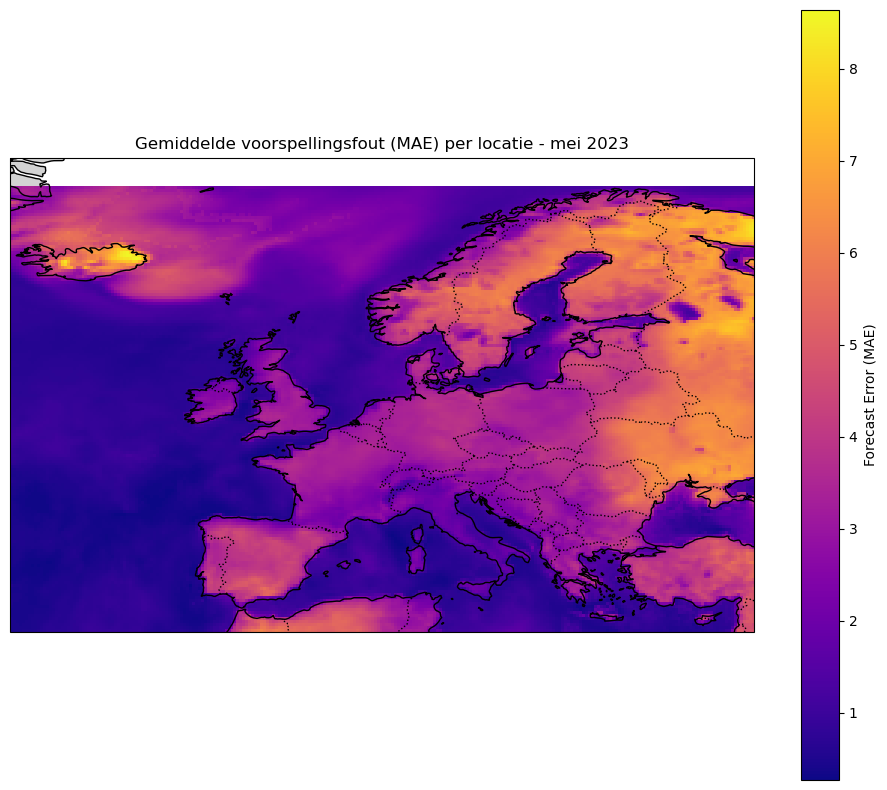

In [ ]:

# CSV inladen
df_errors = pd.read_csv('error_map.csv')

# Unieke coördinaten en grid maken
lats = np.sort(df_errors['latitude_deg'].unique())
lons = np.sort(df_errors['longitude_deg'].unique())
errors_grid = df_errors.pivot(index='latitude_deg', columns='longitude_deg', values='error').values

# Kaart maken
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Extent instellen (bounding box)
lat_min, lat_max = lats.min(), lats.max()
lon_min, lon_max = lons.min(), lons.max()
ax.set_extent([lon_min, lon_max, lat_min, lat_max])

# Heatmap van errors
img = ax.imshow(
    errors_grid,
    extent=(lon_min, lon_max, lat_min, lat_max),
    origin='lower',
    cmap='plasma',
    interpolation='nearest',
    transform=ccrs.PlateCarree()
)

# Colorbar
fig.colorbar(img, ax=ax, label='Forecast Error (MAE)')

# Land- en grenslijnen
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

# Titel
ax.set_title("Gemiddelde voorspellingsfout (MAE) per locatie - mei 2023")

plt.show()


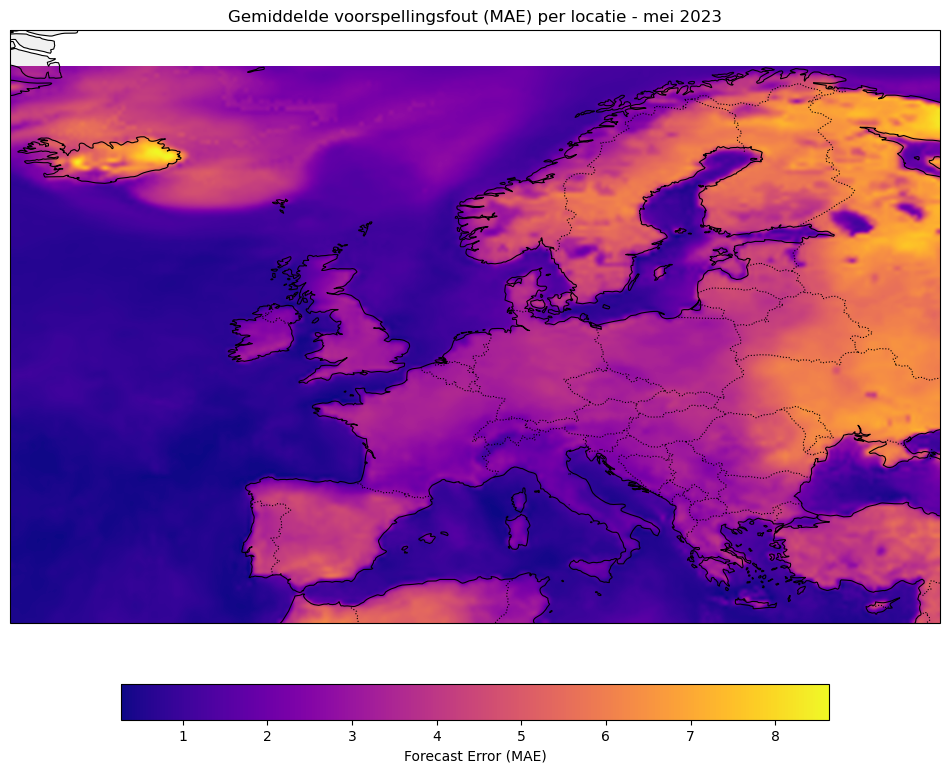

In [ ]:

# CSV inladen
df_errors = pd.read_csv('error_map.csv')
lats = np.sort(df_errors['latitude_deg'].unique())
lons = np.sort(df_errors['longitude_deg'].unique())
errors_grid = df_errors.pivot(index='latitude_deg', columns='longitude_deg', values='error').values

# Kaart
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()])

# Heatmap met vloeiende kleuren
img = ax.imshow(
    errors_grid,
    extent=(lons.min(), lons.max(), lats.min(), lats.max()),
    origin='lower',
    cmap='plasma',
    interpolation='spline36',  # vloeiende overgang
    transform=ccrs.PlateCarree()
)

# Land met lichte transparantie
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)  # alpha = 0.3 maakt het transparant
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.8)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)

# Horizontale colorbar, even breed als plot
cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.046, pad=0.08)
cbar.set_label('Forecast Error (MAE)')

# Titel
ax.set_title("Gemiddelde voorspellingsfout (MAE) per locatie - mei 2023")

plt.show()
